In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations

In [3]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [4]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [5]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff'
ncolor2 = '#00728e80'

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

orangecolor = '#e69426'

In [5]:
lr = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc.csv')

In [6]:
complexes = set(lr['complex_a']).union(lr['complex_b'])

In [7]:
len(complexes) * (len(complexes) -1) / 2

1437360.0

In [12]:
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv', index_col=0)

In [13]:
genes = set(lr['ligand']).union(lr['receptor'])

In [18]:
from itertools import combinations

In [22]:
pairs = list(combinations(genes, 2))

In [41]:
df = pd.DataFrame(list(combinations(genes, 2)), columns=['gene1', 'gene2'])
df['all_genes'] = pd.Series(pairs).apply(lambda x: list(x))
df['interaction'] = df.gene1.astype(str) + '_' + df.gene2.astype(str)
df = df.set_index('interaction')
df.head()

gene1    gene2         all_genes
interaction                                    
CD226_GALR2    CD226    GALR2    [CD226, GALR2]
CD226_IL18RAP  CD226  IL18RAP  [CD226, IL18RAP]
CD226_IGF1     CD226     IGF1     [CD226, IGF1]
CD226_IFNL1    CD226    IFNL1    [CD226, IFNL1]
CD226_INSL5    CD226    INSL5    [CD226, INSL5]

In [42]:
df.to_csv('/home/lnemati/pathway_crosstalk/data/interactions/all_ccc_gene_pairs.csv')

In [10]:
len(genes)

1576

In [11]:
len(genes) * (len(genes) -1) / 2

1241100.0

In [7]:
from itertools import combinations

In [14]:
lr = pd.read_csv('/home/lnemati/pathway_crosstalk/data/interactions/ccc.csv')

In [15]:
all_pairs = {f"{pair[0]}&{pair[1]}": [pair[0], pair[1]] for pair in combinations(lr['interaction'], 2) if pair[0] != pair[1]}

In [32]:
df = pd.DataFrame(all_pairs.keys(), columns=['interaction'])

In [33]:
df['interaction1'] = df.interaction.str.split('&', expand=True)[0]
df['interaction2'] = df.interaction.str.split('&', expand=True)[1]

In [35]:
df['all_genes'] = df.interaction.str.split(r'[_+&]').apply(lambda x: list(set(x)))

In [37]:
df.to_csv('/home/lnemati/pathway_crosstalk/data/interactions/pairs_of_interactions.csv', index=False)

In [224]:
# USE THIS IF YOU WANT TO MOVE TO WILCOXON SIGNED-RANK

# Set tissues that don't have both conditions to other tissues and group them together
#common_tissues = nmean.columns.intersection(tmean.columns)
#nmean.columns = np.where(nmean.columns.isin(common_tissues), nmean.columns, 'other_tissues')
#tmean.columns = np.where(tmean.columns.isin(common_tissues), tmean.columns, 'other_tissues')
#
#nmean = ndf.T.groupby(lambda x: sub2tissue[x]).mean().T # group normal subtissues by major tissue
#tmean = tdf.T.groupby(lambda x: sub2tissue[x]).mean().T # group tumor subtissues by major tissue
#common_tissues = nmean.columns.intersection(tmean.columns)
#
#nmean = nmean.loc[:, common_tissues]
#tmean = tmean.loc[:, common_tissues]


# Get differences and subset to only those with enough variance
#diff = tdf - ndf

#min_std = 1e-4
#diff = diff[diff.std(axis=1) > min_std]

In [8]:
tissues_df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/tissues.csv')

In [9]:
tissues_df.loc['thyroid_carcinoma', 'tissue'] = 'thyroid'

In [10]:
tissues_df.index = tissues_df.subtissue

In [11]:
paths2sub = dict(tissues_df.path)
paths2sub = {v: k for k, v in paths2sub.items()}

sub2tissue = dict(tissues_df.tissue)
#tissues = {v: k for k, v in tissues.items()}

sub2condition = dict(tissues_df.condition)


In [63]:
from scipy.stats import wilcoxon
resource = 'all_ccc_gene_pairs'
metric = 'adj'
#metric = 'kme_corr'
alternative='two-sided'

normal_vals = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/breakpoints/{resource}/{metric}/normal_values.csv', index_col=0)
tumor_vals = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/breakpoints/{resource}/{metric}/tumor_values.csv', index_col=0)

missing = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/breakpoints/{resource}/{metric}/missing_genes.csv', index_col=0)

In [64]:
normal_vals = normal_vals.T.groupby(lambda x: sub2tissue[x]).mean().T # group normal subtissues by major tissue
tumor_vals = tumor_vals.T.groupby(lambda x: sub2tissue[x]).mean().T # group tumor subtissues by major tissue

std = normal_vals.merge(tumor_vals, left_index=True, right_index=True).std(axis=1)

min_std = 0
normal_vals = normal_vals.loc[std > min_std]
tumor_vals = tumor_vals.loc[std > min_std]

In [65]:
from itertools import combinations, product

# Read interactions
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv', index_col=0)

# Get complexes and interactions
complex_a_genes = lr.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = lr.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)

In [72]:
### GET COMPLEXES

def get_complexes(complex_a_genes, complex_b_genes, index):

    # Get complexes with more than 1 gene
    complex_a = complex_a_genes[complex_a_genes.apply(lambda x: len(x)) > 1]
    complex_a.index = complex_a.apply(lambda x: '+'.join([gene for gene in sorted(x)]))

    complex_b = complex_b_genes[complex_b_genes.apply(lambda x: len(x)) > 1]
    complex_b.index = complex_b.apply(lambda x: '+'.join([gene for gene in sorted(x)]))

    # Join complex a and b and enumerate gene pairs
    complexes = pd.concat([complex_a, complex_b])
    complexes = complexes.apply(lambda x: list(combinations(x,2)))
    complexes.apply(lambda x: set([tuple(sorted(pair)) for pair in x])) # Sort pairs of genes

    # Generate A_B and B_A combinations and subset to those used in the df
    gp_complexes = set(complexes.values.sum()) # all unique gene pairs from complexes
    gp_complexes = [x[0] + '_' + x[1] for x in gp_complexes] + [x[1] + '_' + x[0] for x in gp_complexes]
    gp_complexes = set(gp_complexes).intersection(index)
    
    return complexes, gp_complexes

### GET INTERACTIONS

def get_interactions(complex_a_genes, complex_b_genes, index, already_found=None,):

    if already_found:
        interactions_genes = (complex_a_genes + complex_b_genes)
        interactions_pairs = interactions_genes.apply(lambda x: set(combinations(x,2)))
        interactions_pairs = interactions_pairs.apply(lambda x: set([tuple(sorted(pair)) for pair in x])) # Sort pairs of genes
        keep = interactions_pairs.apply(lambda x: len(x.intersection(significant_pairs)) == 0).values
        # Remove the ones that have already been identified
        complex_a_genes = complex_a_genes[keep]
        complex_b_genes = complex_b_genes[keep]

    interactions_dict = {}  # Store pairs as tuples for each index
    pairs = set()  # Set to store unique string patterns

    # Iterate over each gene list pair with their index
    for idx, (genes_a, genes_b) in zip(complex_a_genes.index, zip(complex_a_genes, complex_b_genes)):
        index_pairs = []

        # Generate pairs using product
        for gene_a, gene_b in product(genes_a, genes_b):
            index_pairs.append((gene_a, gene_b))  # Add tuple to interactions
            pairs.add(f'{gene_a}_{gene_b}')  # Add string pattern to pairs
            pairs.add(f'{gene_b}_{gene_a}')  # Add reverse pattern as well

        # Assign the list of tuples to the current index
        interactions_dict[idx] = index_pairs

    # Convert dictionary to Series
    interactions = pd.Series(interactions_dict)
    gp_interactions = pairs

    # Gene pairs to test in interactions (exclude those that are inside a complex)
    gp_interactions = set(gp_interactions).intersection(index)

    # All gene pairs in an interaction, including those from the same complex
    interactions = (complex_a_genes + complex_b_genes).apply(lambda x: list(combinations(x, 2)))

    return interactions, gp_interactions

### GET CIRCUITS

def get_circuits(complex_a_genes, complex_b_genes, index, already_found=None,):

    if already_found:
        already_found = set([sorted(x) for x in already_found])
        keep = (complex_a_genes + complex_b_genes).apply(lambda x: set(combinations(x,2)))
        keep = keep.apply(lambda x: len(x.intersection(significant_pairs)) == 0).values
        # Remove the ones that have already been identified
        complex_a_genes = complex_a_genes[keep]
        complex_b_genes = complex_b_genes[keep]

    interactions_dict = {}  # Store pairs as tuples for each index
    pairs = set()  # Set to store unique string patterns

    # Iterate over each gene list pair with their index
    for idx, (genes_a, genes_b) in zip(complex_a_genes.index, zip(complex_a_genes, complex_b_genes)):
        index_pairs = []

        # Generate pairs using product
        for gene_a, gene_b in product(genes_a, genes_b):
            index_pairs.append((gene_a, gene_b))  # Add tuple to interactions
            pairs.add(f'{gene_a}_{gene_b}')  # Add string pattern to pairs
            pairs.add(f'{gene_b}_{gene_a}')  # Add reverse pattern as well

        # Assign the list of tuples to the current index
        interactions_dict[idx] = index_pairs

    # Convert dictionary to Series
    interactions = pd.Series(interactions_dict)
    gp_interactions = pairs

    # Gene pairs to test in interactions (exclude those that are inside a complex)
    gp_interactions = set(gp_interactions).intersection(index)

    # All gene pairs in an interaction, including those from the same complex
    interactions = (complex_a_genes + complex_b_genes).apply(lambda x: list(combinations(x, 2)))

    return interactions, gp_interactions

In [58]:
interactions_genes = (complex_a_genes + complex_b_genes)
circuits_genes = pd.Series(combinations(interactions_genes, 2))
circuits_genes = circuits_genes.apply(lambda x: x[0] + x[1])
circuits_genes.index = pd.Series(combinations(interactions_genes.index, 2)).apply(lambda x: x[0] + '&' + x[1])

In [21]:
circuits_genes.apply(lambda x: (combinations(x, 2)))

CDH1_ITGA2+ITGB1&CDH1_ITGAE+ITGB7        [CDH1, ITGB1, ITGA2, CDH1, ITGAE, ITGB7]
CDH1_ITGA2+ITGB1&CDH1_KLRG1                     [CDH1, ITGB1, ITGA2, CDH1, KLRG1]
CDH1_ITGA2+ITGB1&CDH2_CDH2                       [CDH1, ITGB1, ITGA2, CDH2, CDH2]
CDH1_ITGA2+ITGB1&CDH2_FCER2                     [CDH1, ITGB1, ITGA2, CDH2, FCER2]
CDH1_ITGA2+ITGB1&CDH3_CDH3                       [CDH1, ITGB1, ITGA2, CDH3, CDH3]
                                                          ...                    
LAMB3_ITGA1+ITGB1&LAMC2_ITGA1+ITGB1    [LAMB3, ITGB1, ITGA1, LAMC2, ITGB1, ITGA1]
LAMB3_ITGA1+ITGB1&LAMC3_ITGA1+ITGB1    [LAMB3, ITGB1, ITGA1, LAMC3, ITGB1, ITGA1]
LAMC1_ITGA1+ITGB1&LAMC2_ITGA1+ITGB1    [LAMC1, ITGB1, ITGA1, LAMC2, ITGB1, ITGA1]
LAMC1_ITGA1+ITGB1&LAMC3_ITGA1+ITGB1    [LAMC1, ITGB1, ITGA1, LAMC3, ITGB1, ITGA1]
LAMC2_ITGA1+ITGB1&LAMC3_ITGA1+ITGB1    [LAMC2, ITGB1, ITGA1, LAMC3, ITGB1, ITGA1]
Length: 8026021, dtype: object

In [73]:
### TEST COMPLEXES

def test_wilcoxon(df, alternative='greater'):
    pvals = false_discovery_control(wilcoxon(df.T, alternative='greater').pvalue)
    pvals = pd.Series(pvals, n.index).sort_values()
    return pvals

def test_mannwhitneyu(t, n, alternative='greater'):
    if any(n.index != t.index):
        print('Error: different indices!')
        return
    
    pvals = false_discovery_control(mannwhitneyu(t.T, n.T, alternative=alternative).pvalue)
    pvals = pd.Series(pvals, n.index).sort_values()
    return pvals

### Test gene pairs in complexes

print('Step 1: testing complexes')

complexes, gp_complexes = get_complexes(complex_a_genes, complex_b_genes, index=normal_vals.index)
interactions, gp_interactions = get_interactions(complex_a_genes, complex_b_genes, index=normal_vals.index)

ndf = normal_vals.loc[gp_complexes]
tdf = tumor_vals.loc[gp_complexes]

pvals = test_mannwhitneyu(tdf, ndf, alternative=alternative)
significant_pairs = pvals[pvals < 0.05].index # significant pairs

print('  Significant pairs in complexes: ', sum(pvals < 0.05))

# Get all pairs with significant differences
significant_pairs = set([(pair[0], pair[1]) for pair in significant_pairs.str.split('_')] + [(pair[1], pair[0]) for pair in significant_pairs.str.split('_')])

# Get all complexes in which those pairs appear
significant_complexes = complexes.apply(lambda x: any([pair in significant_pairs for pair in x]))
significant_complexes = set(significant_complexes[significant_complexes].index)
print('  Complexes: ', len(significant_complexes))

# Get all interactions in which those pairs appear
significant_interactions = interactions.apply(lambda x: any([pair in significant_pairs for pair in x]))
significant_interactions = set(significant_interactions[significant_interactions].index)
print('  Interactions: ', len(significant_interactions))

Step 1: testing complexes
  Significant pairs in complexes:  45
  Complexes:  43
  Interactions:  313


In [74]:
### TEST INTERACTIONS

complexes, gp_complexes = get_complexes(complex_a_genes, complex_b_genes, index=normal_vals.index)
interactions, gp_interactions = get_interactions(complex_a_genes, complex_b_genes, normal_vals.index, significant_pairs)

### Test gene pairs in interactions

print('Step 2: testing interactions')

ndf = normal_vals.loc[gp_interactions]
tdf = tumor_vals.loc[gp_interactions]

print(len(ndf))

pvals = test_mannwhitneyu(tdf, ndf, alternative=alternative)
significant_pairs = pvals[pvals < 0.05].index # significant pairs

print('  Significant pairs in interactions: ', sum(pvals < 0.05))

# Get all pairs with significant differences
significant_pairs = set([(pair[0], pair[1]) for pair in significant_pairs.str.split('_')] + [(pair[1], pair[0]) for pair in significant_pairs.str.split('_')])

print('  Complexes: ', len(significant_complexes))

# Get all interactions in which those pairs appear
new_interactions = interactions.apply(lambda x: any([pair in significant_pairs for pair in x]))
new_interactions = set(new_interactions[new_interactions].index)

significant_interactions.update(new_interactions)
print('  Interactions: ', len(significant_interactions))

Step 2: testing interactions
2984
  Significant pairs in interactions:  375
  Complexes:  43
  Interactions:  808


# Bootstrap

In [38]:
bootstrap =  pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/bootstrap/bootstrap_all.csv', index_col=0)
N_btsp = bootstrap['n_genes'].value_counts()

bootstrap = pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/bootstrap/bootstrap_scores.csv', index_col=0)

In [39]:
interactions = pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/interactions_with_counts.csv', index_col=0)
interactions['n_genes'] = interactions.index.str.count('[_+]') + 1
interactions = interactions.query('n_genes > 1')

In [40]:
interactions['pvals'] = np.nan

for n in interactions['n_genes'].unique():    

    N_samples = N_btsp.loc[n]
    
    ints = interactions[interactions['n_genes'] == n]
    btsp = bootstrap[bootstrap['n_genes'] == n]
    
    ints = ints.tumor_score - ints.normal_score
    btsp = btsp.tumor_score - btsp.normal_score

    pvals = ints.apply(lambda x: sum(btsp >= x) / N_samples)
    pvals.loc[:] = false_discovery_control(pvals)
    
    interactions.loc[pvals.index, 'pvals'] = pvals

interactions = interactions.sort_values(by='pvals')

In [45]:
for x in interactions[interactions['pvals'] < 0.05].index:
    print(x)

CSF1_CSF1R
ALOX5+ALOX5AP+LTC4S_CYSLTR2
IL15_IL15RA+IL2RB+IL2RG


In [282]:
interactions.query('pvals < 0.05')

both_score  normal_score  tumor_score  n_genes   pvals
interaction                                                                   
ADM_CALCRL                     0.0      7.397436     0.333333        2  0.0000
ADM_CALCRL+GPER1+RAMP3         0.0      3.076923     0.000000        4  0.0172

In [220]:
interactions.loc['CSF1_CSF1R']

both_score      0.000000
normal_score    0.000000
tumor_score     9.666667
n_genes         2.000000
pvals           0.000000
Name: CSF1_CSF1R, dtype: float64

In [54]:
fake_interactions = pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/bootstrap/bootstrap_scores.csv', index_col=0)
fake_interactions = fake_interactions.set_index('all_genes')

In [57]:
(fake_interactions.tumor_score - fake_interactions.normal_score).head(20)

all_genes
['HLA-E', 'TYROBP']             9.435897
['CXCL9', 'PTGER4']             8.666667
['CXCL9', 'TREM2', 'TYROBP']    8.500000
['C3', 'CD28']                  8.333333
['HLA-E', 'HCST', 'KLRK1']      8.166667
['SPN', 'P2RY13']               7.871795
['PLA2G7', 'LILRB1']            7.782051
['CCL2', 'CD28']                7.666667
['DPEP2', 'TREM2', 'TYROBP']    7.435897
['PLA2G7', 'CD8B']              7.256410
['HLA-DMB', 'TNFRSF1B']         7.115385
['CXCL10', 'CD8A']              7.000000
['HLA-DQA1', 'CD28']            6.833333
['CXCL9', 'FPR3']               6.833333
['CCL8', 'FPR1']                6.833333
['CXCL8', 'IL1RAP']             6.679487
['ALDH1A3', 'CD28']             6.500000
['HLA-C', 'CXCR3']              6.333333
['HLA-DPB1', 'CCR5']            6.256410
['NTN1', 'NRCAM']               6.179487
dtype: float64

In [ ]:
sum(np.abs(btsp) > np.abs(7)) / N_samples)

<Axes: >

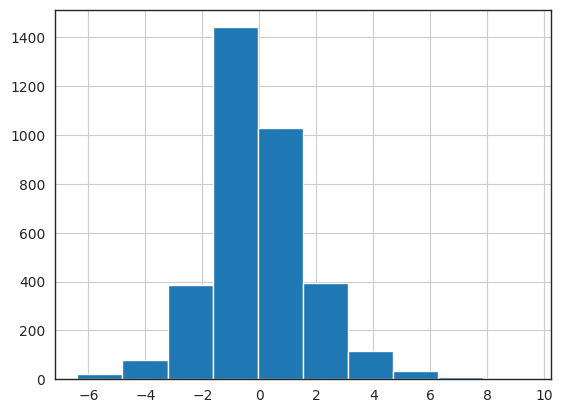

In [183]:
btsp.hist()

In [161]:
interactions[:20]

both_score  normal_score  tumor_score  n_genes  \
interaction                                                               
CSF1_CSF1R                 0.000000      0.000000     9.666667        2   
IL15_IL15RA+IL2RB+IL2RG    0.076923      0.500000     6.756410        4   
ADM_CALCRL+GPER1+RAMP3     0.000000      3.076923     0.000000        4   
HLA-E_CD8B                 0.500000      0.076923     7.833333        2   
CXCL9_CXCR3                1.000000      0.000000     7.666667        2   
CXCL10_CXCR3               0.000000      0.000000     7.666667        2   
HLA-DQB1_CD4               3.000000      0.115385     7.500000        2   
HLA-E_CD8A                 0.653846      0.500000     9.512821        2   
CD86_CD28                  0.000000      0.000000     7.333333        2   
PLA2G7_PTAFR               0.307692      1.000000     9.358974        2   
ITGB2_CD226                0.307692      0.000000     8.192308        2   
HLA-DQA1_CD4               4.000000      0.038462     8.500000        2   
HLA-E_KLRK1                1.500000      0.307692     8.166667        2   
CCL3_CCR1                  0.076923      0.000000     8.256410        2   
ENTPD1_ADORA3              0.461538      0.000000     7.371795        2   
ICAM1_SPN                  0.000000      0.000000     7.333333        2   
HLA-DQA2_CD4               0.000000      0.000000     6.833333        2   
SELPLG_SELL                4.141026      0.333333     7.525641        2   
ACE2_AGTR1                 0.000000      6.833333     0.000000        2   
CCL5_CCR5                  3.000000      1.000000     7.833333        2   

                            pvals  
interaction                        
CSF1_CSF1R               0.000000  
IL15_IL15RA+IL2RB+IL2RG  0.000000  
ADM_CALCRL+GPER1+RAMP3   0.017200  
HLA-E_CD8B               0.119143  
CXCL9_CXCR3              0.119143  
CXCL10_CXCR3             0.119143  
HLA-DQB1_CD4             0.119143  
HLA-E_CD8A               0.119143  
CD86_CD28                0.119143  
PLA2G7_PTAFR             0.119143  
ITGB2_CD226              0.119143  
HLA-DQA1_CD4             0.119143  
HLA-E_KLRK1              0.119143  
CCL3_CCR1                0.119143  
ENTPD1_ADORA3            0.119143  
ICAM1_SPN                0.119143  
HLA-DQA2_CD4             0.125100  
SELPLG_SELL              0.125100  
ACE2_AGTR1               0.125100  
CCL5_CCR5                0.125100

In [38]:
df['diff']

interaction
CSF1_CSF1R      0.000000
HLA-E_CD8A      0.000285
HLA-DQA1_CD4    0.000569
PLA2G7_PTAFR    0.000569
CCL3_CCR1       0.000854
                  ...   
THY1_ADGRE5     0.010817
TENM4_ADGRL1    0.009678
PTPRS_NTRK3     0.006832
ACE2_AGTR1      0.002562
ADM_CALCRL      0.002277
Name: diff, Length: 2853, dtype: float64

In [33]:
bootstrap['diff'].std()

1.7498524273792933

# Flow

In [59]:
flow = pd.read_csv('/home/lnemati/pathway_crosstalk/results/flow/interactions_with_counts.csv', index_col='interaction')

In [60]:
normal = flow.normal_score.sum()
tumor = flow.tumor_score.sum()
both = flow.both_score.sum()

In [64]:
flow.idxmax(axis=1).value_counts()

normal_score    1602
tumor_score     1100
both_score       151
dtype: int64

In [66]:
int_normal, int_tumor, int_both = flow.idxmax(axis=1).value_counts().values

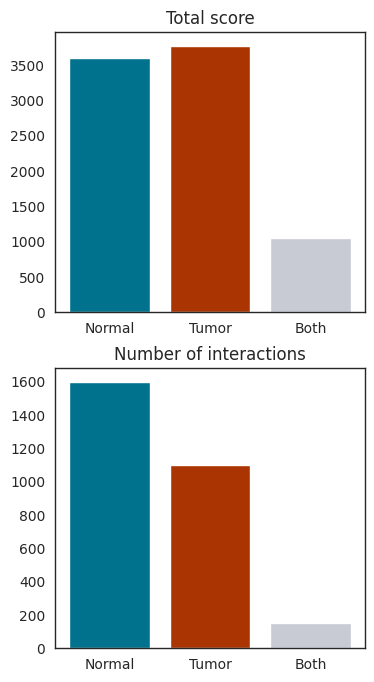

In [80]:


# Creating the bar plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4, 8))

categories = ['Normal', 'Tumor', 'Both']
scores = [normal, tumor, both]
colors = [ncolor, tcolor, '#C8CAD4']
ax1.bar(categories, scores, color=colors)
ax1.set_title('Total score')


categories = ['Normal', 'Tumor', 'Both']
interactions = [int_normal, int_tumor, int_both]
colors = [ncolor, tcolor, '#C8CAD4']
ax2.bar(categories, interactions, color=colors)
ax2.set_title('Number of interactions')

# Show plot
plt.show()

fig.savefig('/home/lnemati/pathway_crosstalk/results/figures/flow/flow_summary.pdf', bbox_inches='tight')


# Multiple Interactions

In [19]:
import igraph as ig
from scipy.sparse import csr_matrix

In [47]:
tc = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/tumor_coocs.csv', index_col=0)
to = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/tumor_occs.csv', index_col=0)
tj = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/tumor_jaccard.csv', index_col=0)

nc = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/normal_coocs.csv', index_col=0)
no = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/normal_occs.csv', index_col=0)
nj = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/normal_jaccard.csv', index_col=0)

np.fill_diagonal(tc.values, 0)
t_occs = pd.Series(np.diag(to), index=to.index)
n_occs = pd.Series(np.diag(no), index=no.index)
n = 3
t_keep = t_occs[(t_occs >= n)].index
n_keep = n_occs[(n_occs >= n)].index
keep = t_keep.intersection(n_keep)

tc = tc.loc[keep, keep]
to = to.loc[keep, keep]
tj = tj.loc[keep, keep]

nc = nc.loc[keep, keep]
no = no.loc[keep, keep]
nj = nj.loc[keep, keep]

In [48]:
diff = tj - nj

In [49]:
diff = stack_triangle(tj - nj, 'jaccard_difference').sort_values(by='jaccard_difference', ascending=False)
tj = stack_triangle(tj, 'j')
nj = stack_triangle(nj, 'j')

tc = stack_triangle(tc, 'c')
to = stack_triangle(to, 'o')

nc = stack_triangle(nc, 'c')
no = stack_triangle(no, 'o')

In [50]:
diff['tumor_jaccard'] = tj.loc[diff.index]
diff['normal_jaccard'] = nj.loc[diff.index]

diff['tumor_tot_occurrences'] = to.loc[diff.index]
diff['normal_tot_occurrences'] = no.loc[diff.index]

diff['tumor_cooccurrences'] = tc.loc[diff.index]
diff['normal_cooccurrences'] = nc.loc[diff.index]

In [52]:
diff

jaccard_difference  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA                 1.0   
                   ALDH1A2_CRABP2+RARA                      1.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                                 1.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                                 1.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                                 1.0   
...                                                         ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                        -1.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                       -1.0   
LAMA4_ITGA3+ITGB1  MMP2_ITGAV+ITGB3                        -1.0   
OMD_ITGAV+ITGB3    FN1_ITGA3+ITGB1                         -1.0   
LAMA4_ITGA3+ITGB1  OMD_ITGAV+ITGB3                         -1.0   

                                             tumor_jaccard  normal_jaccard  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA            1.0             0.0   
                   ALDH1A2_CRABP2+RARA                 1.0             0.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                            1.0             0.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                            1.0             0.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                            1.0             0.0   
...                                                    ...             ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                    0.0             1.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                   0.0             1.0   
LAMA4_ITGA3+ITGB1  MMP2_ITGAV+ITGB3                    0.0             1.0   
OMD_ITGAV+ITGB3    FN1_ITGA3+ITGB1                     0.0             1.0   
LAMA4_ITGA3+ITGB1  OMD_ITGAV+ITGB3                     0.0             1.0   

                                             tumor_tot_occurrences  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA                    3.0   
                   ALDH1A2_CRABP2+RARA                         3.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                                    4.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                                    4.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                                    4.0   
...                                                            ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                            9.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                           8.0   
LAMA4_ITGA3+ITGB1  MMP2_ITGAV+ITGB3                            9.0   
OMD_ITGAV+ITGB3    FN1_ITGA3+ITGB1                             6.0   
LAMA4_ITGA3+ITGB1  OMD_ITGAV+ITGB3                             7.0   

                                             normal_tot_occurrences  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA                    12.0   
                   ALDH1A2_CRABP2+RARA                         13.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                                    10.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                                    10.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                                    10.0   
...                                                             ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                             3.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                            3.0   
LAMA4_ITGA3+ITGB1  MMP2_ITGAV+ITGB3                             3.0   
OMD_ITGAV+ITGB3    FN1_ITGA3+ITGB1                              3.0   
LAMA4_ITGA3+ITGB1  OMD_ITGAV+ITGB3                              3.0   

                                             tumor_cooccurrences  \
ENPP1_P2RY2        ALDH1A2_CRABP2+RARA+RXRA                  3.0   
                   ALDH1A2_CRABP2+RARA                       3.0   
COL6A2_ITGAV+ITGB8 GZMA_F2R                                  4.0   
LAMA2_ITGAV+ITGB8  GZMA_F2R                                  4.0   
LAMA4_ITGAV+ITGB8  GZMA_F2R                                  4.0   
...                                                          ...   
JAM2_ITGA3+ITGB1   MMP2_ITGAV+ITGB3                          0.0   
MMP2_ITGAV+ITGB3   THBS1_ITGA3+ITGB1                         0.0 

In [53]:
diff.to_csv('/home/lnemati/pathway_crosstalk/results/pairs_of_interactions/pairs_of_interactions_unfiltered.csv')

In [ ]:
t_counts = diff[diff['diff'] > 0].index.get_level_values(0).value_counts()
t_counts = t_counts.add(diff[diff['diff'] > 0].index.get_level_values(1).value_counts())

In [ ]:
tj.sort_values(by='j', ascending=False, inplace=True)
tn.sort_values(by='j', ascending=False, inplace=True)

In [222]:
n = round(0.05 * len(tj))
wnt1 = tj.iloc[:n].index.get_level_values(0).str.contains('WNT')
wnt2 = tj.iloc[:n].index.get_level_values(1).str.contains('WNT')

sum(wnt1 & wnt2) / len(wnt1 | wnt2)

0.0691556576680069

In [224]:
wnt1 = tj.iloc[:].index.get_level_values(0).str.contains('WNT')
wnt2 = tj.iloc[:].index.get_level_values(1).str.contains('WNT')

sum(wnt1 & wnt2) / len(wnt1 | wnt2)

0.013931848533149528

In [230]:
n = round(0.05 * len(nj))
wnt1 = nj.iloc[:n].index.get_level_values(0).str.contains('WNT')
wnt2 = nj.iloc[:n].index.get_level_values(1).str.contains('WNT')

sum(wnt1 & wnt2) / len(wnt1 | wnt2)

0.10562894887995405

In [231]:
wnt1 = nj.iloc[:].index.get_level_values(0).str.contains('WNT')
wnt2 = nj.iloc[:].index.get_level_values(1).str.contains('WNT')

sum(wnt1 & wnt2) / len(wnt1 | wnt2)

0.013931848533149528

In [201]:
#diff.loc[('CSF1_CSF1R', 'CD274_PDCD1')]
tj.loc[('CD274_PDCD1', 'CSF1_CSF1R')]

j    0.333333
Name: (CD274_PDCD1, CSF1_CSF1R), dtype: float64

In [203]:
nj.loc[('CD274_PDCD1', 'CSF1_CSF1R')]

j    0.0
Name: (CD274_PDCD1, CSF1_CSF1R), dtype: float64

# Coevolution - Tumor

In [322]:
df_complete = pd.read_csv('/projects/bioinformatics/DB/CancerTracer/intra_heterogeneity_data.txt', sep='\t')

# Remove wrongly formatted row
df_complete = df_complete[~df_complete.index.isin(['p075_p3'])]

In [323]:
import re
import pandas as pd

def extract_mutation_info(mutation_string, allowed_strings=None):
    # Return empty lists if the input string is missing or empty
    if pd.isna(mutation_string) or mutation_string == '':
        return [], [], []

    # Split the string into individual entries
    gene_entries = mutation_string.split(',')
    
    if allowed_strings is None:
        filtered_entries = [entry for entry in gene_entries]
    else:
    # Filter entries that have allowed patterns and contain a closing parenthesis
        filtered_entries = [entry for entry in gene_entries if any([x in entry for x in allowed_strings]) and ')' in entry]

    # Initialize lists to store genes, mutations, and samples
    genes = []
    mutations = []
    samples = []

    # Process each filtered entry
    for entry in filtered_entries:
        # Get gene: Keep only the text before the first set of parentheses
        gene = re.sub(r'\s*\(.*$', '', entry).strip()

        # Get mutation: Extract the content inside the parentheses
        mutation_match = re.search(r'\(([^()]*)\)', entry)
        mutation = mutation_match.group(1).strip() if mutation_match else ''

        # Get sample: Keep only the text after the first set of parentheses
        sample_match = re.search(r'\(.*?\)\s*([- ]*)(.*)', entry)
        sample = sample_match.group(2).strip('- ').strip() if sample_match else ''

        # Append the parsed components to respective lists
        genes.append(gene)
        mutations.append(mutation)
        samples.append(sample)

    # Return the lists of genes, mutations, and samples
    return genes, mutations, samples


In [324]:
dfs = []

for col in ['Trunk_mutation', 'Branch_mutation', 'Private_mutation']:
    # Separate individual mutations
    # Use regex to split only on commas that are not inside parentheses
    vals = df_complete[col].str.split(r',\s*(?![^(]*\))', expand=True)
    
    # Find nans
    keep = ~vals.isna()
    
    # Add sample ids
    samples = df_complete['Sample']
    samples.index = samples.values
    vals.index = samples.values
    vals = (vals.T.astype(str) + samples).T
    
    # Remove nans
    vals = vals.values[keep]

    #allowed_strings = ['(p.', '(amp', '(del']
    allowed_strings = None
    genes, mutations, samples = extract_mutation_info(", ".join(vals), allowed_strings = allowed_strings)
    
    #genes     = [get_gene(x)     for x in vals]
    #mutations = [get_mutation(x) for x in vals]
    #samples   = [get_sample(x)   for x in vals]
    
    df = pd.DataFrame()
    df.index = genes
    df['mutation'] = mutations
    df['patient'] = samples
    df['when'] = col.strip('_mutation')
    
    dfs.append(df)
    
df = pd.concat(dfs)
#df['when'] = df['when'].map({'Trunk': 'Trunk', 'Private': 'Branch/Private', 'Branch': 'Branch/Private'})
df['gene'] = df.index

df = df[~df.index.isin(['', ' ', '-'])]
df = df[~df['patient'].isin(['', ' ', '-'])]
df = df[~df['gene'].isin(['', ' ', '-'])]


In [325]:
df.index = (df['patient'] + '_' + df['gene'])
df['unique_id'] = (df['patient'] + '_' + df['gene'])

In [326]:
counts = df.groupby(['unique_id', 'when']).size().reset_index(name='count')
counts = counts.sort_values(by='count', ascending=False)
counts['patient'] = counts['unique_id'].str.split('_').apply(lambda x: '_'.join(x[:-1]))
counts['gene'] = counts['unique_id'].str.split('_').apply(lambda x: '_'.join(x[-1:]))

In [327]:
total = counts.groupby('unique_id')['count'].sum()

In [328]:
# Pivot the DataFrame to have 'when' as x-axis values, 'unique_id' as columns
pivot_df = counts.pivot(index='when', columns='unique_id', values='count').fillna(0)

# Reorder
order = ['Trunk', 'Branch', 'Private',]
pivot_df = pivot_df.loc[order]

# Only keep cases with mutations in more than one stage
pivot_df = pivot_df.T[(pivot_df > 0).sum() > 1]

# Make cumulative by summing mutations of previous stages
#pivot_df['Trunk']    = pivot_df['Trunk' ]
#pivot_df['Branch']   = pivot_df['Trunk' ] + pivot_df['Branch' ]
#pivot_df['Private']  = pivot_df['Branch'] + pivot_df['Private'] # Not summing trunk as it's alredy in private

In [329]:
pivot_df['time_avg'] = (pivot_df['Private'] - pivot_df['Trunk']) / (pivot_df['Private'] + pivot_df['Branch'] + pivot_df['Trunk'])

In [330]:
pivot_df['Trunk']   = pivot_df['Trunk'].div(total, fill_value=0)
pivot_df['Branch']  = pivot_df['Branch'].div(total, fill_value=0)
pivot_df['Private'] = pivot_df['Private'].div(total, fill_value=0)

In [331]:
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv', index_col=0)
lr = set(lr['ligand']).union(lr['receptor'])

is_lr = pd.Series(pivot_df.index).str.split('_').apply(lambda x: x[-1] in lr).values
pivot_df['is_lr'] = is_lr

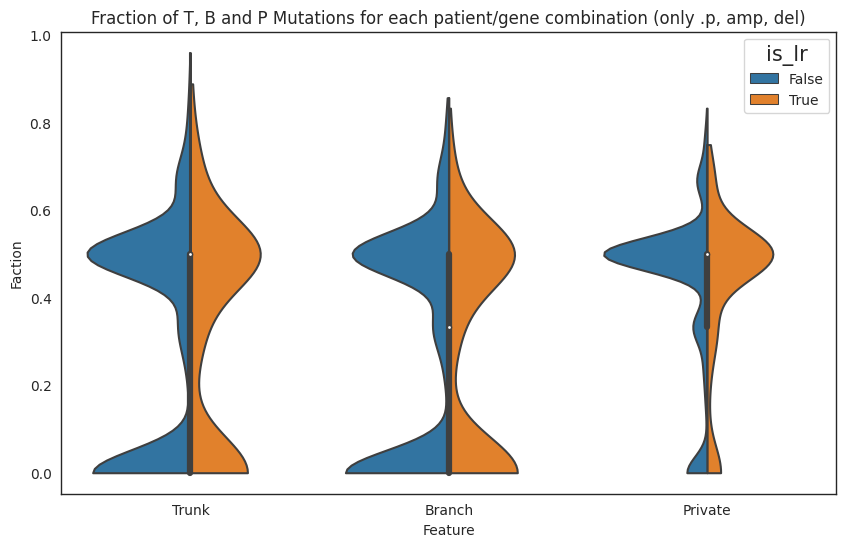

In [332]:
df_melted = pd.melt(pivot_df.reset_index(), id_vars=['unique_id', 'is_lr'], value_vars=['Trunk', 'Branch', 'Private'], 
                    var_name='Feature', value_name='Value')

#df_melted['Value'] = np.log10(0.001 + df_melted['Value'])

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Feature', y='Value', hue='is_lr', data=df_melted, cut=0, split=True)

# Set labels and title
plt.xlabel('Feature')
plt.ylabel('Faction')
plt.title('Fraction of T, B and P Mutations for each patient/gene combination (only .p, amp, del)')
plt.show()

Text(0.5, 1.0, 'Time average of mutations')

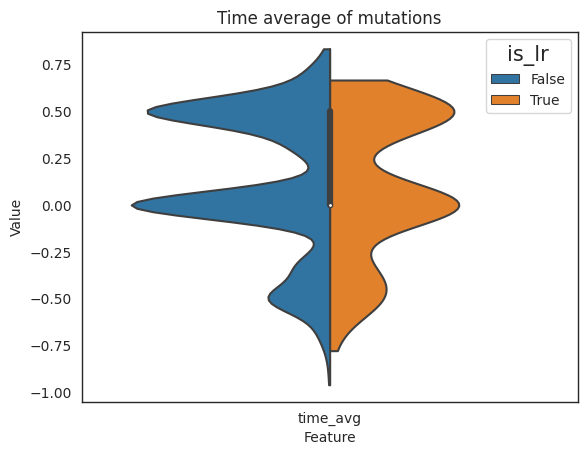

In [336]:
df_melted = pd.melt(pivot_df.reset_index(), id_vars=['unique_id', 'is_lr'], value_vars=['time_avg'], 
                    var_name='Feature', value_name='Value')
sns.violinplot(x='Feature', y='Value', hue='is_lr', data=df_melted, cut=0, split=True)
plt.title('Time average of mutations')

<Axes: title={'center': 'Time average of mutations (after summing all counts for each gene)'}, xlabel='Feature', ylabel='Value'>

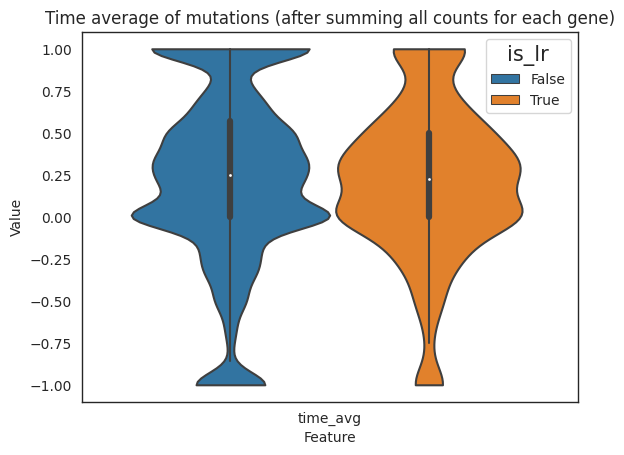

In [337]:
# Group by 'gene' and 'when' columns, then sum the 'count' values
genes_df = counts.groupby(['gene', 'when']).agg({'count': 'sum'}).reset_index()
genes_df = genes_df.pivot(index='when', columns='gene', values='count').fillna(0).T
genes_df['time_avg'] = (genes_df['Private'] - genes_df['Trunk']) / (genes_df['Private'] + genes_df['Branch'] + genes_df['Trunk'])

genes_df['is_lr'] = genes_df.index.isin(lr)

genes_df = pd.melt(genes_df.reset_index(), id_vars=['gene', 'is_lr'], value_vars=['time_avg'], 
                    var_name='Feature', value_name='Value')
#sns.violinplot(x='Feature', y='Value', hue='is_lr', data=genes_df, cut=0, split=False)

plt.title('Time average of mutations (after summing all counts for each gene)')
sns.violinplot(x='Feature', y='Value', hue='is_lr', data=genes_df, cut=0, split=False)

In [338]:
counts['is_lr'] = counts.gene.isin(lr)

<Axes: title={'center': 'Fraction of T,B,P mutations targeting ccc genes vs other genes'}, xlabel='Feature', ylabel='Value'>

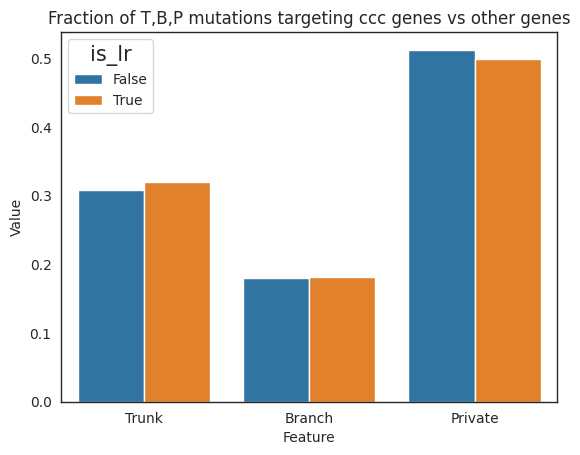

In [340]:
# Group by 'gene' and 'when' columns, then sum the 'count' values
lr_df = counts.groupby(['is_lr', 'when']).agg({'count': 'sum'}).reset_index()
lr_df = lr_df.pivot(index='when', columns='is_lr', values='count').fillna(0).T
#lr_df['time_avg'] = (lr_df['Private'] - lr_df['Trunk']) / (lr_df['Private'] + lr_df['Branch'] + lr_df['Trunk'])

lr_df = lr_df.T.div(lr_df.sum(axis=1)).T

lr_df = pd.melt(lr_df.reset_index(), id_vars=['is_lr'], value_vars=['Trunk', 'Branch', 'Private'], 
                    var_name='Feature', value_name='Value')

plt.title('Fraction of T,B,P mutations targeting ccc genes vs other genes')
sns.barplot(x='Feature', y='Value', data=lr_df, hue='is_lr')
#sns.violinplot(x='Feature', y='Value', hue='is_lr', data=genes_df, cut=0, split=False)

In [282]:
lr_df.sum(axis=1)

is_lr
False    133439
True      13985
dtype: int64

when     Branch   Private     Trunk
is_lr                              
False  0.179595  0.512144  0.308261
True   0.182052  0.498820  0.319128

In [38]:
pivot_df.query('is_lr').time_avg.mean()

0.13460317460317459

In [39]:
pivot_df.query('not is_lr').time_avg.mean()

0.18339122646705616

In [332]:
def dict_to_dataframe(data_dict):
    # Convert each series to a DataFrame and concatenate them along the columns
    df = pd.DataFrame(data_dict).T
    
    # Fill missing values with 0
    df = df.fillna(0)
    
    return df

counts = {}

for sample, sampledf in df.query('when == "Trunk"').groupby('sample'):
    counts[sample] = sampledf['gene'].value_counts()
    
# Convert the dictionary to a DataFrame
trunk_df = dict_to_dataframe(counts)

counts = {}

for sample, sampledf in df.query('when == "Branch/Private"').groupby('sample'):
    counts[sample] = sampledf['gene'].value_counts()
    
# Convert the dictionary to a DataFrame
priv_df = dict_to_dataframe(counts)

In [350]:
trunk_mean = trunk_df.mean()
priv_mean = priv_df.mean()

In [354]:
trunk_df

2-Mar  3-Mar  7-Mar  A1BG  A1CF  A2LD1  A2M  A2ML1  A3GALT2  \
p001_PCRC01    0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p001_PCRC03    0.0    0.0    0.0   0.0   0.0    0.0  1.0    0.0      0.0   
p001_PCRC05    0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p001_PCRC06    0.0    0.0    0.0   0.0   0.0    0.0  0.0    1.0      0.0   
p001_PCRC08    0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
...            ...    ...    ...   ...   ...    ...  ...    ...      ...   
p168_P04       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p168_P17       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p168_P18       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p168_P49       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   
p168_P90       0.0    0.0    0.0   0.0   0.0    0.0  0.0    0.0      0.0   

             A4GALT  ...  ZSWIM7  ZSWIM8  ZUFSP  ZWILCH  ZWINT  ZXDA  ZXDB  \
p001_PCRC01     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p001_PCRC03     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p001_PCRC05     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p001_PCRC06     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p001_PCRC08     0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
...             ...  ...     ...     ...    ...     ...    ...   ...   ...   
p168_P04        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p168_P17        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p168_P18        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p168_P49        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   
p168_P90        0.0  ...     0.0     0.0    0.0     0.0    0.0   0.0   0.0   

             ZYG11A  ZYG11B  ZZEF1  
p001_PCRC01     0.0     0.0    0.0  
p001_PCRC03     0.0     0.0    0.0  
p001_PCRC05     0.0     0.0    0.0  
p001_PCRC06     0.0     0.0    0.0  
p001_PCRC08     0.0     0.0    0.0  
...             ...     ...    ...  
p168_P04        0.0     0.0    0.0  
p168_P17        0.0     0.0    0.0  
p168_P18        0.0     0.0    0.0  
p168_P49        0.0     0.0    0.0  
p168_P90        0.0     0.0    0.0  

[746 rows x 14638 columns]

In [351]:
lr = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz_all_pairs.csv', index_col=0)
lr = set(lr['ligand']).union(lr['receptor'])

In [352]:
print(trunk_mean.loc[~trunk_mean.index.isin(lr)].mean())
print(priv_mean.loc[~priv_mean.index.isin(lr)].mean())


0.0041163218312992985
0.006831978319383481


In [353]:
print(trunk_mean.loc[trunk_mean.index.isin(lr)].mean())
print(priv_mean.loc[priv_mean.index.isin(lr)].mean())


0.005100233355960405
0.008699126620823535


In [229]:
df['ccc'] = np.where(df.index.isin(lr), 'CCC Genes', 'Other Genes')

In [230]:
df

mutation     when          ccc
KIF1B    Chr1:10355741:G>A    Trunk  Other Genes
EPHA8    Chr1:22924187:G>T    Trunk    CCC Genes
GJA4     Chr1:35260188:G>A    Trunk  Other Genes
C8B      Chr1:57415389:C>T    Trunk  Other Genes
ANGPTL3  Chr1:63066797:T>G    Trunk    CCC Genes
...                    ...      ...          ...
SLAMF7             p.E257D  Private  Other Genes
AJAP1              p.V200I  Private  Other Genes
BTRC               p.L210L  Private  Other Genes
DUSP27             p.A321T  Private  Other Genes
PASD1              p.L148V  Private  Other Genes

[158218 rows x 3 columns]

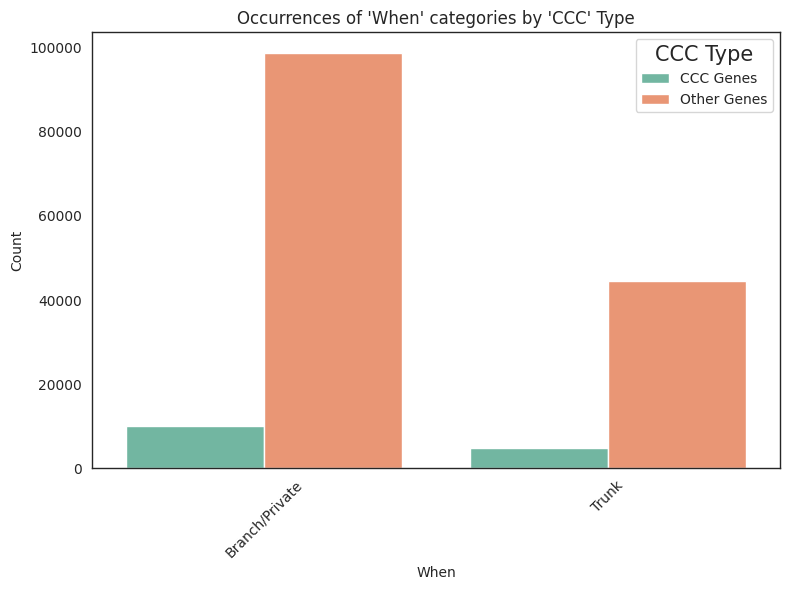

In [248]:

# Count occurrences for each combination of 'when' and 'ccc'
counts = df.groupby(['when', 'ccc']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='when', y='count', hue='ccc', data=counts, palette='Set2')

# Adding labels and title
plt.title("Occurrences of 'When' categories by 'CCC' Type")
plt.xlabel("When")
plt.ylabel("Count")
plt.legend(title="CCC Type")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [249]:
df['gene'] = df.index

In [250]:
occurrences = df.groupby(['gene', 'when']).size().unstack(fill_value=0)

In [251]:
occurrences['ccc'] = np.where(occurrences.index.isin(lr), 'CCC Genes', 'Other Genes')

In [254]:
occurrences.query('ccc == "CCC Genes"')[['Trunk', 'Branch/Private', ]].mean()

when
Trunk             3.278833
Branch/Private    6.850746
dtype: float64

In [255]:
occurrences.query('ccc == "Other Genes"')[['Trunk', 'Branch/Private', ]].mean()

when
Trunk             2.347993
Branch/Private    5.189857
dtype: float64

In [205]:
for category, subset in df.groupby(['ccc']):
    print(category)
    print(subset.head())
    print()

CCC Genes
                   mutation   when        ccc
EPHA8     Chr1:22924187:G>T  Trunk  CCC Genes
ANGPTL3   Chr1:63066797:T>G  Trunk  CCC Genes
WNT2B    Chr1:113059863:C>T  Trunk  CCC Genes
PROS1     Chr3:93646206:C>T  Trunk  CCC Genes
GRIA1    Chr5:153175054:G>A  Trunk  CCC Genes

Other Genes
                 mutation   when          ccc
KIF1B   Chr1:10355741:G>A  Trunk  Other Genes
GJA4    Chr1:35260188:G>A  Trunk  Other Genes
C8B     Chr1:57415389:C>T  Trunk  Other Genes
WDR63   Chr1:85559237:C>T  Trunk  Other Genes
FLG2   Chr1:152327032:C>T  Trunk  Other Genes



In [173]:
for key, df in dfs.items():
    print(key, sum(df.index.isin(lr)) / len(df))

Trunk_mutation 0.09694635046747722
Branch_mutation 0.09322929089855862
Private_mutation 0.09112897224082757


In [174]:
df

mutation     when
OR14A16  Chr1:247978107:T>A  private
PASK     Chr2:242062155:T>A  private
PASK     Chr2:242062159:T>A  private
SLC6A19    Chr5:1219068:C>G  private
CEP85L   Chr6:118801040:T>G  private
...                     ...      ...
SLAMF7              p.E257D  private
AJAP1               p.V200I  private
BTRC                p.L210L  private
DUSP27              p.A321T  private
PASD1               p.L148V  private

[80622 rows x 2 columns]

In [123]:
dfs

{'Trunk_mutation':                   mutation
 KIF1B    Chr1:10355741:G>A
 EPHA8    Chr1:22924187:G>T
 GJA4     Chr1:35260188:G>A
 C8B      Chr1:57415389:C>T
 ANGPTL3  Chr1:63066797:T>G
 ...                    ...
 SMARCA4            p.S813L
 SRPRB              p.P119L
 THSD7B             p.P440P
 TP53                p.H47D
 ZMAT1              p.E505Q
 
 [49842 rows x 1 columns],
 'Branch_mutation':                    mutation
 ZNF683    Chr1:26689642:G>A
 EIF5B     Chr2:99992868:G>A
 CCDC14   Chr3:123634286:T>C
 PDCD6       Chr5:271863:C>T
 GLI3      Chr7:42012081:G>A
 ...                     ...
 PKHD1              p.S2532S
 PPP1R1B             p.S164F
 PTPRD               p.S913S
 TP63                p.S624S
 USP3                p.R332T
 
 [29347 rows x 1 columns],
 'Private_mutation':                    mutation
 OR14A16  Chr1:247978107:T>A
 PASK     Chr2:242062155:T>A
 PASK     Chr2:242062159:T>A
 SLC6A19    Chr5:1219068:C>G
 CEP85L   Chr6:118801040:T>G
 ...                     ..

In [121]:
df.index.value_counts()

TP53      423
MUC4      224
TTN       160
-         149
EGFR      137
         ... 
TMC8        1
GAL         1
SH3RF1      1
RPL13A      1
GUCY2E      1
Length: 15163, dtype: int64

In [84]:
np.reshape(df_complete.Trunk_mutation.str.split(',', expand=True).values, -1).shape

(6951437,)

In [86]:
1153*6029

6951437

In [72]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/data/tumor_coev/all_cancers/Patient/jaccard.csv')

In [5]:
df.set_index(['gene1', 'gene2'], inplace=True)

In [8]:
# Diff complex interactions
fpr, tpr, thr, auroc = generate_roc_curve(
    data=df,
    target_col="interaction",
    feature_col="jaccard",
)

print('auroc')

auroc


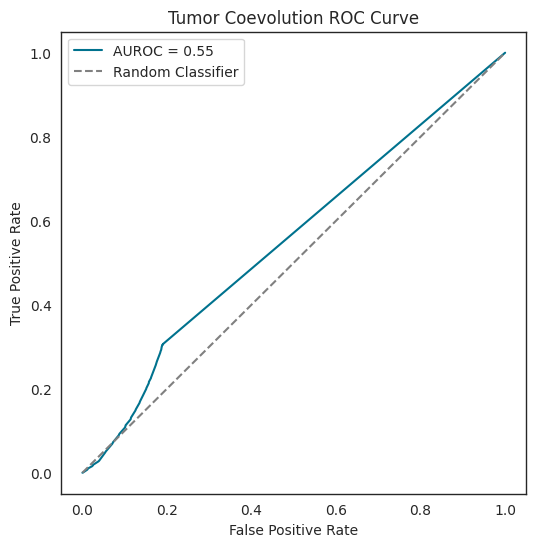

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tumor Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()

In [52]:
allowed_strings = ['(p.', 'amp', 'del']

In [53]:
def extract_gene_symbols(mutation_string):
    if pd.isna(mutation_string) or mutation_string == '':
        return []

    # Split the string into individual entries
    gene_entries = mutation_string.split(',')

    # Filter entries to only those with parentheses
    #allowed_strings = ['(p.', '(amp', '(del']
    
    filtered_entries = [entry for entry in gene_entries if any([ x in entry for x in allowed_strings]) and ')' in entry]

    # Remove the parentheses and any content within them
    cleaned_entries = [re.sub(r'\([^()]*\)', '', entry).strip() for entry in filtered_entries]

    # Return the cleaned entries
    return cleaned_entries

In [54]:
#gene_names = pd.read_csv('/home/lnemati/resources/biomart/ensembl_to_symbol_filtered.csv.gz')['Gene name'].values
output_dir = '/home/lnemati/pathway_crosstalk/results/coevolution/tumor'
df_complete = pd.read_csv('/projects/bioinformatics/DB/CancerTracer/intra_heterogeneity_data.txt', sep='\t')
df_complete = df_complete.set_index('Sample', drop=False)
df_complete = df_complete.replace({'-': ''})

# Remove wrongly formatted row
df_complete = df_complete[~df_complete.index.isin(['p075_p3'])]

df_complete['Trunk'] = df_complete['Trunk_mutation'].apply(extract_gene_symbols)
df_complete['Branch'] = df_complete['Branch_mutation'].apply(extract_gene_symbols)
df_complete['Private'] = df_complete['Private_mutation'].apply(extract_gene_symbols)

In [55]:
keep = df_complete.apply(lambda x: any([len(x['Trunk']), len(x['Branch']), len(x['Private'])]) != 0, axis=1).values
df_complete = df_complete[keep]

In [4]:
mutations = pd.read_csv('/home/lnemati/pathway_crosstalk/results/coevolution/tumor/mutations_df.csv')

In [5]:
mutations = mutations.query("cancertype == 'all_cancers'")

mtypes = pd.DataFrame(0, index=mutations.gene.unique(), columns=['Trunk', 'Branch', 'Private', 'Patient'])

for gene, df in mutations.groupby('gene'):
    counts = df['mutation'].value_counts()
    for mutation_type in counts.index:
        mtypes.at[gene, mutation_type] = counts.loc[mutation_type]
        mtypes.at[gene, mutation_type] = counts.loc[mutation_type]
        mtypes.at[gene, mutation_type] = counts.loc[mutation_type]

mtypes = mtypes.drop(columns=['Patient'])
mtypes['Tot'] = mtypes.sum(axis=1)

mtypes = mtypes.sort_values(by='Tot', ascending=False)
fracs = mtypes.iloc[:, :3].div(mtypes['Tot'].values, axis=0)

mtypes = mtypes.iloc[:, :3]

In [6]:
mtypes.mean()

Trunk      2.003077
Branch     1.214977
Private    3.520719
dtype: float64

In [ ]:
# Create a stacked bar plot
ax = mtypes[:50].plot(kind='bar', stacked=True, figsize=(10, 7))

# Set labels and title
ax.set_xlabel('Genes')
ax.set_ylabel('Fraction')
ax.set_title('Fractions of mutation types')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

In [61]:
all_pairs = pd.read_csv('/home/lnemati/pathway_crosstalk/data/tumor_coev/all_cancers/Patient/cooccurrences_unfiltered.csv').set_index(['gene1', 'gene2'])

In [64]:
max_lor = all_pairs.loc[all_pairs.log2_odds_ratio <  np.inf, 'log2_odds_ratio'].max() + 1
min_lor = all_pairs.loc[all_pairs.log2_odds_ratio > -np.inf, 'log2_odds_ratio'].min() - 1

all_pairs.loc[all_pairs.log2_odds_ratio ==  np.inf, 'log2_odds_ratio'] = max_lor
all_pairs.loc[all_pairs.log2_odds_ratio == -np.inf, 'log2_odds_ratio'] = min_lor

all_pairs['-log10pval'] = -np.log10(all_pairs['pval'])

In [67]:
# Diff complex interactions
fpr, tpr, thr, auroc = generate_roc_curve(
    data=all_pairs,
    target_col="interaction",
    feature_col="-log10pval",
)

print('auroc')

KeyError: 'interaction'

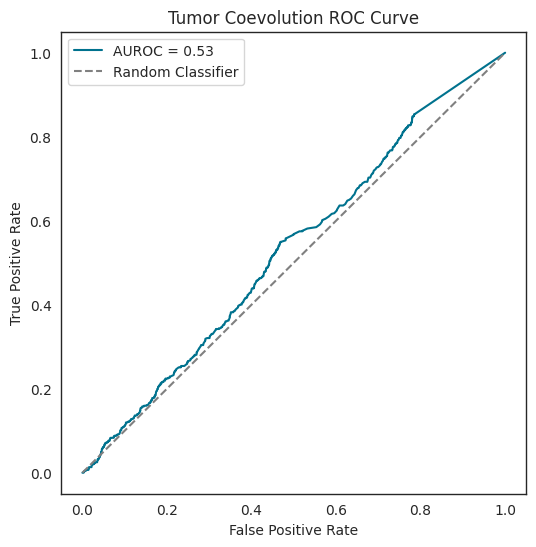

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tumor Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()


In [80]:
tissue = 'All Cancers'
mutation_type='Patient'

In [85]:
df_complete = pd.read_csv('/projects/bioinformatics/DB/CancerTracer/intra_heterogeneity_data.txt', sep='\t')
df_complete = df_complete.set_index('Sample')
df_complete = df_complete.replace({'-': ''})

# Remove wrongly formatted row
df_complete = df_complete[~df_complete.index.isin(['p075_p3'])]

In [81]:
coev = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/coevolution/tumor/{tissue}/{mutation_type}/jaccard.csv', index_col=0)
gene_counts = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/coevolution/tumor/{tissue}/{mutation_type}/gene_counts.csv', index_col=0)
gene_counts = gene_counts.rename(columns={'genes': 'All'})

In [82]:
path = '/home/lnemati/pathway_crosstalk/results/coevolution/tumor/All Cancers'

for mutation_type in ['Trunk', 'Branch', 'Private']:
    gene_counts[mutation_type] = pd.read_csv(os.path.join(path, mutation_type, 'gene_counts.csv'), index_col=0)['genes']
    
gene_counts = gene_counts.fillna(0)

In [83]:
path = '/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv'

interactions = pd.read_csv(path)

# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

# make all_interacting_genes a list containing all unique genes in the interactions
all_interacting_genes = list(set().union(*interactions_all_genes))
print("Number of interacting genes: ", len(all_interacting_genes))

Number of interacting genes:  1576


In [84]:
gene_counts['interactor'] = False
gene_counts.loc[gene_counts.index.isin(all_interacting_genes), 'interactor'] = True

In [10]:
from itertools import combinations, product

# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

def update_diff_complex(
    coev,
    genes_series_a,
    genes_series_b
):
    for genes_a, genes_b in zip(genes_series_a, genes_series_b):
        for pair in product(genes_a, genes_b):
            gene_a, gene_b = pair
            if pair in coev.index:
                coev.loc[pair, "interaction"] = 1
            elif (gene_b, gene_a) in coev.index:
                coev.loc[(gene_b, gene_a), "interaction"] = 1
    return

print("Reading interactions.csv")
# read interactions.csv

path = '/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv'

interactions = pd.read_csv(path)

# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

# make all_interacting_genes a list containing all unique genes in the interactions
all_interacting_genes = list(set().union(*interactions_all_genes))
print("Number of interacting genes: ", len(all_interacting_genes))

# ----- ROC all gene pairs -----

print("Generating ROC curves")

print("coev has shape: ", coev.shape)

# flatten TOM matrix, remove diagonal and duplicated values
print("Flattening coev matrix")
coev = pd.DataFrame(
    coev.where(
        np.tri(
            coev.shape[0],
            dtype=bool,
            k=-1
        ),
        np.nan
    ).stack(dropna=True), columns=["coev"]
)
print("coev has now shape: ", coev.shape)

coev['interaction'] = 0

update_diff_complex(coev, complex_a_genes, complex_b_genes)

print("Total number of interacting pairs: ", coev["interaction"].sum())

# Diff complex interactions
fpr, tpr, thr, auroc = generate_roc_curve(
    data=coev,
    target_col="interaction",
    feature_col="coev",
)

print('auroc:', auroc)

# ------ Rank Sum Test VS All -------
#print("Performing rank sum test")
#
## Perform rank sum test: do interacting pairs have higher TOM than other pairs?
#U_all, p_all = mannwhitneyu(
#    coev.loc[coev['interaction'] == True, "coev"],
#    coev.loc[coev['interaction'] == False, "coev"],
#    alternative="greater"
#)
#
#print('U:', U_all)
#print('p:', p_all)

Reading interactions.csv
Number of interacting genes:  1576
Generating ROC curves
coev has shape:  (20155, 20155)
Flattening coev matrix
coev has now shape:  (203101935, 1)
Total number of interacting pairs:  3433
auroc: 0.5881786390268736


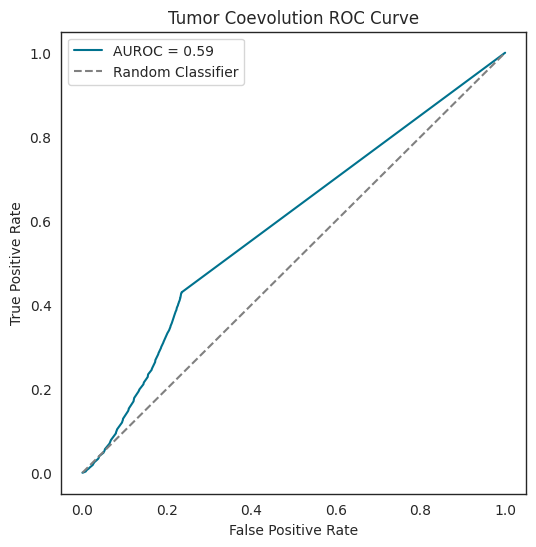

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tumor Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()


In [42]:
tcoev_int = coev[coev.interaction == 1]

In [46]:
tcoev_int.to_csv('/home/lnemati/pathway_crosstalk/results/coevolution/comparison/lr_pairs_tumor_coev_all.csv')

In [86]:
cols = ['Trunk', 'Branch', 'Private']

fracs = gene_counts[cols]

tot = df_complete.shape[0]

for col in cols:
    fracs[col] = gene_counts[col] / tot

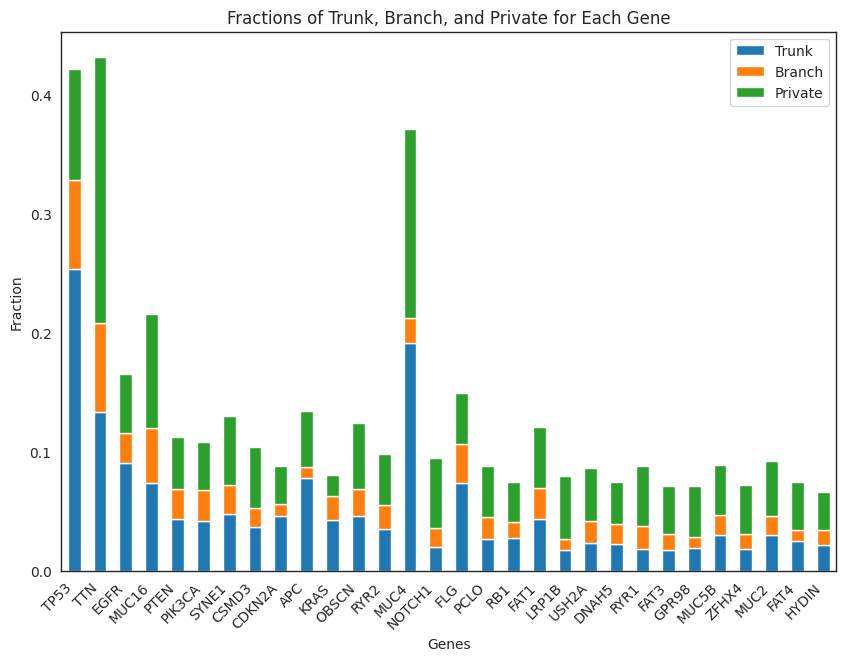

In [93]:
# Create a stacked bar plot
ax = fracs[:30].plot(kind='bar', stacked=True, figsize=(10, 7))

# Set labels and title
ax.set_xlabel('Genes')
ax.set_ylabel('Fraction')
ax.set_title('Fractions of Trunk, Branch, and Private for Each Gene')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

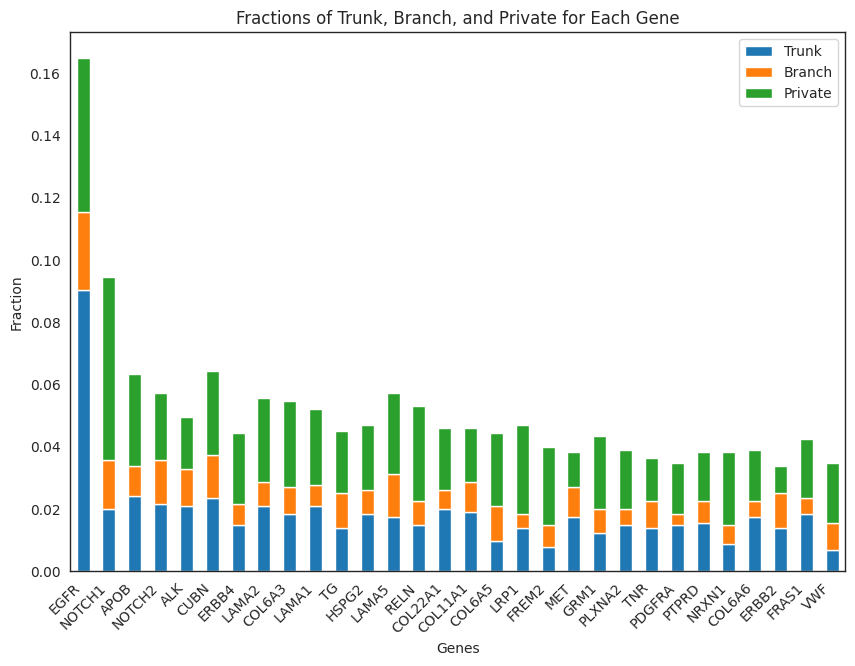

In [94]:
interactors = gene_counts[gene_counts['interactor']].index

# Create a stacked bar plot
ax = fracs.loc[interactors][0:30].plot(kind='bar', stacked=True, figsize=(10, 7))

# Set labels and title
ax.set_xlabel('Genes')
ax.set_ylabel('Fraction')
ax.set_title('Fractions of Trunk, Branch, and Private for Each Gene')
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

In [90]:
mutated = gene_counts[gene_counts['All'] > 10].index

In [99]:
df_frac

Trunk    Branch   Private
TP53   0.253472  0.074653  0.093750
MUC4   0.190972  0.021701  0.158854
TTN    0.133681  0.074653  0.223090
EGFR   0.090278  0.025174  0.049479
APC    0.078125  0.008681  0.047743
...         ...       ...       ...
CDC7   0.000000  0.001736  0.009549
NBPF1  0.000000  0.006944  0.006944
PANK3  0.000000  0.001736  0.009549
NPHP3  0.000000  0.000868  0.009549
MPL    0.000000  0.003472  0.010417

[3423 rows x 3 columns]

In [101]:
df_frac = fracs.loc[mutated].sort_values(by='Trunk', ascending=False)
df_frac.loc[df_frac.index.intersection(interactors)][:20]

Trunk    Branch   Private
EGFR      0.090278  0.025174  0.049479
APOB      0.024306  0.009549  0.029514
CUBN      0.023438  0.013889  0.026910
NOTCH2    0.021701  0.013889  0.021701
LAMA2     0.020833  0.007812  0.026910
ALK       0.020833  0.012153  0.016493
LAMA1     0.020833  0.006944  0.024306
COL22A1   0.019965  0.006076  0.019965
NOTCH1    0.019965  0.015625  0.059028
COL11A1   0.019097  0.009549  0.017361
COL6A3    0.018229  0.008681  0.027778
FRAS1     0.018229  0.005208  0.019097
HSPG2     0.018229  0.007812  0.020833
HLA-DRB5  0.018229  0.000000  0.004340
LAMA5     0.017361  0.013889  0.026042
MET       0.017361  0.009549  0.011285
COL6A6    0.017361  0.005208  0.016493
PTPRD     0.015625  0.006944  0.015625
ERBB4     0.014757  0.006944  0.022569
ITGAX     0.014757  0.005208  0.012153

In [92]:
df_frac = fracs.loc[mutated].sort_values(by='Private', ascending=False)
df_frac.loc[df_frac.index.intersection(interactors)][:20]

Trunk    Branch   Private
NOTCH1   0.019965  0.015625  0.059028
EGFR     0.090278  0.025174  0.049479
RELN     0.014757  0.007812  0.030382
APOB     0.024306  0.009549  0.029514
LRP1     0.013889  0.004340  0.028646
COL6A3   0.018229  0.008681  0.027778
LAMA2    0.020833  0.007812  0.026910
CUBN     0.023438  0.013889  0.026910
LAMA5    0.017361  0.013889  0.026042
FREM2    0.007812  0.006944  0.025174
LAMA1    0.020833  0.006944  0.024306
COL6A5   0.009549  0.011285  0.023438
GRM1     0.012153  0.007812  0.023438
NRXN1    0.008681  0.006076  0.023438
ERBB4    0.014757  0.006944  0.022569
NOTCH2   0.021701  0.013889  0.021701
COL15A1  0.005208  0.004340  0.020833
HSPG2    0.018229  0.007812  0.020833
CNTNAP2  0.006076  0.005208  0.019965
DSCAM    0.009549  0.004340  0.019965

# Hub Genes

In [5]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/hubs/n_tissues_top_node_metrics.csv', index_col=0)
df.head(3)

f_degree_tumor  f_closeness_tumor  f_betweenness_tumor  \
TSPAN18          0.0625            0.03125              0.03125   
C3orf84          0.0000            0.00000              0.00000   
CEP250           0.0000            0.06250              0.03125   

         f_pagerank_tumor  f_clustering_local_tumor  f_degree_normal  \
TSPAN18           0.06250                   0.12500          0.06383   
C3orf84           0.00000                   0.00000          0.00000   
CEP250            0.03125                   0.03125          0.00000   

         f_closeness_normal  f_betweenness_normal  f_pagerank_normal  \
TSPAN18             0.06383                   0.0           0.106383   
C3orf84             0.00000                   0.0           0.000000   
CEP250              0.00000                   0.0           0.000000   

         f_clustering_local_normal  interactor  
TSPAN18                   0.085106           0  
C3orf84                   0.000000           0  
CEP250                    0.042553           0

In [6]:
top_ccc = df[df['interactor'].astype(bool)][['f_degree_tumor', 'f_degree_normal']]
top_ccc['sum'] = top_ccc['f_degree_tumor'] + top_ccc['f_degree_normal']
top_ccc.sort_values(by='f_degree_tumor', ascending=False).head(20)

f_degree_tumor  f_degree_normal       sum
IL10RA           0.90625         0.170213  1.076463
LAIR1            0.90625         0.212766  1.119016
CD86             0.87500         0.106383  0.981383
CD4              0.87500         0.085106  0.960106
LILRB4           0.84375         0.127660  0.971410
HCST             0.84375         0.063830  0.907580
CSF2RB           0.84375         0.021277  0.865027
ITGB2            0.84375         0.319149  1.162899
PTPRC            0.84375         0.234043  1.077793
TYROBP           0.84375         0.340426  1.184176
IL16             0.84375         0.021277  0.865027
C3AR1            0.81250         0.191489  1.003989
LILRB1           0.81250         0.106383  0.918883
ITGAL            0.81250         0.106383  0.918883
CSF1R            0.81250         0.170213  0.982713
CCR5             0.81250         0.063830  0.876330
CD48             0.78125         0.063830  0.845080
HLA-DPB1         0.75000         0.042553  0.792553
HAVCR2           0.75000         0.170213  0.920213
SPN              0.75000         0.085106  0.835106

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_node_analysis(df, metric='degree', save_path=None):
    """
    Plot hub analysis for different metrics, such as 'degree', 'betweenness', etc.

    Parameters:
    - df: DataFrame containing the data.
    - metric: String, the metric to use for the plot. Default is 'degree'.
    - graycolor, tcolor, tcolor2, ncolor, ncolor2: Colors for the plots.
    - save_path: Path to save the plot. If None, the plot will not be saved.
    """
    # Generate column names based on the metric
    tumor_col = f'f_{metric}_tumor'
    normal_col = f'f_{metric}_normal'

    # Convert columns to numeric (ensuring proper conversion)
    df[tumor_col] = pd.to_numeric(df[tumor_col], errors='coerce')
    df[normal_col] = pd.to_numeric(df[normal_col], errors='coerce')

    # Init Tumor Hubs DataFrame
    tumor_hub_values = df[tumor_col].dropna().unique()  # Drop NaNs before sorting
    tumor_hub_df = pd.DataFrame(index=sorted(tumor_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

    # Init Normal Hubs DataFrame
    normal_hub_values = df[normal_col].dropna().unique()  # Drop NaNs before sorting
    normal_hub_df = pd.DataFrame(index=sorted(normal_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

    # Init All Hubs DataFrame
    all_hub_values = set(normal_hub_values).union(tumor_hub_values)
    all_hub_df = pd.DataFrame(index=sorted(all_hub_values, reverse=True), columns=['Tumor', 'Normal', 'Both'])

    # Prepare Tumor Hubs DataFrame
    for value in tumor_hub_df.index:
        tumor_hub_df.loc[value, 'CCC'] = ((df[tumor_col] >= value) & (df['interactor'] == 1)).sum()
        tumor_hub_df.loc[value, 'Other Genes'] = ((df[tumor_col] >= value) & (df['interactor'] == 0)).sum()

    # Prepare Normal Hubs DataFrame
    for value in normal_hub_df.index:
        normal_hub_df.loc[value, 'CCC'] = ((df[normal_col] >= value) & (df['interactor'] == 1)).sum()
        normal_hub_df.loc[value, 'Other Genes'] = ((df[normal_col] >= value) & (df['interactor'] == 0)).sum()

    # Prepare All Hubs DataFrame
    for value in all_hub_df.index:
        all_hub_df.loc[value, 'Both'] = ((df[normal_col] >= value) & (df[tumor_col] >= value)).sum()
        all_hub_df.loc[value, 'Normal'] = (df[normal_col] >= value).sum() - all_hub_df.loc[value, 'Both']
        all_hub_df.loc[value, 'Tumor'] = (df[tumor_col] >= value).sum() - all_hub_df.loc[value, 'Both']

    # Normalize frequencies in Tumor and Normal Hubs DataFrame
    tumor_hub_df = tumor_hub_df.div(tumor_hub_df.sum(axis=1), axis=0)
    normal_hub_df = normal_hub_df.div(normal_hub_df.sum(axis=1), axis=0)

    # Ensure all values are numeric
    tumor_hub_df = tumor_hub_df.astype(np.float64)
    normal_hub_df = normal_hub_df.astype(np.float64)
    all_hub_df = all_hub_df.astype(np.float64)

    # Define x values
    normal_hub_x = normal_hub_df.index
    tumor_hub_x = tumor_hub_df.index
    all_hub_x = all_hub_df.index

    # Create the figure and the layout
    fig = plt.figure(figsize=(10, 10))
    axs = fig.subplot_mosaic(
        """
        A
        B
        C
        """
    )
    
    # Plot All Hubs using plt.stackplot
    axs['A'].stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
                  colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)
    axs['A'].vlines(x=df[tumor_col].max(),  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
    axs['A'].vlines(x=df[normal_col].max(), ymin=0, ymax=2e4, color=ncolor, linestyle='--')
    axs['A'].set_ylabel('Number of Genes')
    axs['A'].grid(False)

    # Plot Normal Hubs using plt.stackplot
    axs['B'].stackplot(normal_hub_x, normal_hub_df['CCC'], normal_hub_df['Other Genes'],
                  colors=[ncolor, ncolor2], edgecolor='black', linewidth=1)
    axs['B'].set_ylabel('Fraction of Genes')
    axs['B'].grid(False)

    # Plot Tumor Hubs using plt.stackplot
    axs['C'].stackplot(tumor_hub_x, tumor_hub_df['CCC'], tumor_hub_df['Other Genes'],
                  colors=[tcolor, tcolor2], edgecolor='black')
    axs['C'].set_xlabel('Fraction of Tissues')
    axs['C'].set_ylabel('Fraction of Genes')
    axs['C'].grid(False)

    # Adjust layout to remove space between plots
    # plt.tight_layout()

    # Add legends
    loc = 'center'
    bbox = (0.8, 0.7)
    axs['A'].legend(['$N_{Both}$', '$N_{Tumor}$', '$N_{Normal}$'], title='All Hub Genes', bbox_to_anchor=bbox, loc=loc)
    axs['B'].legend(['CCC Genes', 'Other Genes'], title='Normal Hub Genes', bbox_to_anchor=bbox, loc=loc)
    axs['C'].legend(['CCC Genes', 'Other Genes'], title='Tumor Hub Genes', bbox_to_anchor=bbox, loc=loc)

    axs['A'].set_xlim(0, 1)
    axs['B'].set_xlim(0, 1)
    axs['C'].set_xlim(0, 1)

    axs['A'].set_ylim(0, 20000)
    axs['B'].set_ylim(0, 1.005)
    axs['C'].set_ylim(0, 1.005)
    
    axs['A'].set_xticks([])
    axs['B'].set_xticks([])

    # Save or show the plot
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
    
    return all_hub_df, normal_hub_df, tumor_hub_df
# Example usage:
# plot_hub_analysis(df, metric='betweenness', save_path='/path/to/save/plot.pdf')

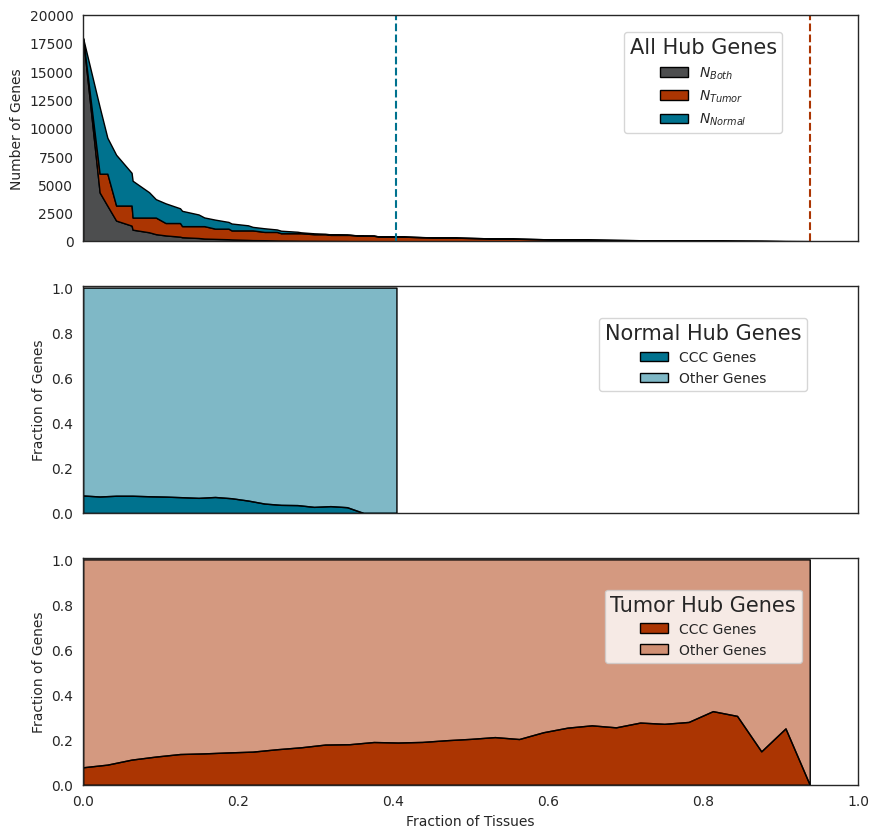

In [8]:
all_nodes, normal_nodes, tumor_nodes = plot_node_analysis(df, metric='degree', save_path='/home/lnemati/pathway_crosstalk/results/figures/hubs/area_hubs.pdf')

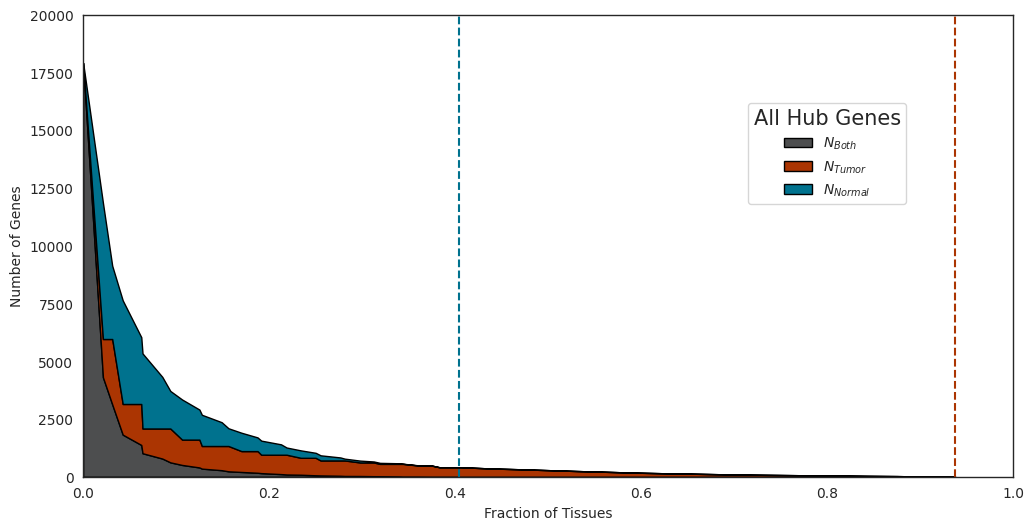

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_only_one_node_analysis(panel, df, metric='degree', save_path=None):
    """
    Plot hub analysis for different metrics, such as 'degree', 'betweenness', etc.

    Parameters:
    - df: DataFrame containing the data.
    - metric: String, the metric to use for the plot. Default is 'degree'.
    - graycolor, tcolor, tcolor2, ncolor, ncolor2: Colors for the plots.
    - save_path: Path to save the plot. If None, the plot will not be saved.
    """
    
    panel = list(panel)
    
    # Generate column names based on the metric
    tumor_col = f'f_{metric}_tumor'
    normal_col = f'f_{metric}_normal'

    # Convert columns to numeric (ensuring proper conversion)
    df[tumor_col] = pd.to_numeric(df[tumor_col], errors='coerce')
    df[normal_col] = pd.to_numeric(df[normal_col], errors='coerce')

    # Init Tumor Hubs DataFrame
    tumor_hub_values = df[tumor_col].dropna().unique()  # Drop NaNs before sorting
    tumor_hub_df = pd.DataFrame(index=sorted(tumor_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

    # Init Normal Hubs DataFrame
    normal_hub_values = df[normal_col].dropna().unique()  # Drop NaNs before sorting
    normal_hub_df = pd.DataFrame(index=sorted(normal_hub_values, reverse=True), columns=['CCC', 'Other Genes'])

    # Init All Hubs DataFrame
    all_hub_values = set(normal_hub_values).union(tumor_hub_values)
    all_hub_df = pd.DataFrame(index=sorted(all_hub_values, reverse=True), columns=['Tumor', 'Normal', 'Both'])

    # Prepare Tumor Hubs DataFrame
    for value in tumor_hub_df.index:
        tumor_hub_df.loc[value, 'CCC'] = ((df[tumor_col] >= value) & (df['interactor'] == 1)).sum()
        tumor_hub_df.loc[value, 'Other Genes'] = ((df[tumor_col] >= value) & (df['interactor'] == 0)).sum()

    # Prepare Normal Hubs DataFrame
    for value in normal_hub_df.index:
        normal_hub_df.loc[value, 'CCC'] = ((df[normal_col] >= value) & (df['interactor'] == 1)).sum()
        normal_hub_df.loc[value, 'Other Genes'] = ((df[normal_col] >= value) & (df['interactor'] == 0)).sum()

    # Prepare All Hubs DataFrame
    for value in all_hub_df.index:
        all_hub_df.loc[value, 'Both'] = ((df[normal_col] >= value) & (df[tumor_col] >= value)).sum()
        all_hub_df.loc[value, 'Normal'] = (df[normal_col] >= value).sum() - all_hub_df.loc[value, 'Both']
        all_hub_df.loc[value, 'Tumor'] = (df[tumor_col] >= value).sum() - all_hub_df.loc[value, 'Both']

    # Normalize frequencies in Tumor and Normal Hubs DataFrame
    tumor_hub_df = tumor_hub_df.div(tumor_hub_df.sum(axis=1), axis=0)
    normal_hub_df = normal_hub_df.div(normal_hub_df.sum(axis=1), axis=0)

    # Ensure all values are numeric
    tumor_hub_df = tumor_hub_df.astype(np.float64)
    normal_hub_df = normal_hub_df.astype(np.float64)
    all_hub_df = all_hub_df.astype(np.float64)

    # Define x values
    normal_hub_x = normal_hub_df.index
    tumor_hub_x = tumor_hub_df.index
    all_hub_x = all_hub_df.index

    # Create the figure and the layout
    axs = {}
    if len(panel) == 1:
        fig, ax = plt.subplots(1,1, figsize=(12, 6))
    
    if panel == [2,3]:
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 6))
    
    # Add legends
    loc = 'center'
    bbox = (0.8, 0.7)
    
    if panel == [1]:
        axs['A'] = ax 
            
        # Plot All Hubs using plt.stackplot
        axs['A'].stackplot(all_hub_x, all_hub_df['Both'], all_hub_df['Tumor'], all_hub_df['Normal'],
                      colors=[graycolor, tcolor, ncolor], edgecolor='black', linewidth=1)
        axs['A'].vlines(x=df[tumor_col].max(),  ymin=0, ymax=2e4, color=tcolor, linestyle='--')
        axs['A'].vlines(x=df[normal_col].max(), ymin=0, ymax=2e4, color=ncolor, linestyle='--')
        axs['A'].set_ylabel('Number of Genes')
        axs['A'].grid(False)
        
        axs['A'].legend(['$N_{Both}$', '$N_{Tumor}$', '$N_{Normal}$'], title='All Hub Genes', bbox_to_anchor=bbox, loc=loc)
        
        axs['A'].set_xlabel('Fraction of Tissues')

        axs['A'].set_xlim(0, 1)
        axs['A'].set_ylim(0, 20000)
        #axs['A'].set_xticks([])

    if panel == [2]:
        axs['B'] = ax
        
        # Plot Normal Hubs using plt.stackplot
        axs['B'].stackplot(normal_hub_x, normal_hub_df['CCC'], normal_hub_df['Other Genes'],
                      colors=[ncolor, ncolor2], edgecolor='black', linewidth=1)
        axs['B'].set_ylabel('Fraction of Genes')
        axs['B'].grid(False)
        
        axs['B'].legend(['CCC Genes', 'Other Genes'], title='Normal Hub Genes', bbox_to_anchor=bbox, loc=loc)
        axs['B'].set_xlim(0, 1)
        axs['B'].set_ylim(0, 1.005)
        #axs['B'].set_xticks([])

    if panel == [3]:
        axs['C'] = ax
        
        # Plot Tumor Hubs using plt.stackplot
        axs['C'].stackplot(tumor_hub_x, tumor_hub_df['CCC'], tumor_hub_df['Other Genes'],
                      colors=[tcolor, tcolor2], edgecolor='black')
        axs['C'].set_xlabel('Fraction of Tissues')
        axs['C'].set_ylabel('Fraction of Genes')
        axs['C'].grid(False)

        axs['C'].legend(['CCC Genes', 'Other Genes'], title='Tumor Hub Genes', bbox_to_anchor=bbox, loc=loc)

        axs['C'].set_xlim(0, 1)
        axs['C'].set_ylim(0, 1.005)

    if panel == [2, 3]:
        axs['B'] = ax1
        axs['C'] = ax2
        
        # Plot Normal Hubs using plt.stackplot
        axs['B'].stackplot(normal_hub_x, normal_hub_df['CCC'], normal_hub_df['Other Genes'],
                      colors=[ncolor, ncolor2], edgecolor='black', linewidth=1)
        axs['B'].set_ylabel('Fraction of Genes')
        axs['B'].grid(False)
        
        axs['B'].legend(['CCC Genes', 'Other Genes'], title='Normal Hub Genes', bbox_to_anchor=bbox, loc=loc)
        axs['B'].set_xlim(0, 1)
        axs['B'].set_ylim(0, 1.005)
        
        # Plot Tumor Hubs using plt.stackplot
        axs['C'].stackplot(tumor_hub_x, tumor_hub_df['CCC'], tumor_hub_df['Other Genes'],
                      colors=[tcolor, tcolor2], edgecolor='black')
        axs['C'].set_xlabel('Fraction of Tissues')
        axs['C'].set_ylabel('Fraction of Genes')
        axs['C'].grid(False)

        axs['C'].legend(['CCC Genes', 'Other Genes'], title='Tumor Hub Genes', bbox_to_anchor=bbox, loc=loc)

        axs['C'].set_xlim(0, 1)
        axs['C'].set_ylim(0, 1.005)




    # Adjust layout to remove space between plots
    # plt.tight_layout()



    

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    
    return
# Example usage:
# plot_hub_analysis(df, metric='betweenness', save_path='/path/to/save/plot.pdf')

plot_only_one_node_analysis([1], df, save_path='/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_panel_1.pdf')

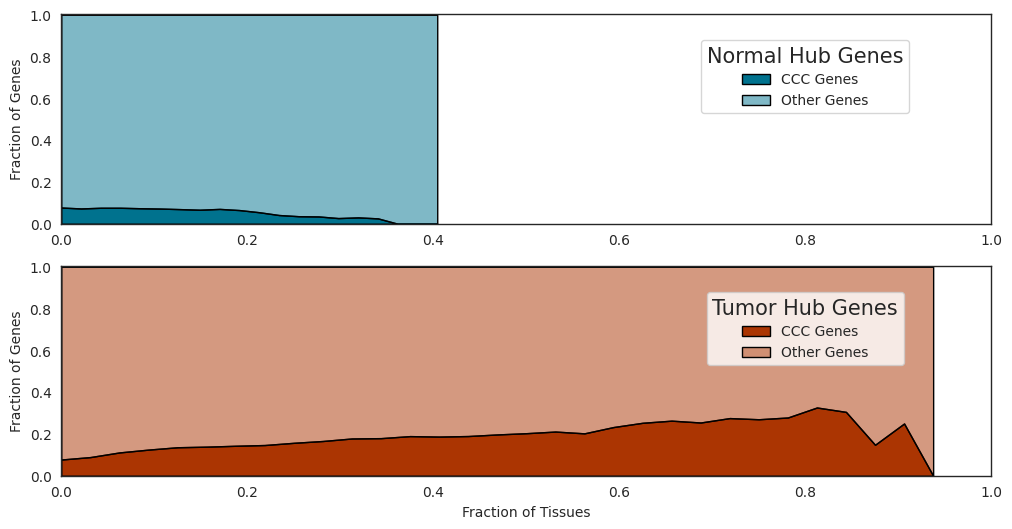

In [10]:
plot_only_one_node_analysis([2, 3], df, save_path='/home/lnemati/pathway_crosstalk/results/figures/hubs/hubs_panel_2_3.pdf')

In [40]:
name2id = pd.read_csv('/home/lnemati/resources/reactome/ReactomeIDs.tsv', sep='\t', header=None, index_col=0).to_dict()[1]
id2name = {v: k for k, v in name2id.items()}

roots = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')

roots['root'] = roots.root.map(id2name)
roots['pathway'] = roots.pathway.map(id2name)

pw2root = roots.set_index('pathway')['root'].to_dict()

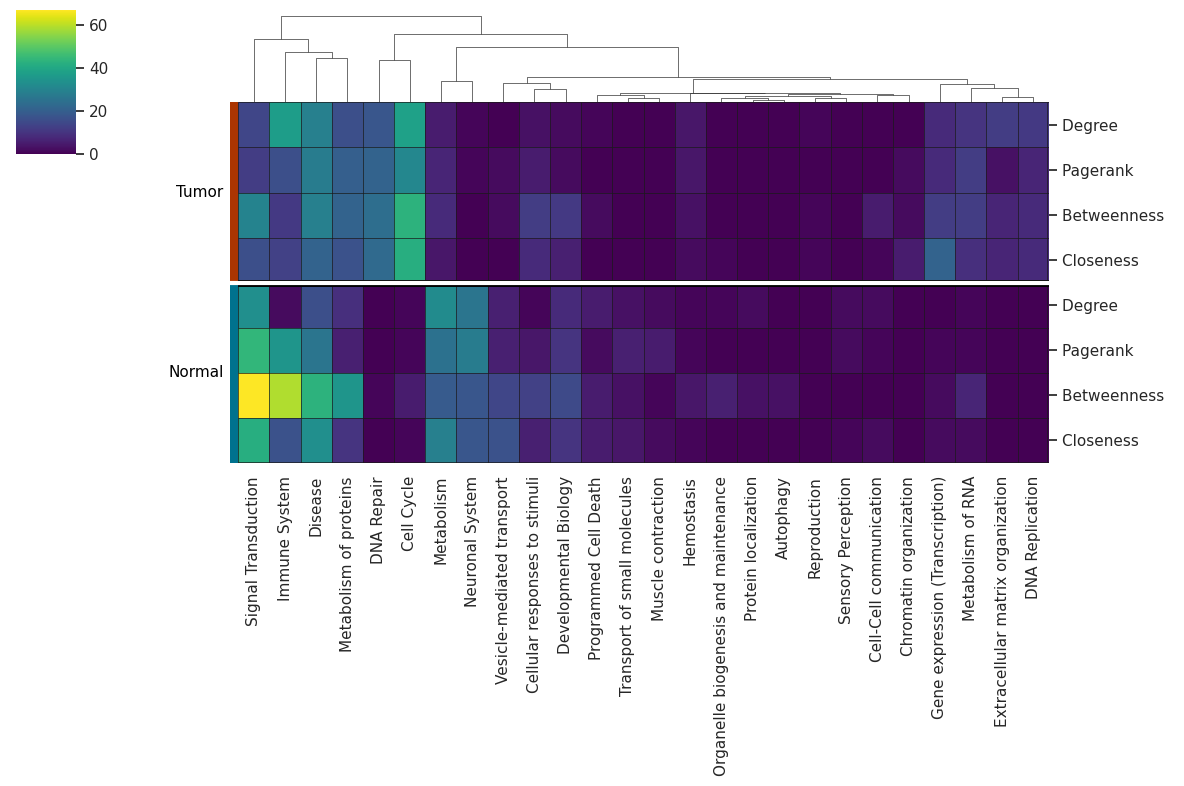

In [115]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap='viridis'

# Assuming pw2root is already defined
path = '/home/lnemati/pathway_crosstalk/results/hubs/enrichment/reactome/all_hubs'

metrics = []
all_roots = set()
t_counts = {}
n_counts = {}

for directory in os.listdir(path):
    if directory == 'clustering_local':
        continue
    
    metric = directory
    metrics.append(metric)
    
    t_enr = os.path.join(path, metric, 'enrichment_tumor.csv')
    t_enr = pd.read_csv(t_enr)
    t_counts[metric] = t_enr.Term.map(pw2root).value_counts()
    
    n_enr = os.path.join(path, metric, 'enrichment_normal.csv')
    n_enr = pd.read_csv(n_enr)
    n_counts[metric] = n_enr.Term.map(pw2root).value_counts() 

    all_roots.update(t_counts[metric].index, n_counts[metric].index)
    
all_roots = list(all_roots)

# Make matrix with metrics as columns and roots as rows
# Each metric has a tumor and normal column
cols = [metric + '_tumor' for metric in metrics] + [metric + '_normal' for metric in metrics]
root_counts = pd.DataFrame(0, index=all_roots, columns=cols)

# Fill in matrix, leave 0 where no data
for metric in metrics:
    root_counts.loc[t_counts[metric].index, f'{metric}_tumor'] = t_counts[metric]
    root_counts.loc[n_counts[metric].index, f'{metric}_normal'] = n_counts[metric]

# Create a dictionary mapping of condition to color
condition_colors = {'tumor': tcolor, 'normal': ncolor}

# Create a list of conditions based on column names
conditions = ['tumor' if 'tumor' in col else 'normal' for col in root_counts.columns]

# Change _tumor and _normal to one or two spaces so that it can't be seen in the plot
root_counts.columns = [col.replace('_tumor', ' ').replace('_normal', '  ') for col in root_counts.columns]
# Capitalize
root_counts.columns = [col[0].upper() + col[1:] for col in root_counts.columns]

# Create a DataFrame for row_colors with the conditions
row_colors_df = pd.DataFrame(conditions, index=root_counts.columns, columns=[''])

# Map the conditions to their respective colors
row_colors = row_colors_df[''].map(condition_colors)

# Plot the clustermap with row colors
g = sns.clustermap(
    root_counts.T,
    cmap=cmap,
    #cbar_pos=(.9, .1, .05, .25),
    figsize=(12, 8),
    row_cluster=False,
    row_colors=row_colors,
    colors_ratio=1/(2*len(all_roots))
)

# Add the "Tumor" and "Normal" labels next to the row colors
# Find the middle of the rows corresponding to "tumor" and "normal" conditions
row_positions = [i for i, cond in enumerate(conditions) if cond == 'tumor']
tumor_mid = sum(row_positions) / len(row_positions) + 0.5
row_positions = [i for i, cond in enumerate(conditions) if cond == 'normal']
normal_mid = sum(row_positions) / len(row_positions) + 0.5

# Add text to the left of the row colors
g.ax_row_colors.text(-0.8, tumor_mid, 'Tumor', va='center', ha='right', fontsize=11, color='black')
g.ax_row_colors.text(-0.8, normal_mid, 'Normal', va='center', ha='right', fontsize=11, color='black')

# Adjust plot limits and spacing to fit the text
g.ax_row_colors.set_xlim(-1.5, 1)

# Add white line between Tumor and Normal
wide_lw = 5
separator = row_colors.value_counts().values[:-1]

g.ax_heatmap.hlines(separator, -1, g.ax_heatmap.get_xlim()[1], color='black', linewidth=wide_lw, zorder=10)

g.ax_heatmap.hlines(separator, -1, g.ax_heatmap.get_xlim()[1], color='white', linewidth=wide_lw-2, zorder=20)
g.ax_row_colors.hlines(separator, *g.ax_row_colors.get_xlim(), color='white', linewidth=wide_lw-2, zorder=20)

# Add black outline
separators1 = list(range(root_counts.shape[0]))
separators1 = separators1 + [max(separators1) + 0.95]
separators2 = list(range(root_counts.shape[1]))
separators2 = separators2 + [max(separators2) + 0.99]
g.ax_heatmap.vlines(separators1, *g.ax_heatmap.get_ylim(), color='k', linewidth=0.5, zorder=1)
g.ax_heatmap.hlines(separators2, *g.ax_heatmap.get_xlim(), color='k', linewidth=0.5, zorder=1)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/pw_heatmap.pdf', bbox_inches="tight")

plt.show()


In [43]:
genes_scores = pd.read_csv('/home/lnemati/pathway_crosstalk/results/hubs/n_tissues_top_node_metrics.csv', index_col=0)

In [101]:
# Initialize an empty dictionary to hold odds ratios for each metric
odds_ratios_dict = {}

path = '/home/lnemati/pathway_crosstalk/results/hubs/enrichment/hallmarks/all_hubs'

for metric in metrics:

    # TUMOR
    tumor_genes = genes_scores[
        (genes_scores['f_{}'.format(metric) + '_tumor'] > genes_scores['f_{}'.format(metric) + '_normal'])
    ].index.tolist()

    t_enr = os.path.join(path, metric, 'enrichment_tumor.csv')
    t_enr = pd.read_csv(t_enr).set_index('Term')

    t_hub_hallmarks = t_enr.apply(lambda x: len(x['Genes'].split(';')), axis=1)
    t_hub_not_hallmarks = len(tumor_genes) - t_hub_hallmarks

    t_odds = t_hub_hallmarks / t_hub_not_hallmarks

    # NORMAL
    normal_genes = genes_scores[
        (genes_scores['f_{}'.format(metric) + '_tumor'] < genes_scores['f_{}'.format(metric) + '_normal'])
    ].index.tolist()

    n_enr = os.path.join(path, metric, 'enrichment_normal.csv')
    n_enr = pd.read_csv(n_enr).set_index('Term')

    n_hub_hallmarks = n_enr.apply(lambda x: len(x['Genes'].split(';')), axis=1)
    n_hub_not_hallmarks = len(normal_genes) - n_hub_hallmarks

    n_odds = n_hub_hallmarks / n_hub_not_hallmarks

    # Calculate odds ratio for each hallmark
    odds_ratio = t_odds / n_odds

    # Store odds ratios for each hallmark in a dictionary
    odds_ratios_dict[metric] = odds_ratio

# Convert the dictionary into a pandas DataFrame
odds_ratios_df = pd.DataFrame(odds_ratios_dict)
log_odds_ratios_df = np.log2(odds_ratios_df)
log_odds_ratios_df.index.name = None

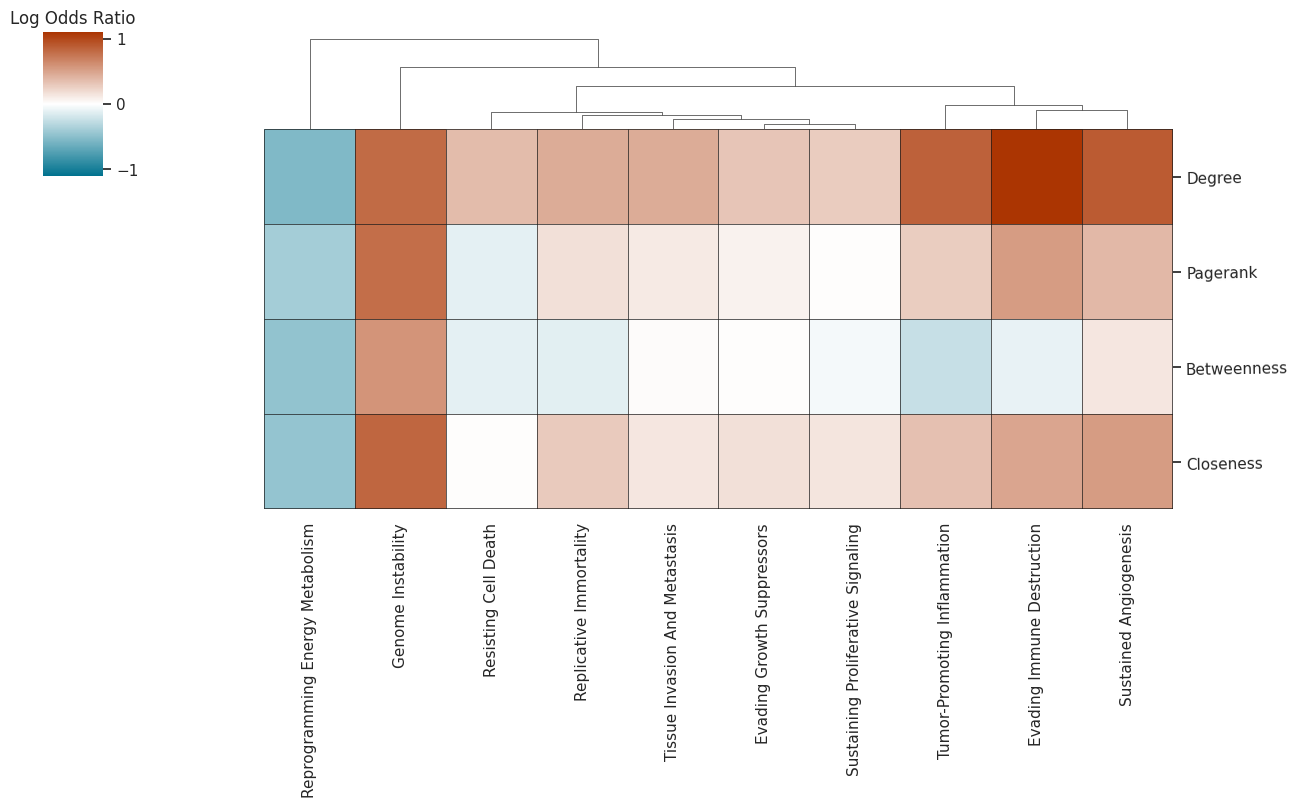

In [113]:
cmap = LinearSegmentedColormap.from_list("", [ncolor, 'white', tcolor])

matrix = log_odds_ratios_df.T
matrix.index.name = ' '

matrix.columns = [col.title() for col in matrix.columns]
matrix.index   = [idx.title() for idx in matrix.index  ]

g = sns.clustermap(
    matrix,
    cmap=cmap,
    #cbar_pos=(.0, .071, .05, .25),
    figsize=(12, 8),
    row_cluster=False,
    #col_cluster=False,
    #row_colors=row_colors,
    #colors_ratio=1/(2*len(all_roots)),
    vmin=-1.1,
    vmax=1.1
)

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=1)  # Adjust the rotation as needed

# Add black outline
separators1 = list(range(matrix.shape[1]))
separators1 = separators1 + [max(separators1) + 0.99]
separators2 = list(range(matrix.shape[0]))
separators2 = separators2 + [max(separators2) + 0.99]
g.ax_heatmap.vlines(separators1, *g.ax_heatmap.get_ylim(), color='k', linewidth=0.5, zorder=1)
g.ax_heatmap.hlines(separators2, *g.ax_heatmap.get_xlim(), color='k', linewidth=0.5, zorder=1)

plt.title('Log Odds Ratio')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/hubs/hallmarks_odds_heatmap.pdf', bbox_inches="tight")

In [32]:
# Try hubs connected to pws insted of pw enrichment

In [24]:
def find_files(filename, search_path):
    result = []
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result

def hub_connectivities(filename):
    
    # Example usage:
    search_path = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal'
    matches = find_files(filename, search_path)    

    pw_genes   = {}
    name_to_id = {}
    id_to_name = {}

    with open('/home/lnemati/resources/reactome/ReactomePathways.gmt', 'r') as f:
        for line in f.readlines():
            line = line.split('\t')
            name_to_id[line[0]] = line[1]
            id_to_name[line[1]] = line[0]
            pw_genes[line[0]] = line[2:]

    root_pws = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')
    root_pws = root_pws['root'].map(id_to_name).unique()

    ndf = pd.DataFrame(columns=root_pws)
    tdf = pd.DataFrame(columns=root_pws)

    for match in matches:
        if '/normal/' in match:
            row = pd.read_csv(match, index_col=0).T
            row['subtissue'] = [match.split('/')[-2]]
            row['tissue'] = [match.split('/')[-4]]
            ndf = pd.concat([ndf, row])
        elif '/tumor/' in match:
            row = pd.read_csv(match, index_col=0).T
            row.index = [match.split('/')[-2]]
            row['subtissue'] = [match.split('/')[-2]]
            row['tissue'] = [match.split('/')[-4]]
            tdf = pd.concat([tdf, row])

    ndf = ndf.set_index('subtissue', drop=True)
    tdf = tdf.set_index('subtissue', drop=True)

    ndf = ndf.groupby('tissue').median()
    tdf = tdf.groupby('tissue').median()

    ndf['condition'] = 'normal'
    tdf['condition'] = 'tumor'
    
    df = pd.concat([ndf, tdf])

    # Reshape the DataFrame to a long format suitable for violin plots
    df = pd.melt(df, id_vars=['condition'], var_name='Pathway', value_name='Connectivity')
    #df_long['Connectivity'] = np.log(df_long['Connectivity'])

    order = df.groupby('Pathway').mean().sort_values(by='Connectivity', ascending=False).index
    
    # Initialize an empty dictionary to store the results
    pvals = {}

    # Get unique pathways
    pathways = df['Pathway'].unique()

    # Loop through each pathway
    for pathway in pathways:
        # Subset the data for the current pathway
        subset = df[df['Pathway'] == pathway]

        # Split into normal and tumor conditions
        normal = subset[subset['condition'] == 'normal']['Connectivity']
        tumor = subset[subset['condition'] == 'tumor']['Connectivity']

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(normal, tumor, alternative='two-sided')

        # Store the p-value in the dictionary with pathway as the key
        pvals[pathway] = p_value

    # Convert the dictionary to a pandas Series
    pvals = pd.Series(pvals, name='pvals')
    pvals = pvals.loc[order]
    pvals.loc[order] = false_discovery_control(pvals, method='bh')

    return df, pvals

In [25]:
df, pvals = hub_connectivities('hubs_connectivities_all.csv')

In [26]:
df = df.groupby(['Pathway', 'condition']).median()

In [27]:
pvals.loc[df_pivot.pathway]

Pathway
2-LTR circle formation                                             0.834530
5-Phosphoribose 1-diphosphate biosynthesis                         0.002320
A tetrasaccharide linker sequence is required for GAG synthesis    0.283834
ABC transporter disorders                                          0.159102
ABC transporters in lipid homeostasis                              0.119567
                                                                     ...   
tamatinib-resistant FLT3 mutants                                   1.000000
tandutinib-resistant FLT3 mutants                                  1.000000
trans-Golgi Network Vesicle Budding                                0.005767
vRNA Synthesis                                                     0.033610
vRNP Assembly                                                      0.009846
Name: pvals, Length: 2681, dtype: float64

In [33]:
df_pivot = df.pivot_table(index='Pathway', columns='condition', values='Connectivity').reset_index()
df_pivot.columns = ['pathway', 'normal_median', 'tumor_median']
df_pivot = df_pivot.set_index('pathway')
df_pivot['pval_adj'] = pvals.loc[df_pivot.index]

df_pivot =  df_pivot.sort_values(by='pval_adj')

df_pivot.head()

normal_median  tumor_median  pval_adj
pathway                                                                 
Costimulation by the CD28 family        0.003132      0.017631  0.000019
Signaling by Retinoic Acid              0.002139      0.000447  0.000019
CD28 dependent PI3K/Akt signaling       0.000952      0.003903  0.000019
Pyruvate metabolism                     0.004510      0.001152  0.000019
Triglyceride metabolism                 0.002414      0.000703  0.000020

In [34]:
df_pivot.to_csv('/home/lnemati/pathway_crosstalk/results/hubs/hubs_connectivities_all.csv')

In [31]:
sum(pvals.sort_values() < 0.05)

641

In [28]:
for i, pw in enumerate(pvals.sort_values().head(20).index):
    print(i, pw)

0 Signaling by Retinoic Acid
1 Pyruvate metabolism
2 CD28 dependent PI3K/Akt signaling
3 Costimulation by the CD28 family
4 Binding and entry of HIV virion
5 Triglyceride metabolism
6 Phosphorylation of CD3 and TCR zeta chains
7 PD-1 signaling
8 Metabolism of lipids
9 Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell
10 Translocation of ZAP-70 to Immunological synapse
11 Generation of second messenger molecules
12 Late SARS-CoV-2 Infection Events
13 Adaptive Immune System
14 PDH complex synthesizes acetyl-CoA from PYR
15 Sphingolipid de novo biosynthesis
16 Chemokine receptors bind chemokines
17 Glycerophospholipid biosynthesis
18 Carnitine metabolism
19 Post NMDA receptor activation events


In [78]:
def plot_pathway_connectivity(df, pvals, savepath=None, significance=None):
    """
    Plots the pathway connectivity for normal and tumor groups and adds significance bars.
    
    Arguments:
    df : DataFrame
        The dataframe containing the data for plotting. It must have 'Pathway', 'Connectivity', and 'condition' columns.
    pvals : Series
        A Series where the index is the pathway names and the values are the p-values.
    savepath : str, optional
        The path where the plot will be saved. If None, the plot will not be saved. Default is None.
    significance : float or None, optional
        The maximum p-value to consider a pathway significant. If None, plot all pathways. Default is None.
    """
    
    # Define a function to add significance stars
    def add_significance_bar(x1, x2, y, h, significance, ax):
        """
        Add significance bar with stars between two boxplots.

        x1, x2: Positions of the two groups (normal/tumor).
        y: Height where the bar is placed.
        h: Height of the bar itself.
        significance: The star to place based on p-value.
        ax: The axis object to annotate on.
        """
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
        ax.text((x1 + x2) * .5, y + h, significance, ha='center', va='bottom', color='black')

    # Initialize the plot size
    plt.figure(figsize=(10, 6))

    # Filter pathways based on the significance threshold if provided
    if significance is not None:
        significant_pathways = pvals[pvals < significance].index
        df = df[df['Pathway'].isin(significant_pathways)]
        order = significant_pathways
    else:
        order = pvals.index

    # Create the boxplot
    palette = {'normal': ncolor, 'tumor': tcolor}  # assume ncolor and tcolor are pre-defined
    ax = sns.boxplot(
        x='Pathway',
        y='Connectivity',
        hue='condition',
        data=df,
        order=order,
        palette=palette,
        showfliers=False,
    )

    plt.ylabel('Connectivity')
    plt.xticks(rotation=90)

    # Add significance bars and stars for each pathway
    for i, pathway in enumerate(order):
        # Get the p-value for the current pathway from the pvals Series
        pval = pvals[pathway]

        # Determine significance level
        if pval < 0.001:
            stars = '***'
        elif pval < 0.01:
            stars = '**'
        elif pval < 0.05:
            stars = '*'
        else:
            stars = 'ns'  # no significance

        # Find the maximum y-value for the current pathway to position the bars
        y_max = df[df['Pathway'] == pathway]['Connectivity'].max()

        # Get positions of normal and tumor groups (the boxplot positions)
        width = 0.4
        x1 = i - width  # position of normal (left side)
        x2 = i + width  # position of tumor (right side)

        # Add the significance bar if it's below the significance threshold (if provided)
        if stars != 'ns' and (significance is None or pval < significance):
            add_significance_bar(x1, x2, y_max + 0.01, 0.02, stars, ax)

    # Adjust layout to fit labels
    plt.ylim(0, 0.58)

    # Save the plot
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')

    # Show the plot
    plt.show()


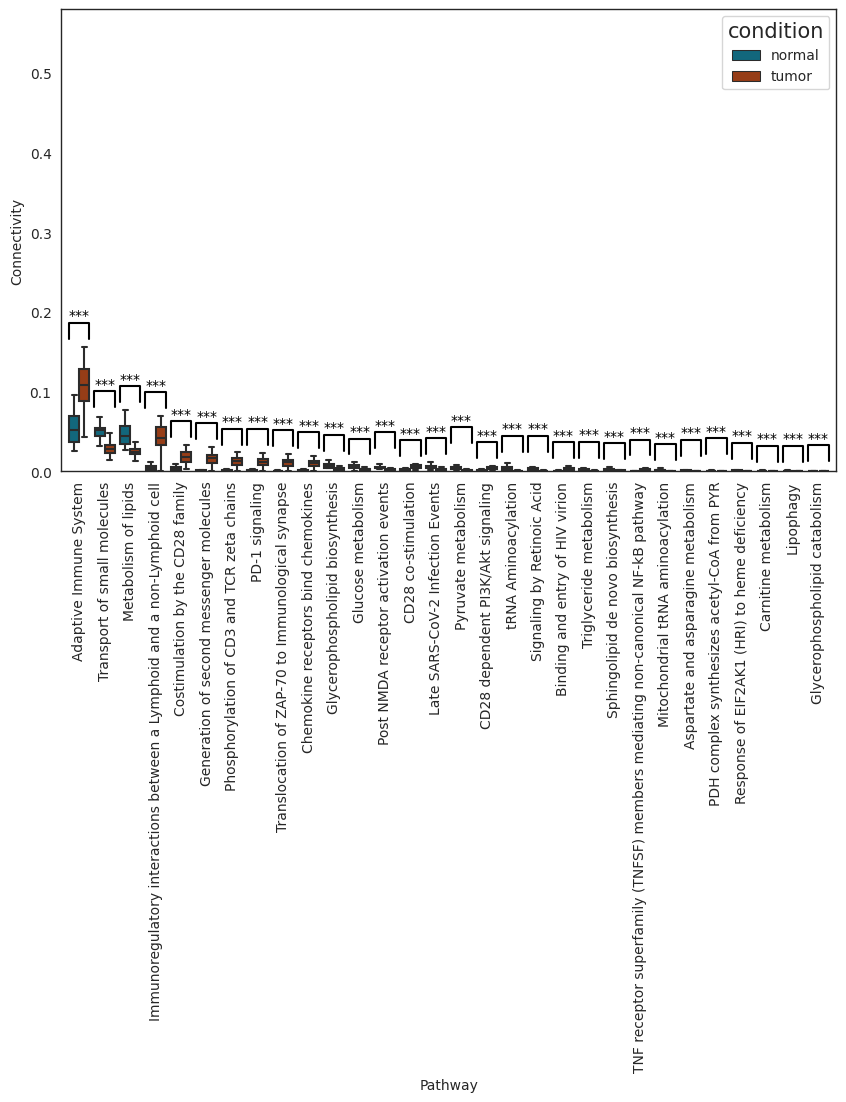

In [83]:
plot_pathway_connectivity(df, pvals, significance=5e-5)

In [46]:
tdf.mean()

Hemostasis                               4270.912763
Neuronal System                          1309.967664
Developmental Biology                    4728.641630
Metabolism                               6187.209892
Reproduction                              244.598637
Extracellular matrix organization        2585.236776
Cell-Cell communication                   623.944947
Signal Transduction                     11918.355038
Cell Cycle                               1962.701643
Disease                                  7947.733961
Immune System                           13805.074068
Organelle biogenesis and maintenance      674.443691
Transport of small molecules             2094.507959
Metabolism of proteins                   6615.933787
Muscle contraction                        951.417082
Circadian Clock                           192.005313
Chromatin organization                    325.713574
Programmed Cell Death                     804.870777
Vesicle-mediated transport               2421.

In [225]:
adj = '/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/pancreas/tumor/pancreatic_adenocarcinoma/adjacency.csv.gz'
adj = pd.read_csv(adj, index_col=0)
np.fill_diagonal(adj.values, 1)

hubs = list(adj.sum().sort_values(ascending=False).iloc[:round(0.05 * len(adj))].index)

In [261]:
for pw in root_pws:
    print(pw)
    genes = list(set(pw_genes[pw]).intersection(adj.columns))
    tot = np.sum(adj.loc[hubs, genes].values)
    print(tot)

Hemostasis
2323.3446196754326
Neuronal System
1203.9393990993285
Developmental Biology
2598.5842206828265
Metabolism
3379.1427617302256
Reproduction
123.37712089302073
Extracellular matrix organization
1553.177971740065
Cell-Cell communication
316.7138279112287
Signal Transduction
6550.080485405918
Cell Cycle
604.3455731905674
Disease
4214.566723836082
Immune System
7282.814302567795
Organelle biogenesis and maintenance
366.9995748803622
Transport of small molecules
1262.3266905925097
Metabolism of proteins
3936.898969763702
Muscle contraction
559.2444386460074
Circadian Clock
80.70506153182191
Chromatin organization
143.78119588974823
Programmed Cell Death
294.3344340759629
Vesicle-mediated transport
1661.3066319038433
DNA Replication
105.78441011361701
DNA Repair
404.49753761612715
Gene expression (Transcription)
1905.6553303190822
Metabolism of RNA
1077.1404145508686
Cellular responses to stimuli
1158.7967052593826
Digestion and absorption
1.637215986194416
Protein localization
313.

In [246]:
tot

6097.964977953204

# Interactions enrichment

In [97]:
name2id = pd.read_csv('/home/lnemati/resources/reactome/ReactomeIDs.tsv', sep='\t', header=None, index_col=0).to_dict()[1]
id2name = {v: k for k, v in name2id.items()}

roots = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')

roots['root'] = roots.root.map(id2name)
roots['pathway'] = roots.pathway.map(id2name)

pw2root = roots.set_index('pathway')['root'].to_dict()

In [98]:
tdf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/mannwhitneyu/mannwhitneyu_min_tumor_enrichment.csv')

In [102]:
ndf = pd.read_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/mannwhitneyu/mannwhitneyu_min_normal_enrichment.csv')

# Compare

In [5]:
from scipy.stats import false_discovery_control
from scipy.stats import sem
from scipy import stats

In [6]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/compare_results.csv', index_col=0)
df = df.drop(columns=['avg_coev_tom_correlation'])

In [13]:
df[df['modularity'] < 0.3]['modularity'].sort_values()

name
testis                                   0.054892
colon_transverse                         0.206424
heart_left_ventricle                     0.239598
brain_cortex                             0.241315
brain_caudate_basal_ganglia              0.255689
kidney_cortex                            0.259091
brain_nucleus_accumbens_basal_ganglia    0.274479
rectum_adenocarcinoma                    0.278666
adrenocortical_cancer                    0.282483
lung_squamous_cell_carcinoma             0.297960
Name: modularity, dtype: float64

In [11]:
df['interactions_mannwhitneyu_p_adj'] = stats.false_discovery_control(df['interactions_mannwhitneyu_p'], method='bh')

In [12]:
auroc_a = df['interactions_auroc']
auroc_t = df.query('condition == "tumor"')['interactions_auroc']
auroc_n = df.query('condition == "normal"')['interactions_auroc']

print('AUROC')

print('All tissues:', auroc_a.mean(), '+/-', np.std(auroc_a))
print('Normal', auroc_n.mean(), '+/-', np.std(auroc_n))
print('Tumor', auroc_t.mean(), '+/-', np.std(auroc_t))

ua = df['interactions_mannwhitneyu_U']
ut = df.query('condition == "tumor"')['interactions_mannwhitneyu_U']
un = df.query('condition == "normal"')['interactions_mannwhitneyu_U']
#print()
#
#print('Mann-Whitney U')
#
#
#print('All tissues:', ua.mean(), '+/-', sem(ua))
#print('Normal', un.mean(), '+/-', sem(un))
#print('Tumor', ut.mean(), '+/-', sem(ut))

AUROC
All tissues: 0.6103896637308337 +/- 0.0368408026208443
Normal 0.5881180230039456 +/- 0.01957211204041014
Tumor 0.6431011360484509 +/- 0.03145614205515242


In [13]:
df['-log10_mannwhitneyu_p_adj'] = -np.log10(df['interactions_mannwhitneyu_p_adj'])

In [14]:
df.drop(columns='interactions_mannwhitneyu_p', inplace=True)
df.drop(columns='interactions_mannwhitneyu_p_adj', inplace=True)

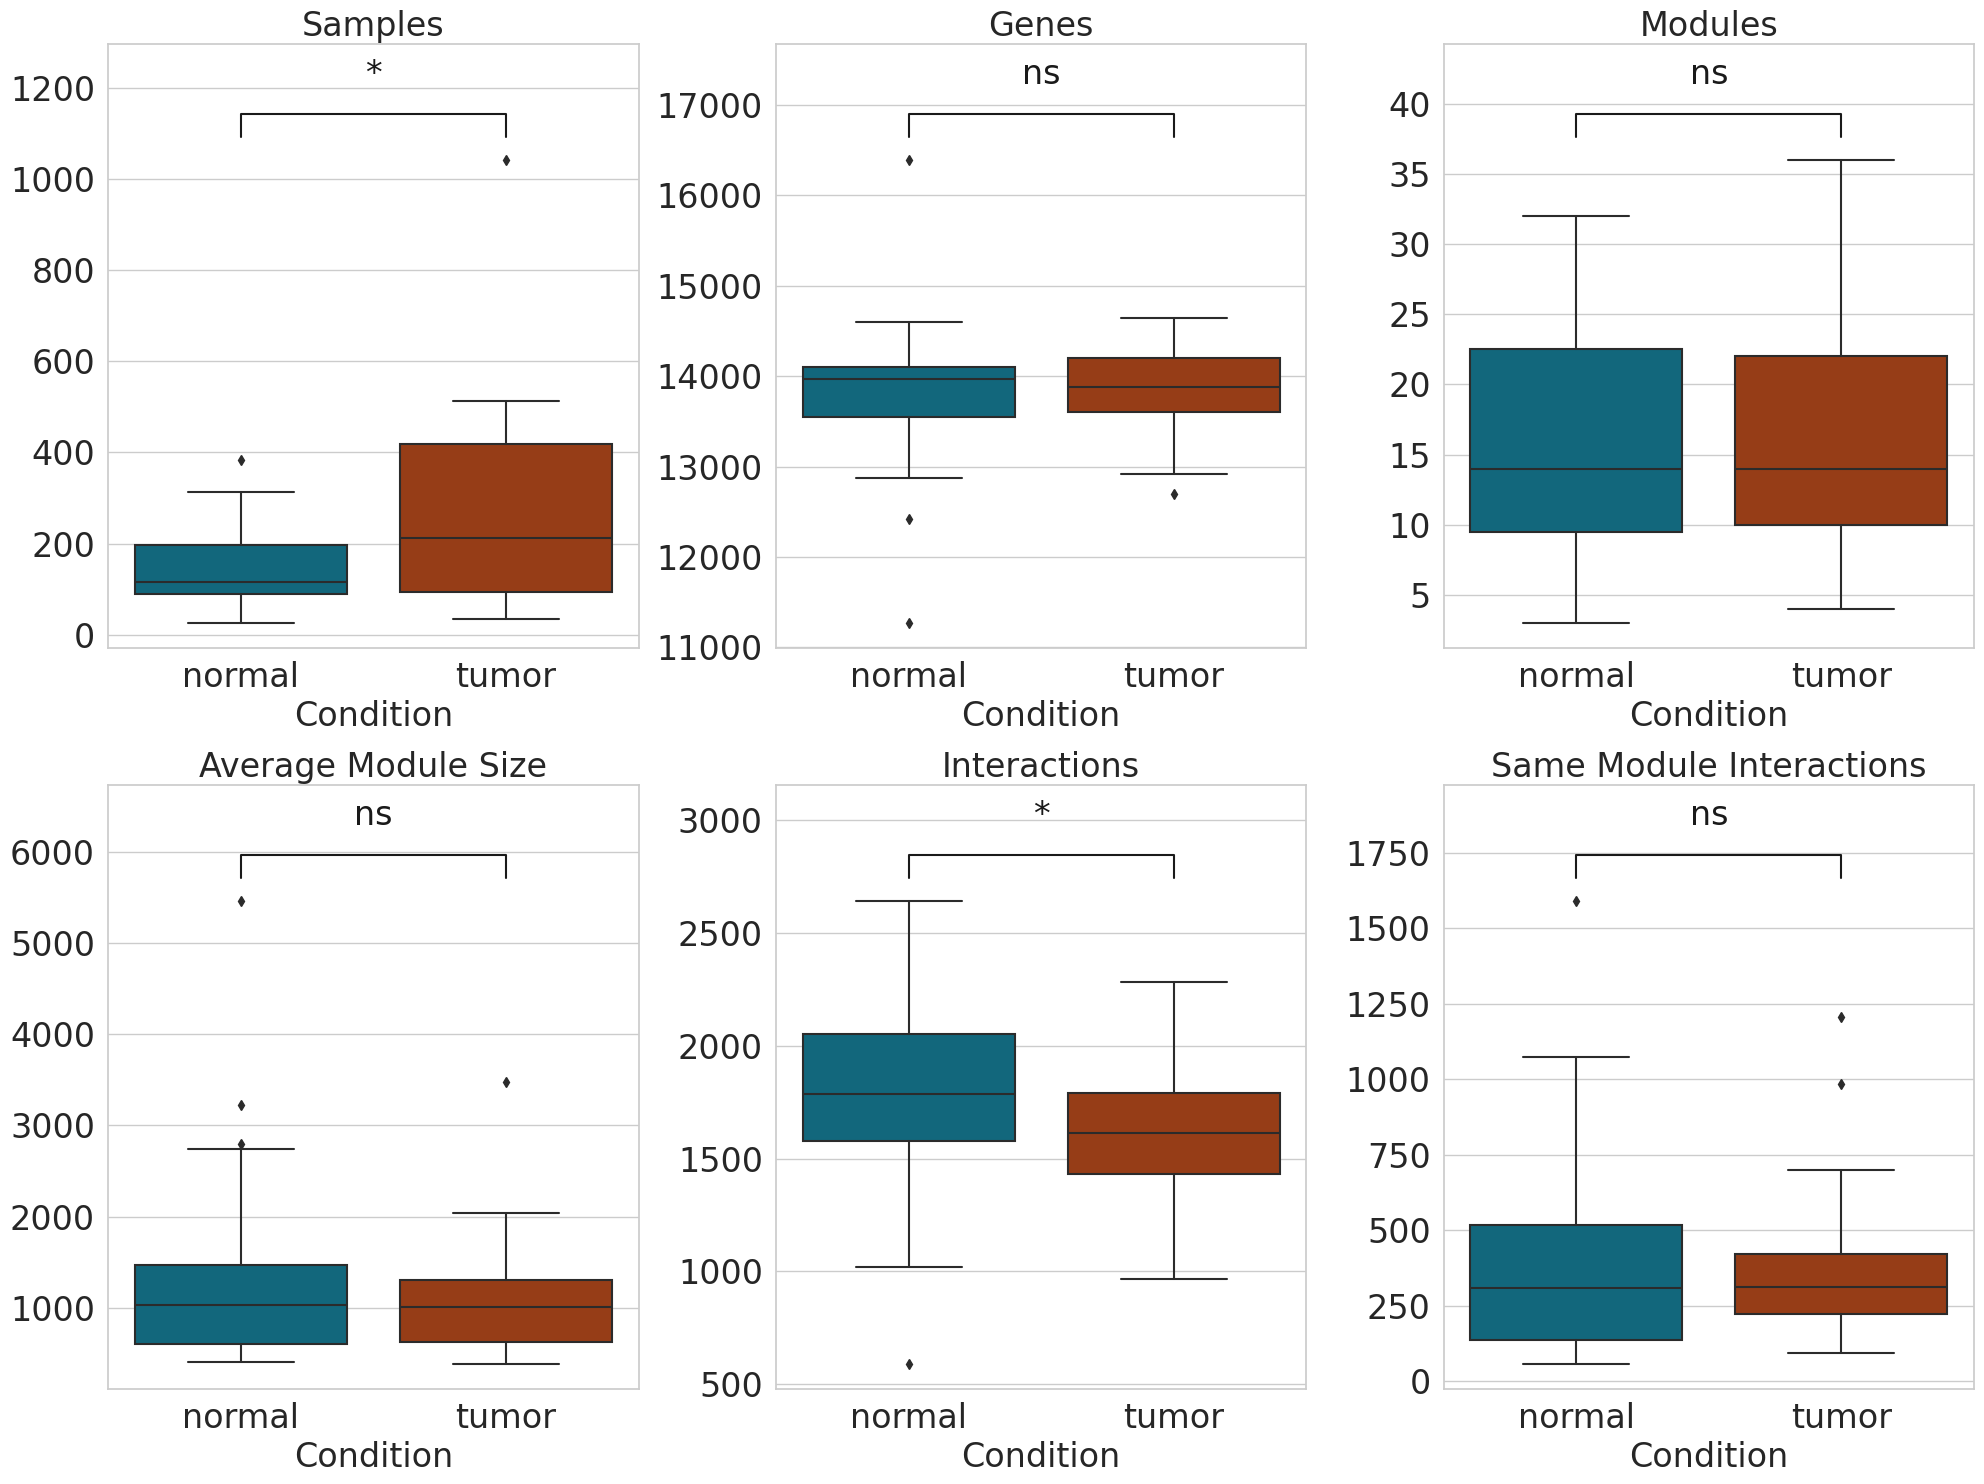

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
title_dict = {
    'n_samples': 'Samples',
    'n_genes': 'Genes',
    'n_modules': 'Modules',
    'avg_module_size': 'Average Module Size',
    #'avg_degree': 'Average Degree',
    #'avg_intramodular_degree': 'Average Intramodular Degree',
    'tot_interactions': 'Interactions',
    'n_interactions_same_module': 'Same Module Interactions',
    #'interactions_auroc': 'AUROC',
    #'interactions_mannwhitneyu_U': 'Mann-Whitney $U$',
    #'-log10_mannwhitneyu_p_adj': 'Mann-Whitney $-log_{10}{p_{adj}}$',
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 24

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = stats.false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column
plt.figure(figsize=(20, 15))  # Adjusted figure size for better spacing

subplot_shape = (2,3)

# Plot the countplot for 'condition'
#plt.subplot(subplot_shape[0], subplot_shape[1], 1)
#sns.countplot(x='condition', data=df, palette=[ncolor, tcolor])
#plt.title('Tissues', fontsize=fs)
#plt.xlabel('Condition', fontsize=fs)
#plt.ylabel('', fontsize=fs)
#plt.xticks(fontsize=fs)
#plt.yticks(fontsize=fs)

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    plt.subplot(subplot_shape[0], subplot_shape[1], i + 1)
    ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Add significance bars
    add_significance(ax, df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_all.pdf')

# Show the plot
plt.show()


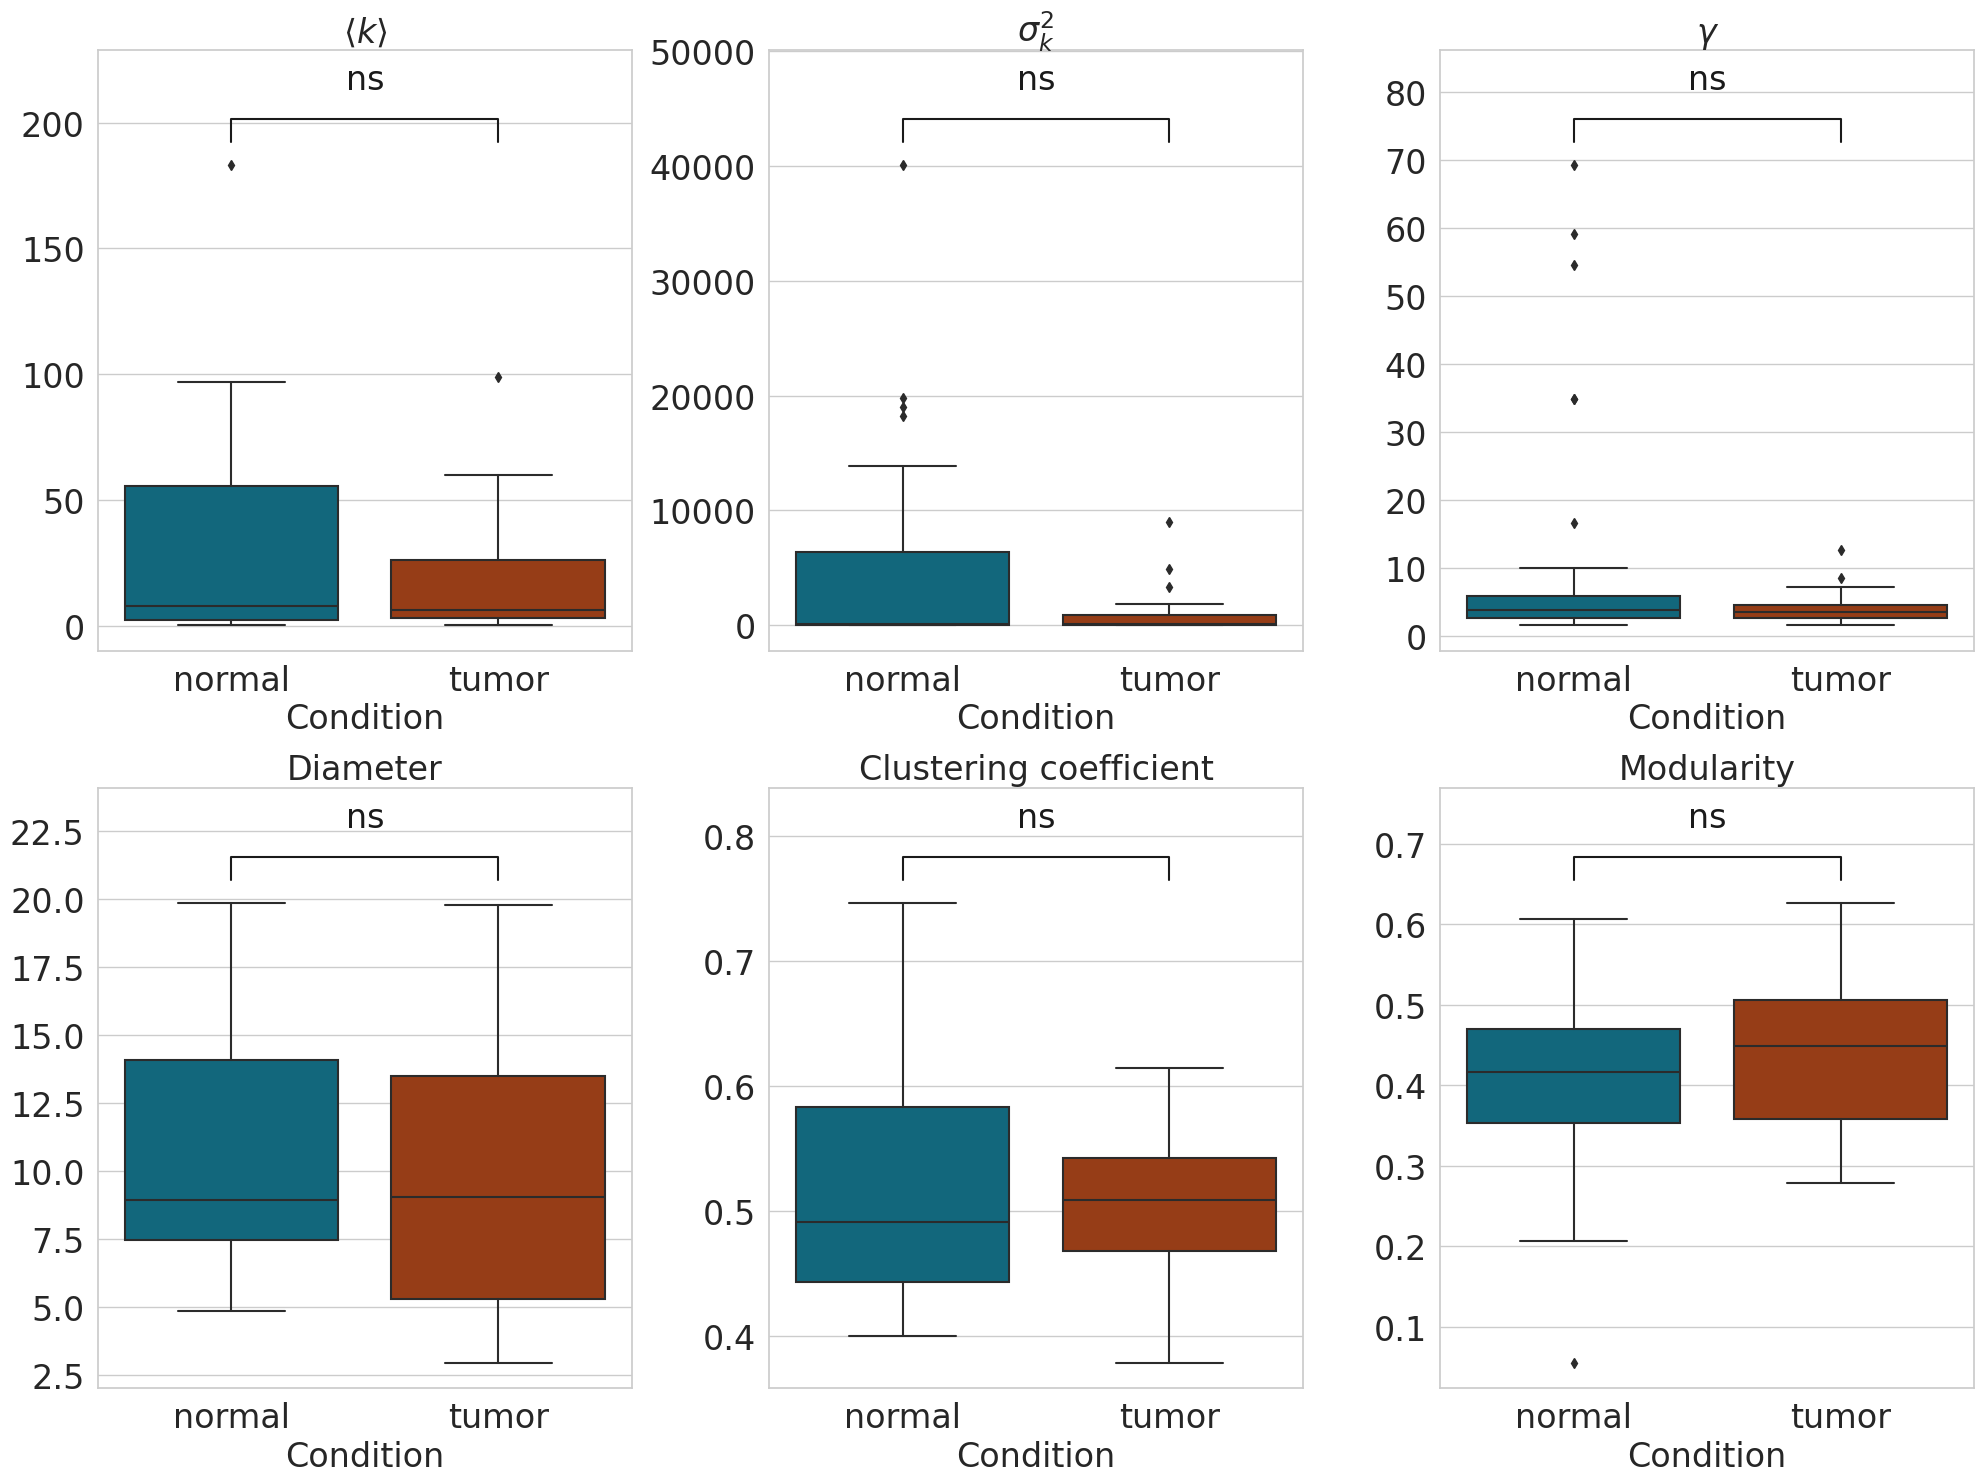

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Title dictionary for subplots
# Title dictionary for subplots
title_dict = {
    'avg_degree': '$ \langle k \\rangle $',
    #'avg_intramodular_degree': 'avg_intramodular_degree',
    'var_degree': '$ \sigma^2_{k}$',
    #'var_intramodular_degree': 'variance_intramodular',
    'powerlaw_alpha': '$\gamma$',
    #'avg_shortest_path': 'avg_path_length',
    'diameter': 'Diameter',
    'clustering_global': 'Clustering coefficient',
    'modularity': 'Modularity',
    #'powerlaw_xmin': 'xmin',
    #'powerlaw_sigma': 'sigma'
}

# Set the style
sns.set(style="whitegrid")

# Define font size
fs = 24

# Function to perform Mann-Whitney U test and return p-value
def compute_p_value(data, column):
    """Compute p-value for Mann-Whitney U test."""
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    _, p_value = mannwhitneyu(normal_data, tumor_data, alternative='two-sided')
    return p_value

# Function to add significance bars to the boxplot
def add_significance(ax, data, column, p_value):
    """ Adds significance bars to the given axes object based on p-value. """
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = 'ns'  # Not significant

    # Calculate maximum y-value and add space for significance bar
    normal_data = data[data['condition'] == 'normal'][column]
    tumor_data = data[data['condition'] == 'tumor'][column]
    y_max = max(normal_data.max(), tumor_data.max())
    y_min = min(normal_data.min(), tumor_data.min())
    y_offset = 0.2 * (y_max - y_min if y_max > y_min else 1)

    h = 0.05 * (y_max - y_min)  # Height of the significance bar
    y_bar_start = y_max + h
    y_bar_end = y_max + 2 * h

    x1, x2 = 0, 1
    col = 'k'

    # Plot the significance bar
    ax.plot([x1, x1, x2, x2], [y_bar_start, y_bar_end, y_bar_end, y_bar_start], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y_bar_end + h, significance, ha='center', va='bottom', color=col, fontsize=fs)

    # Update the y-axis limit to make space for the significance bar
    ax.set_ylim(top=y_bar_end + h * 3)  # Adding extra space to avoid overlap with titles

# Define columns to plot based on the title_dict
columns = list(title_dict.keys())

# Collect p-values for FDR correction
p_values = [compute_p_value(df, column) for column in columns]

# Apply FDR correction
#p_values = stats.false_discovery_control(p_values, method='bh')

# Create a dictionary of corrected p-values
p_value_dict = dict(zip(columns, p_values))

# Plot boxplots for each column
plt.figure(figsize=(20, 15))  # Adjusted figure size for better spacing

subplot_shape = (2,3)

# Plot boxplots for each column in the title_dict
for i, column in enumerate(columns):
    plt.subplot(subplot_shape[0], subplot_shape[1], i + 1)
    ax = sns.boxplot(x='condition', y=column, data=df, palette=[ncolor, tcolor])
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Add significance bars
    add_significance(ax, df, column, p_value_dict[column])

plt.tight_layout()

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_networks.pdf')

# Show the plot
plt.show()

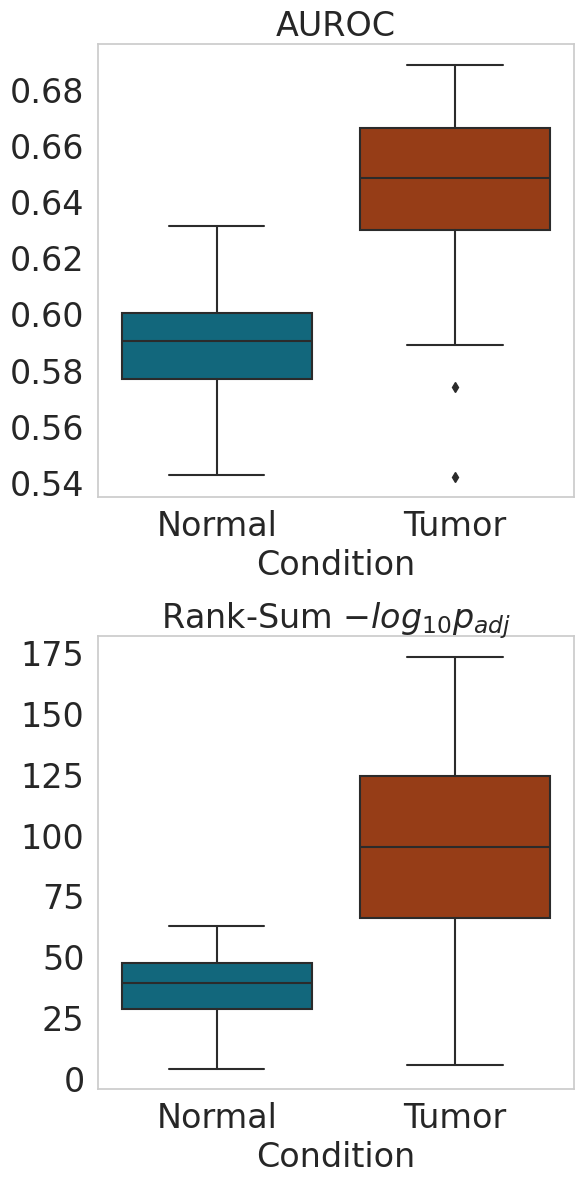

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid", {'axes.grid': False})

# Define font size
fs = 24

# Plot boxplots for each column
plt.figure(figsize=(6, 12))  # Adjust the figure size to accommodate smaller vertical subplots

title_dict = {
    'interactions_auroc': 'AUROC',
    #'interactions_mannwhitneyu_U': 'Rank-Sum $U$',
    '-log10_mannwhitneyu_p_adj': 'Rank-Sum $-log_{10}{p_{adj}}$',
}

for i, column in enumerate(title_dict.keys()):
    plt.subplot(len(title_dict), 1, i + 1)  # Change the subplot to vertical arrangement
    sns.boxplot(x='condition', y=column, data=df.replace({'normal': 'Normal', 'tumor': 'Tumor'}), palette=[ncolor, tcolor])
    plt.title(title_dict[column], fontsize=fs)
    plt.xlabel('Condition', fontsize=fs)
    plt.ylabel('', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

plt.tight_layout()

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_mannwhitneyu_auroc.pdf')

# Show the plot
plt.show()


In [14]:
# COEVOLUTION

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu
from itertools import combinations, product

# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
    name=None,
):
    # ROC curve using all gene pairs
    fpr, tpr, _ = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, auroc

def update_diff_complex(
    all_pairs,
    genes_series_a,
    genes_series_b
):
    for genes_a, genes_b in zip(genes_series_a, genes_series_b):
        for pair in product(genes_a, genes_b):
            gene_a, gene_b = pair
            if pair in all_pairs.index:
                all_pairs.loc[pair, "interaction"] = 1
            elif (gene_b, gene_a) in all_pairs.index:
                all_pairs.loc[(gene_b, gene_a), "interaction"] = 1
    return

print("Reading interactions.csv")
# read interactions.csv 
interactions = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv')
coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)

# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

# make all_interacting_genes a list containing all unique genes in the interactions
all_interacting_genes = list(set().union(*interactions_all_genes))
print("Number of interacting genes: ", len(all_interacting_genes))

# ----- ROC all gene pairs -----

print("Generating ROC curves")

print("coev has shape: ", coev.shape)

# flatten TOM matrix, remove diagonal and duplicated values
print("Flattening coev matrix")
all_pairs = pd.DataFrame(
    coev.where(
        np.tri(
            coev.shape[0],
            dtype=bool,
            k=-1
        ),
        np.nan
    ).stack(dropna=True), columns=["coev"]
)
print("all_pairs has now shape: ", all_pairs.shape)

all_pairs['interaction'] = 0

update_diff_complex(all_pairs, complex_a_genes, complex_b_genes)

print("Total number of interacting pairs: ", all_pairs["interaction"].sum())

# Diff complex interactions
coev_fpr, coev_tpr, coev_auroc = generate_roc_curve(
    data=all_pairs,
    target_col="interaction",
    feature_col="coev",
    name='Coevoulution'
)

print('auroc:', auroc)

Reading interactions.csv
Number of interacting genes:  1576
Generating ROC curves
coev has shape:  (17756, 17756)
Flattening coev matrix
all_pairs has now shape:  (157628890, 1)
Total number of interacting pairs:  3467
auroc: 0.6639019087494823


In [17]:
coev_fpr, coev_tpr, coev_auroc = (fpr, tpr, auroc)

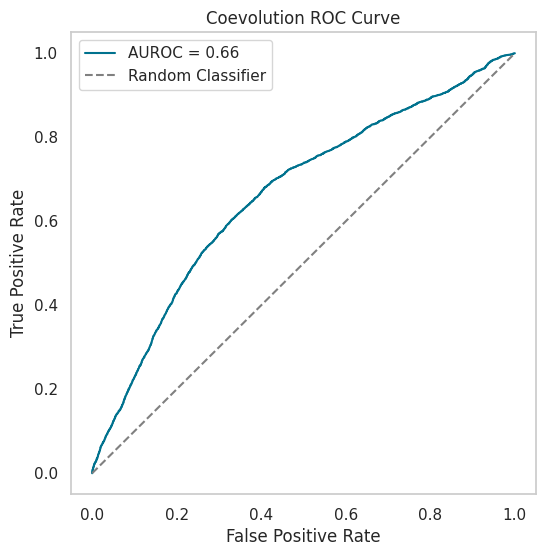

In [18]:
plt.figure(figsize=(6, 6))
plt.plot(coev_fpr, coev_tpr, label=f'AUROC = {coev_auroc:.2f}', color=ncolor)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Coevolution ROC Curve')
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()


In [16]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_data(x_data, y_data, new_x):
    """
    Interpolate y_data to match new_x using linear interpolation.

    Parameters:
    x_data : array-like
        The original x data points.
    y_data : array-like
        The original y data points corresponding to x_data.
    new_x : array-like
        The new x data points for which we want to compute interpolated y values.

    Returns:
    new_x : array-like
        The input new_x values (unchanged).
    new_y : array-like
        The interpolated y values corresponding to new_x.
    """
    # Create an interpolation function
    interpolation_func = interp1d(x_data, y_data, kind='linear', fill_value="extrapolate")
    
    # Compute new_y by applying the interpolation function to new_x
    new_y = interpolation_func(new_x)
    
    return new_x, new_y


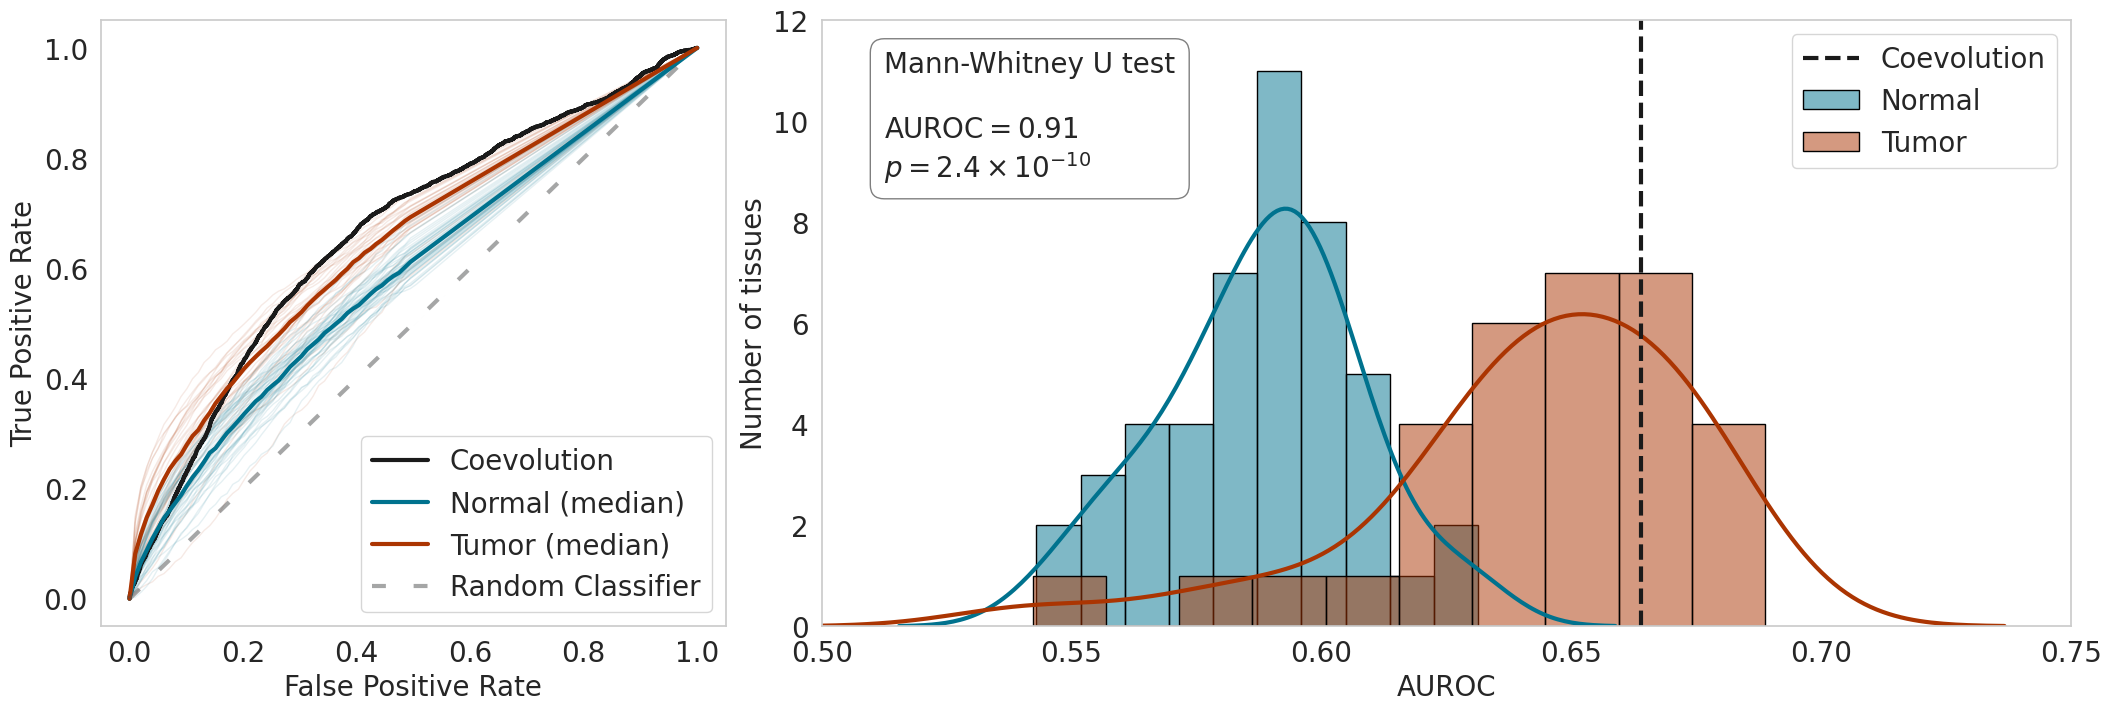

In [62]:
# Define font size
fs = 20

# Data Preparation for AUROC
col = 'interactions_auroc'
normal_data = df.loc[df.condition == 'normal', col]
tumor_data = df.loc[df.condition == 'tumor', col]

# Perform Mann-Whitney U test
u_statistic, mannwhitney_p_value = stats.mannwhitneyu(tumor_data, normal_data, alternative='greater')

# Create the figure
fig = plt.figure(layout="constrained", figsize=(21, 7))

axs = fig.subplot_mosaic(
    """
    ABB
    """
)

lw = 3
cut = 3
alpha=0.5
bins=10


# ----- PLOT A (ROC) ------

xx = np.linspace(0,1,100)

path = '/home/lnemati/pathway_crosstalk/results/roc/tumor'
t_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=tcolor, linestyle='-', lw=1, alpha=0.1)
    
    t_yy.append(yy)
    
t_median = np.median(np.array(t_yy), axis=0)

path = '/home/lnemati/pathway_crosstalk/results/roc/normal'
n_yy = []

for tissue in os.listdir(path):
    fpr = np.load(os.path.join(path, tissue, 'fpr.npy'))
    tpr = np.load(os.path.join(path, tissue, 'tpr.npy'))
    
    xx, yy = interpolate_data(fpr, tpr, xx)
    axs['A'].plot(xx, yy, color=ncolor, linestyle='-', lw=1, alpha=0.1)
    
    n_yy.append(yy)
    
n_median = np.median(np.array(n_yy), axis=0)

axs['A'].plot(coev_fpr, coev_tpr, label=f'Coevolution', color='k', lw=lw)
axs['A'].plot(xx, n_median, color=ncolor, label=f'Normal (median)', lw=lw)
axs['A'].plot(xx, t_median, color=tcolor, label=f'Tumor (median)', lw=lw)
axs['A'].plot(xx, xx, color=graycolor2, label=f'Random Classifier', linestyle=(0, (3.33, 6.66)), lw=lw)

# ----- PLOT B (COMPARISON) ------

# Plot histograms for AUROC with outlines
sns.histplot(normal_data,
        bins=bins,
        kde=True,
        color=ncolor,
        edgecolor='black',
        label='Normal',
        alpha=alpha,
        kde_kws={'cut': cut},
        line_kws={'linewidth': lw, 'color': ncolor},
        ax=axs['B'])
sns.histplot(tumor_data,
        bins=bins,
        kde=True,
        color=tcolor,
        edgecolor='black',
        label='Tumor',
        alpha=alpha,
        kde_kws={'cut': cut},
        line_kws={'linewidth': lw, 'color': tcolor},
        ax=axs['B'])

axs['B'].vlines(x=auroc,ymin=0, ymax=100, colors='k', linestyles='--', label='Coevolution', lw=3)

axs['A'].set_xlabel('False Positive Rate', fontsize=fs)
axs['A'].set_ylabel('True Positive Rate', fontsize=fs)
axs['A'].legend(fontsize=fs)
axs['A'].tick_params(axis='both', labelsize=fs)

axs['B'].set_xlabel('AUROC', fontsize=fs)
axs['B'].set_ylabel('Number of tissues', fontsize=fs)
axs['B'].legend(fontsize=fs)
axs['B'].tick_params(axis='both', labelsize=fs)

# Add text box for Mann-Whitney U test results with transparency
u_str = str(int(u_statistic))
p_str = str(str(f"{mannwhitney_p_value:.1e}"))[:3] + '\\times 10^{' + str(mannwhitney_p_value).split('e')[-1] + '}'

auroc_t_vs_n = round(u_statistic / (tumor_data.shape[0] * normal_data.shape[0]), 2)

textstr = f"Mann-Whitney U test\n\nAUROC$={auroc_t_vs_n}$\n$p={p_str}$"
props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.5)
axs['B'].text(0.05, 0.95, textstr, transform=axs['B'].transAxes, fontsize=fs, verticalalignment='top', bbox=props)

axs['B'].set_xlim(0.5, 0.75)
axs['B'].set_ylim(0, 12)

#plt.tight_layout()

# Save the figure
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_auroc_histogram.pdf', bbox_inches='tight')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/comparison_auroc_histogram.png', bbox_inches='tight')

# Show the plot
plt.show()


In [105]:
interactions = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv')

In [106]:
# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

In [107]:
adj = pd.read_csv('/projects/bioinformatics/DB/Xena/TCGA_GTEX/by_tissue_primary_vs_normal/testis/normal/testis/adjacency.csv.gz', index_col=0)

In [108]:
all_ccc_genes = list(set().union(*interactions_all_genes))
all_ccc_genes = adj.index.intersection(all_ccc_genes)
adj = adj.loc[all_ccc_genes, all_ccc_genes]

In [109]:
adj = (adj + adj.T) / 2

In [110]:
from scipy.spatial.distance import squareform

In [111]:
pairs = stack_triangle(adj, col='adj')

In [112]:
from itertools import product

def update_diff_complex(
    all_pairs,
    genes_series_a,
    genes_series_b,
    col='interaction'
):
    all_pairs[col] = 0
    for genes_a, genes_b in zip(genes_series_a, genes_series_b):
        for pair in product(genes_a, genes_b):
            gene_a, gene_b = pair
            if pair in all_pairs.index:
                all_pairs.loc[pair, col] = 1
            elif (gene_b, gene_a) in all_pairs.index:
                all_pairs.loc[(gene_b, gene_a), col] = 1
    return

In [113]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
    name=None,
):
    # ROC curve using all gene pairs
    fpr, tpr, _ = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, auroc

Real: 0.5439191257950763
Permutation: 0.50644241207532


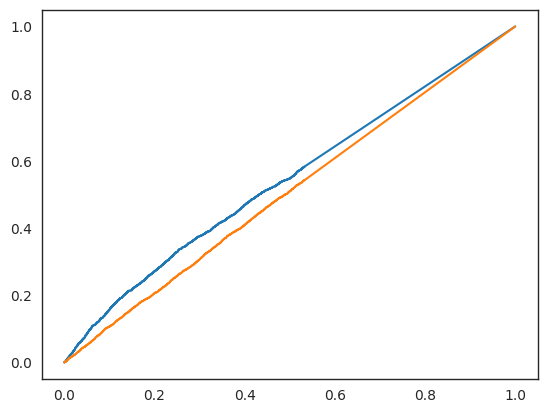

In [122]:
fake = complex_b_genes.sample(frac=1, replace=False).reset_index(drop=True)
update_diff_complex(pairs, complex_a_genes, complex_b_genes, 'interaction')
update_diff_complex(pairs, complex_a_genes, fake, 'permutation')

fpr, tpr, auroc = generate_roc_curve(
    data=pairs,
    target_col="interaction",
    feature_col="adj",
    name='Interactions'
)
print(f'Real: {auroc}')

plt.plot(fpr, tpr)

fpr, tpr, auroc = generate_roc_curve(
    data=pairs,
    target_col="permutation",
    feature_col="adj",
    name='Permutations'
)
print(f'Permutation: {auroc}')

plt.plot(fpr, tpr)

# Violinplots

In [19]:
# Coevolution
coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)
# Tumor consensus
tcorr = pd.read_csv('/home/lnemati/pathway_crosstalk/results/consensus_modules/tumor/median/correlation.csv', index_col=0)
# Normal consensus
ncorr = pd.read_csv('/home/lnemati/pathway_crosstalk/results/consensus_modules/normal/median/correlation.csv', index_col=0)

In [20]:
coev = stack_triangle(coev, 'jaccard')
tcorr = stack_triangle(tcorr, 'corr')
ncorr = stack_triangle(ncorr, 'corr')

In [21]:
from itertools import product

# read interactions.csv 
interactions = pd.read_csv('/projects/bioinformatics/DB/CellCellCommunication/WithEnzymes/cpdb_cellchat_enz.csv')
#coev = pd.read_csv('/home/lnemati/resources/coevolution/jaccard_genes.csv.gz', index_col=0)

# Extract genes for complex A and B for each row
complex_a_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(1, row['num_interactors_a'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
complex_b_genes = interactions.apply(lambda row: list(set([row[f'interactor{i}'] for i in range(row['num_interactors_a'] + 1, row['num_interactors_a'] + row['num_interactors_b'] + 1) if pd.notna(row[f'interactor{i}'])])), axis=1)
interactions_all_genes = complex_a_genes + complex_b_genes

# make all_interacting_genes a list containing all unique genes in the interactions
all_interacting_genes = list(set().union(*interactions_all_genes))

def update_diff_complex(
    coev,
    genes_series_a,
    genes_series_b
):
    coev["interaction"] = 'Other Gene Pairs'
    for genes_a, genes_b in zip(genes_series_a, genes_series_b):
        for pair in product(genes_a, genes_b):
            gene_a, gene_b = pair
            if pair in coev.index:
                coev.loc[pair, "interaction"] = 'CCC Gene Pairs'
            elif (gene_b, gene_a) in coev.index:
                coev.loc[(gene_b, gene_a), "interaction"] = 'CCC Gene Pairs'
    return

update_diff_complex(coev, complex_a_genes, complex_b_genes)
update_diff_complex(tcorr, complex_a_genes, complex_b_genes)
update_diff_complex(ncorr, complex_a_genes, complex_b_genes)

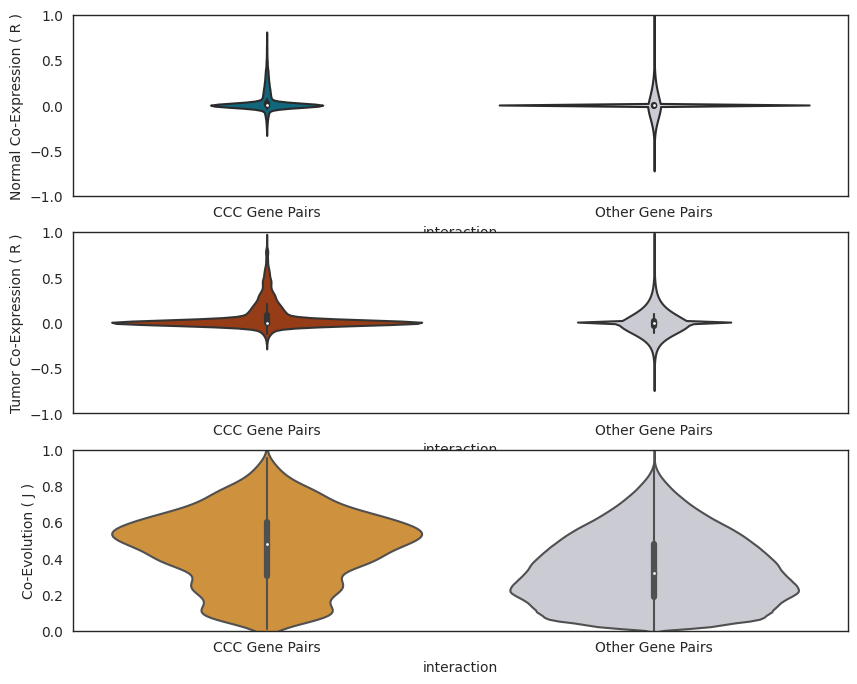

In [22]:
SUBSET = 1

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10, 8))

ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')

sns.violinplot(
    data=ncorr[::SUBSET],
    x="interaction",
    y="corr",
    ax=ax1,
    order=['CCC Gene Pairs', 'Other Gene Pairs'],
    palette=[ncolor, '#C8CAD4']
)
ax1.set_ylabel('Normal Co-Expression ( R )')
ax1.set_ylim(-1,1)
ax1.set_xlabel('')


sns.violinplot(
    data=tcorr[::SUBSET],
    x="interaction",
    y="corr",
    ax=ax2,
    order=['CCC Gene Pairs', 'Other Gene Pairs'],
    palette=[tcolor, '#C8CAD4']
)
ax2.set_ylabel('Tumor Co-Expression ( R )')
ax2.set_ylim(-1,1)
ax3.set_xlabel('')

sns.violinplot(
    data=coev[::SUBSET],
    x="interaction",
    y="jaccard",
    ax=ax3,
    order=['CCC Gene Pairs', 'Other Gene Pairs'],
    palette=[orangecolor, '#C8CAD4']
)
ax3.set_ylabel('Co-Evolution ( J )')
ax3.set_ylim(0,1)
ax3.set_xlabel('')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/violin_ccc_vs_others.png')
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/violin_ccc_vs_others.pdf')

In [31]:
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
fig.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/violin_ccc_vs_others.png', bbox_inches='tight')
fig.savefig('/home/lnemati/pathway_crosstalk/results/figures/comparison/violin_ccc_vs_others.pdf', bbox_inches='tight')

# Interactions Network

In [76]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/interactions_network/interactions_network_filtered.csv')

In [77]:
network['normal_j'] = network['normal_intersection'] / network['normal_union']
network['tumor_j'] = network['tumor_intersection'] / network['tumor_union']

In [78]:
network['-tumor_intersection'] = -network['tumor_intersection']
network['-normal_intersection'] = -network['normal_intersection']

network['-tumor_j'] = -network['tumor_j']
network['-normal_j'] = -network['normal_j']

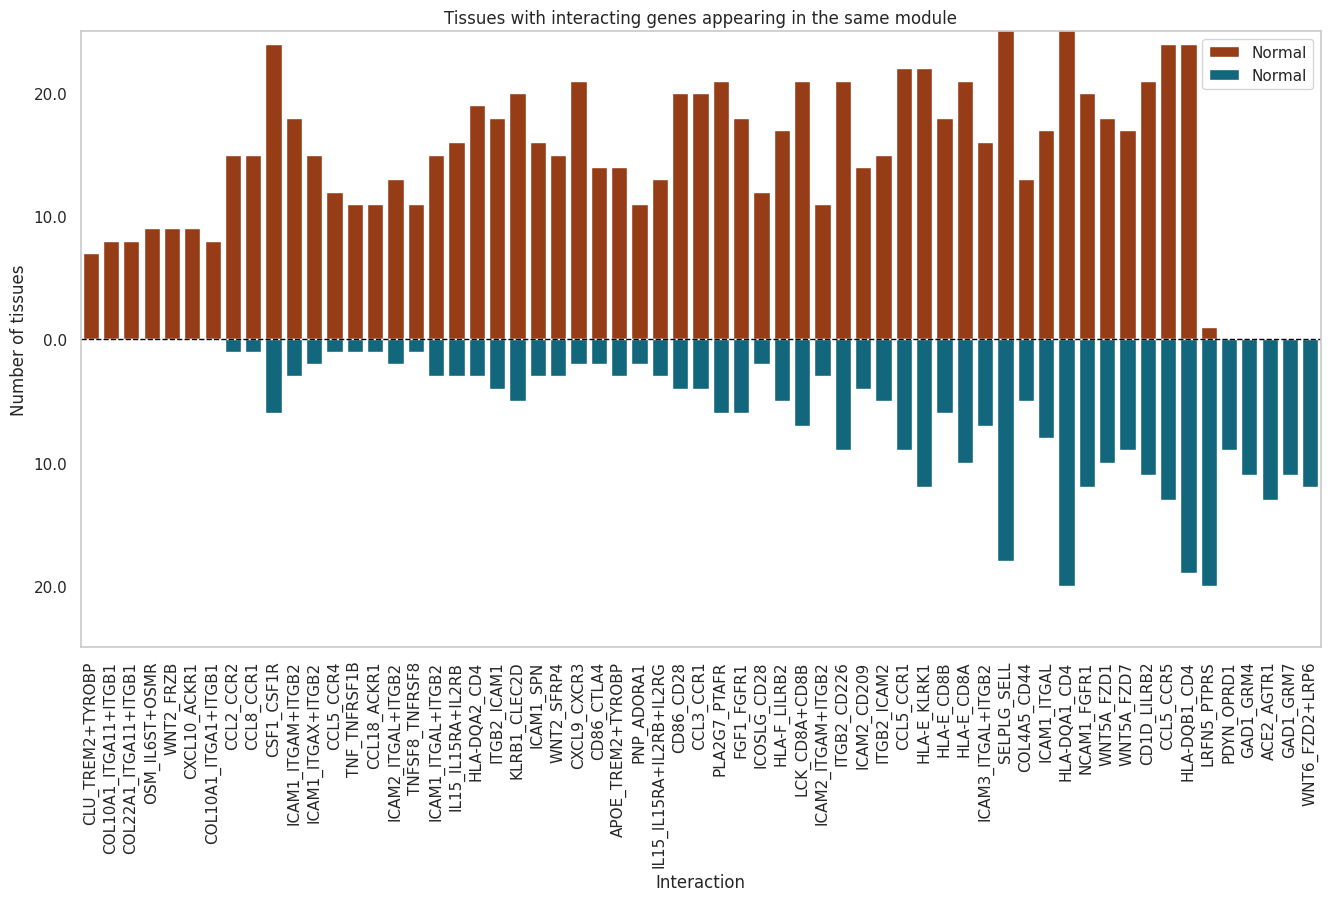

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(ax=ax, x='interaction', y='tumor_intersection', data=network, color=tcolor, alpha=1, label='Normal')
sns.barplot(ax=ax, x='interaction', y='-normal_intersection', data=network, color=ncolor, alpha=1, label='Normal')

ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Adding labels and title for subplot 2
ax.set_xlabel('Interaction')
ax.set_ylabel('')
ax.set_title('Tissues with interacting genes appearing in the same module')
ax.set_ylim(-25, 25)
ax.set_ylabel('Number of tissues')
ax.legend()
ax.tick_params(axis='x', rotation=90)

# Change negative y-axis ticks to positive and display only the first decimal place
ax.set_yticklabels([f'{abs(x):.1f}' for x in ax.get_yticks()])

plt.show()

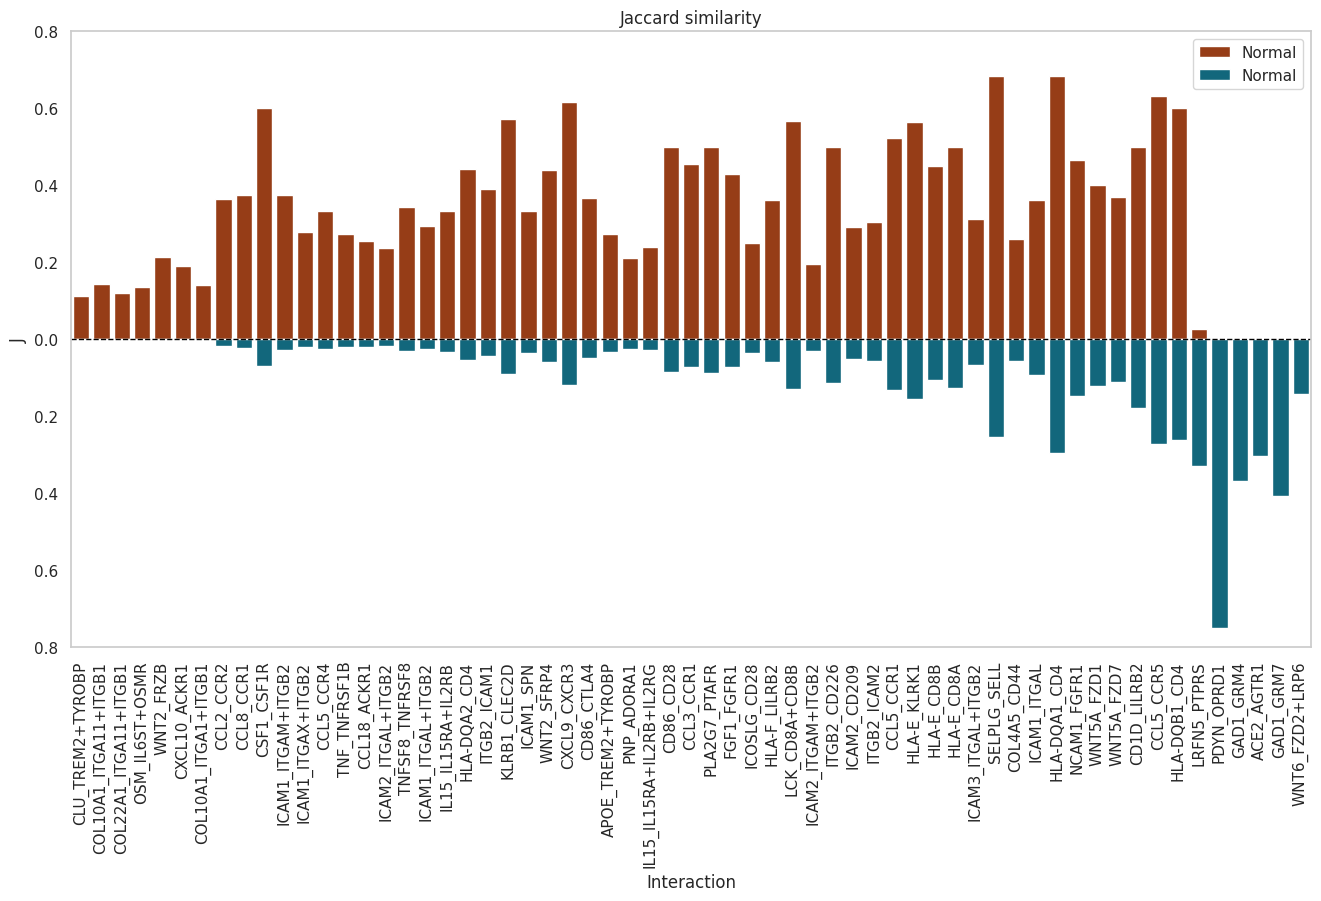

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(ax=ax, x='interaction', y='tumor_j', data=network, color=tcolor, alpha=1, label='Normal')
sns.barplot(ax=ax, x='interaction', y='-normal_j', data=network, color=ncolor, alpha=1, label='Normal')

ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Adding labels and title for subplot 2
ax.set_xlabel('Interaction')
ax.set_ylabel('J')
ax.set_title('Jaccard similarity')
ax.set_ylim(-0.8, 0.8)
ax.legend()
ax.tick_params(axis='x', rotation=90)

# Change negative y-axis ticks to positive and display only the first decimal place
ax.set_yticklabels([f'{abs(x):.1f}' for x in ax.get_yticks()])

plt.show()

# Pathway Network

In [17]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_filtered.csv')
all_pathways = list(set(network['pathway1']).union(set(network['pathway2'])))

In [18]:
len(all_pathways)

169

In [21]:
# Replace 'inf' values with the maximum value
max_value = network.log2_odds_ratio.replace([float('inf'), float('-inf')], float('nan')).max().max()
min_value = network.log2_odds_ratio.replace([float('inf'), float('-inf')], float('nan')).min().min()

network['log2_odds_ratio'] = network['log2_odds_ratio'].replace(float('inf'), max_value)
network['log2_odds_ratio'] = network['log2_odds_ratio'].replace(float('-inf'), min_value)

In [22]:
network.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_no_inf.csv')

In [23]:
roots = pd.read_csv('/home/lnemati/resources/reactome/ReactomeRootPathways.csv')
roots.set_index('pathway', inplace=True)

In [24]:
# Get id-name mapping
ids = pd.read_csv('/home/lnemati/resources/reactome/ReactomeIDs.tsv', sep='\t', names=['name', 'id'])
ids2names = ids.set_index('id')
names2ids = ids.set_index('name')

In [25]:
# Subset
ids = names2ids.loc[all_pathways, 'id'].values
roots = roots.loc[ids]

In [26]:
names = ids2names.loc[roots['root']].name
roots['root'] = names.values

In [27]:
names = ids2names.loc[roots.index].name
roots.index = names.values

In [28]:
roots.loc[network.pathway1]['root']

TNF receptor superfamily (TNFSF) members mediating non-canonical NF-kB pathway                        Immune System
TNFs bind their physiological receptors                                                               Immune System
RUNX1 and FOXP3 control the development of regulatory T lymphocytes (Tregs)         Gene expression (Transcription)
RUNX1 and FOXP3 control the development of regulatory T lymphocytes (Tregs)         Gene expression (Transcription)
Interleukin-15 signaling                                                                              Immune System
                                                                                                ...                
HSF1 activation                                                                       Cellular responses to stimuli
HSF1 activation                                                                       Cellular responses to stimuli
Purinergic signaling in leishmaniasis infection                         

In [29]:
roots.root.value_counts()

Immune System                           35
Disease                                 30
Signal Transduction                     24
Developmental Biology                   15
Metabolism of proteins                  15
Extracellular matrix organization       10
Metabolism                               8
Neuronal System                          7
Gene expression (Transcription)          7
Hemostasis                               7
Vesicle-mediated transport               7
Cellular responses to stimuli            4
Organelle biogenesis and maintenance     1
Cell-Cell communication                  1
Circadian Clock                          1
Muscle contraction                       1
Name: root, dtype: int64

In [30]:
multiple_roots = roots.index.value_counts()[roots.index.value_counts() > 1].index
roots.loc[multiple_roots, 'root'] = 'Multiple root pathways'

In [31]:
roots.loc[network.pathway1]['root'].values.shape

(788,)

In [32]:
for idx, row in network.iterrows():
    if roots.loc[row.pathway1].shape[0] == 1:
        network.at[idx, 'root1'] = roots.loc[row.pathway1]['root']
    else:
        network.at[idx, 'root1'] = 'Multiple roots'
        
    if roots.loc[row.pathway2].shape[0] == 1:
        network.at[idx, 'root2'] = roots.loc[row.pathway2]['root']
    else:
        network.at[idx, 'root2'] = 'Multiple roots'

network.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_no_inf.csv', index=False)

In [33]:
roots.index.name = 'pathway'
network.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_no_inf.csv', index=False)

In [34]:
roots = roots.reset_index().drop_duplicates().set_index('pathway')
roots.to_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_roots.csv')

In [35]:
network['root2'].unique()

array(['Developmental Biology', 'Immune System', 'Signal Transduction',
       'Extracellular matrix organization', 'Metabolism of proteins',
       'Hemostasis', 'Disease', 'Metabolism',
       'Gene expression (Transcription)', 'Circadian Clock',
       'Multiple roots', 'Cellular responses to stimuli',
       'Vesicle-mediated transport', 'Neuronal System',
       'Organelle biogenesis and maintenance'], dtype=object)

In [38]:
subset = roots[roots['root'] == 'Neuronal System']
subset

root
pathway                                                            
Assembly and cell surface presentation of NMDA ...  Neuronal System
Negative regulation of NMDA receptor-mediated n...  Neuronal System
Dopamine Neurotransmitter Release Cycle             Neuronal System
Long-term potentiation                              Neuronal System
Neurexins and neuroligins                           Neuronal System
Unblocking of NMDA receptors, glutamate binding...  Neuronal System
Acetylcholine Neurotransmitter Release Cycle        Neuronal System

In [44]:
edgelist = network[['pathway1', 'pathway2', 'log2_odds_ratio']]
edgelist

pathway1  \
0    TNF receptor superfamily (TNFSF) members media...   
1              TNFs bind their physiological receptors   
2    RUNX1 and FOXP3 control the development of reg...   
3    RUNX1 and FOXP3 control the development of reg...   
4                             Interleukin-15 signaling   
..                                                 ...   
780                                    HSF1 activation   
781                                    HSF1 activation   
782    Purinergic signaling in leishmaniasis infection   
783                         Signaling by FGFR2 IIIa TM   
784                              Syndecan interactions   

                                              pathway2  log2_odds_ratio  
0                        Other semaphorin interactions         5.569856  
1    TNF receptor superfamily (TNFSF) members media...         5.569856  
2                   Interleukin receptor SHC signaling         4.321928  
3                             Interleukin-15 signaling         3.797956  
4                   Interleukin receptor SHC signaling         3.767554  
..                                                 ...              ...  
780         Defective B3GALT6 causes EDSP2 and SEMDJL1        -8.240314  
781                    Defective B3GAT3 causes JDSSDHD        -8.240314  
782                                  Attenuation phase        -8.240314  
783  Cross-presentation of particulate exogenous an...        -8.240314  
784                                  Attenuation phase        -8.240314  

[785 rows x 3 columns]

In [45]:
# Gather all unique pathway names
all_pathways = list(set(edgelist['pathway1']).union(set(edgelist['pathway2'])))

# Create an empty DataFrame with pathways as both index and columns
adjacency_matrix = pd.DataFrame(0, index=all_pathways, columns=all_pathways)

# Iterate over each row in the DataFrame and update the adjacency matrix
for index, row in edgelist.iterrows():
    pathway1 = row['pathway1']
    pathway2 = row['pathway2']
    log2_odds_ratio = row['log2_odds_ratio']
    
    adjacency_matrix.loc[pathway1, pathway2] = log2_odds_ratio
    adjacency_matrix.loc[pathway2, pathway1] = log2_odds_ratio  # Assuming the graph is undirected
    
# Replace 'inf' values with 10 times the maximum value
max_value = adjacency_matrix.replace([float('inf'), float('-inf')], float('nan')).max().max()
adjacency_matrix = adjacency_matrix.replace(float('inf'), max_value)

# Replace '-inf' values with 10 times the minimum value
min_value = adjacency_matrix.replace([float('inf'), float('-inf')], float('nan')).min().min()
adjacency_matrix = adjacency_matrix.replace(float('-inf'), min_value)

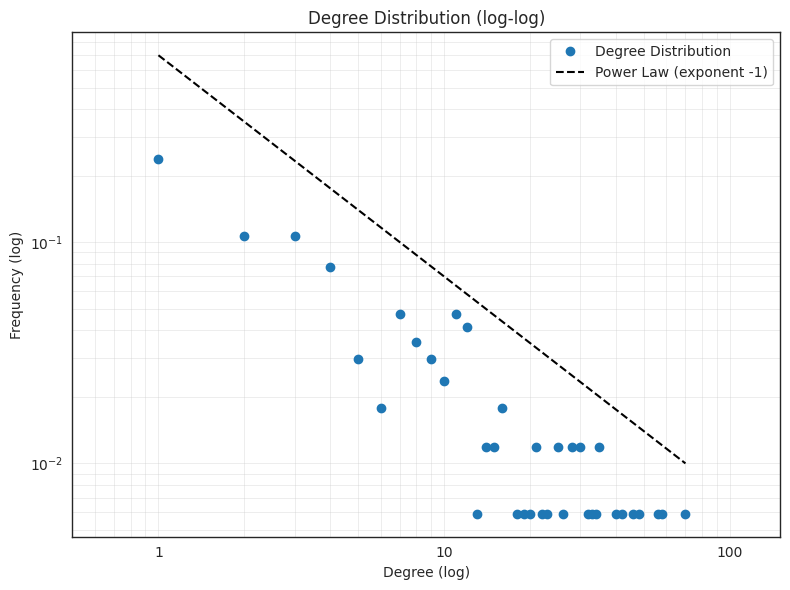

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Assuming you already have the adjacency matrix stored in 'adjacency_matrix'

# Calculate the degrees
degrees = np.abs(adjacency_matrix != 0).sum(axis=1)

degree_counts = (degrees.value_counts() / adjacency_matrix.shape[0]).values
degree_idx = degrees.value_counts().index

# Plot on log-log scale
plt.figure(figsize=(8, 6))
plt.plot(degree_idx, degree_counts, linestyle=' ', marker='o', label='Degree Distribution')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log)')
plt.ylabel('Frequency (log)')
plt.xlim(0.5, 150)
plt.grid(which='both', linestyle='-', linewidth=0.5, alpha=0.5)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.title('Degree Distribution (log-log)')

# Add a line for the theoretical power law with exponent -1
x_values = np.linspace(min(degree_idx), max(degree_idx), 100)
y_values = 0.7 * x_values ** (-1)  # Adjust the constant for visualization
plt.plot(x_values, y_values, color='k', linestyle='--', label='Power Law (exponent -1)')

plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/pathways_network/degree_distribution.pdf')

plt.show()


In [50]:
degrees.sort_values(ascending=False)

Neutrophil degranulation                                                    70
Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell    58
Interleukin-4 and Interleukin-13 signaling                                  56
ECM proteoglycans                                                           48
Integrin cell surface interactions                                          46
                                                                            ..
CD28 dependent Vav1 pathway                                                  1
Adrenaline,noradrenaline inhibits insulin secretion                          1
E3 ubiquitin ligases ubiquitinate target proteins                            1
Negative regulation of NMDA receptor-mediated neuronal transmission          1
TNFs bind their physiological receptors                                      1
Length: 169, dtype: int64

# High level pathways

In [5]:
network = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_network_filtered.csv')

In [8]:
adj = pd.read_csv('/home/lnemati/pathway_crosstalk/results/pathways_network/pathways_high_level_adjacency.csv', index_col=0)

In [9]:
ranked = stack_triangle(adj, 'n')

In [10]:
df = ranked.sort_values(by='n', ascending=False)
df = df[df['n'] > 0]
df.shape

(66, 1)

In [11]:
# Reset index to explode
exploded_df = df.reset_index()

# Rename columns
exploded_df.columns = ['Level 1', 'Level 2', 'n']

for elem in exploded_df['Level 1'] + '-' + exploded_df['Level 2'] + ': ' + exploded_df['n'].astype(int).astype(str):
    print(elem)

Immune System-Disease: 74
Immune System-Extracellular matrix organization: 62
Metabolism of proteins-Immune System: 47
Signal Transduction-Extracellular matrix organization: 44
Disease-Extracellular matrix organization: 35
Disease-Signal Transduction: 33
Signal Transduction-Developmental Biology: 33
Immune System-Signal Transduction: 31
Immune System-Developmental Biology: 30
Metabolism of proteins-Signal Transduction: 23
Metabolism of proteins-Extracellular matrix organization: 22
Extracellular matrix organization-Developmental Biology: 20
Vesicle-mediated transport-Immune System: 16
Gene expression (Transcription)-Immune System: 15
Cellular responses to stimuli-Immune System: 15
Cellular responses to stimuli-Extracellular matrix organization: 15
Metabolism of proteins-Developmental Biology: 14
Disease-Hemostasis: 14
Cellular responses to stimuli-Signal Transduction: 13
Extracellular matrix organization-Hemostasis: 13
Cellular responses to stimuli-Disease: 13
Immune System-Metabolism:

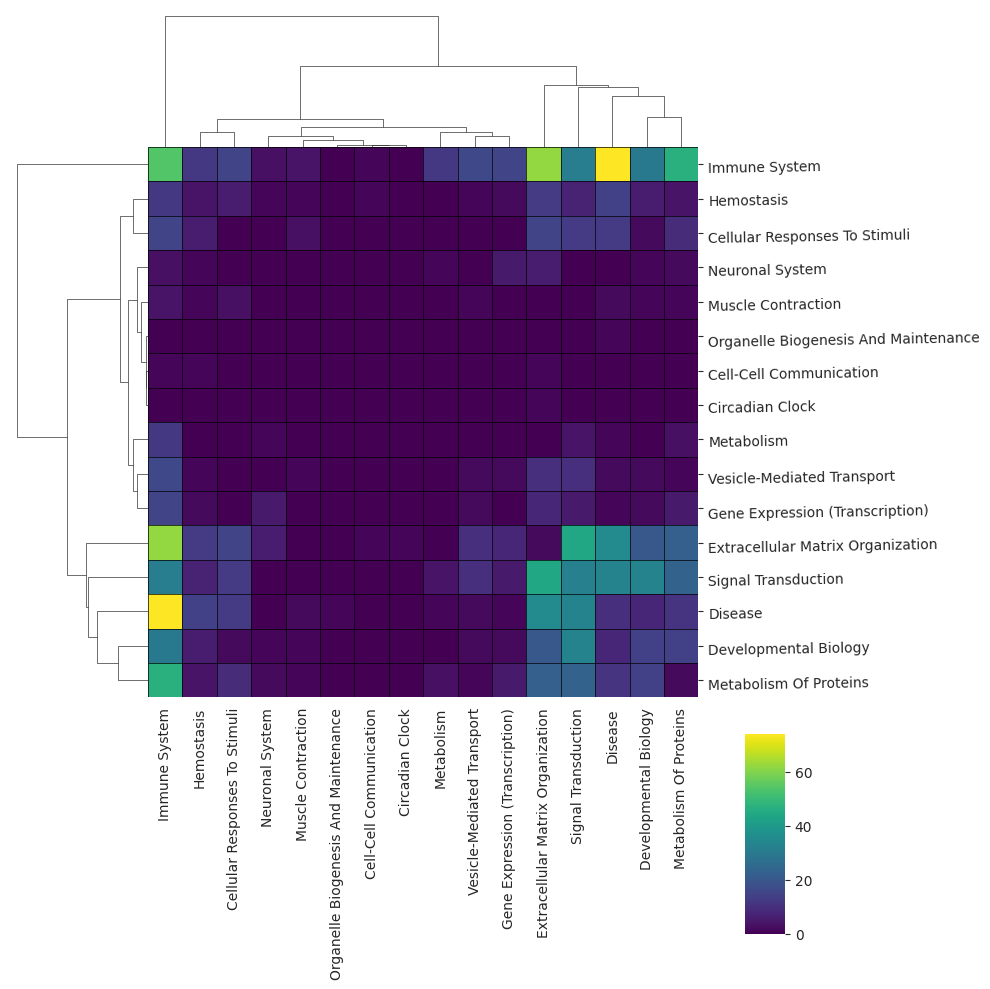

In [12]:
matrix = adj

matrix.columns = [col.title() for col in matrix.columns]
matrix.index   = [idx.title() for idx in matrix.index  ]

g = sns.clustermap(
    adj,
    cmap='viridis',
    cbar_pos=(.75, .06, .04, .2),
    figsize=(10, 10),
    #row_cluster=False,
    #col_cluster=False,
    #row_colors=row_colors,
    #colors_ratio=1/(2*len(all_roots)),
    #vmin=-1.1,
    #vmax=1.1
)

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=1)  # Adjust the rotation as needed

# Add black outline
separators1 = list(range(matrix.shape[1]))
separators1 = separators1 + [max(separators1) + 0.99]
separators2 = list(range(matrix.shape[0]))
separators2 = separators2 + [max(separators2) + 0.99]
g.ax_heatmap.vlines(separators1, *g.ax_heatmap.get_ylim(), color='k', linewidth=0.5, zorder=1)
g.ax_heatmap.hlines(separators2, *g.ax_heatmap.get_xlim(), color='k', linewidth=0.5, zorder=1)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/pathways_network/high_lev_heathmap.pdf', bbox_inches="tight")

# Consensus Modules Modularity

In [5]:
# Print summary about consensus modules
for c in ['normal', 'tumor']:
    for q in ['perc25', 'median']:
        modules = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/consensus_modules/{c}/{q}/consensus_modules.csv', index_col=0)
        print(f'{c}, {q}:')
        print('\tTotal number of modules:', modules['module'].nunique())
        print('\tGenes in biggest module:', modules['module'].value_counts().iloc[0])
        print('\tGenes in smallest module:', modules['module'].value_counts().iloc[-1])
        print('\tAverage genes in modules: {:.1f}'.format(modules['module'].value_counts().mean()))
        print('\tStd genes in modules: {:.1f}'.format(modules['module'].value_counts().std()))

normal, perc25:
	Total number of modules: 32
	Genes in biggest module: 14991
	Genes in smallest module: 20
	Average genes in modules: 556.6
	Std genes in modules: 2634.4
normal, median:
	Total number of modules: 55
	Genes in biggest module: 11368
	Genes in smallest module: 21
	Average genes in modules: 323.8
	Std genes in modules: 1518.6
tumor, perc25:
	Total number of modules: 41
	Genes in biggest module: 12917
	Genes in smallest module: 21
	Average genes in modules: 406.2
	Std genes in modules: 2004.7
tumor, median:
	Total number of modules: 53
	Genes in biggest module: 9680
	Genes in smallest module: 25
	Average genes in modules: 314.3
	Std genes in modules: 1322.7


In [6]:
condition='tumor'
quantile='median'

combinations = [['tumor', 'median'],
                ['tumor', 'perc25'],
                ['normal', 'median'],
                ['normal', 'perc25']]

modularities = pd.DataFrame(combinations, columns=['condition', 'quantile'])

for i in modularities.index:
    condition = modularities.at[i, 'condition']
    quantile= modularities.at[i, 'quantile']
    for path, subdirs, files in os.walk(f'/home/lnemati/pathway_crosstalk/results/consensus_modules/{condition}/{quantile}/tissues'):
        for name in files:
            if name == 'modularity.txt':
                tissue = path.split('/')[-1]
                with open(os.path.join(path, name)) as f:
                    m = float(f.readlines()[0])
                modularities.at[i, tissue] = m
    result = modularities.iloc[i, 2:].dropna().mean()
    print(condition, quantile, "{:.2f}".format(result))

tumor median 0.30
tumor perc25 0.24
normal median 0.15
normal perc25 0.13


In [7]:
tmod = modularities.iloc[0, 2:].dropna()

In [8]:
nmod = modularities.iloc[2, 2:].dropna()

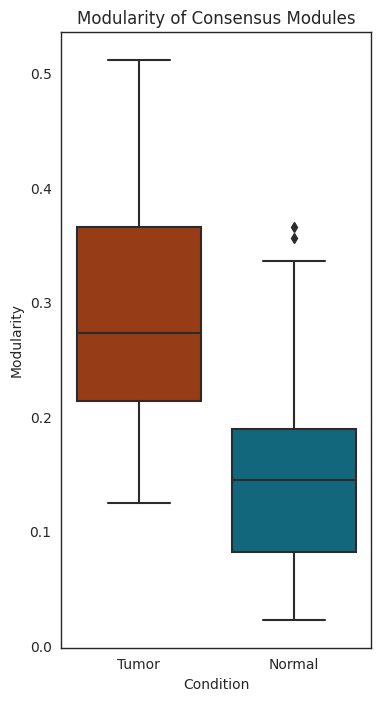

In [17]:
# Create a DataFrame from the Series
data = pd.DataFrame({
    'Tumor': tmod,
    'Normal': nmod
})

palette = {
    'Tumor': tcolor,
    'Normal': ncolor
}

# Melt the DataFrame to long format
data_melted = data.reset_index().melt(id_vars='index', var_name='Condition', value_name='Modularity')

# Plotting
fig, ax = plt.subplots(1,1, figsize=(4, 8))
sns.boxplot(x='Condition', y='Modularity', data=data_melted, palette=palette, ax=ax)
plt.title('Modularity of Consensus Modules')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/modules/modularity.pdf', bbox_inches='tight')

plt.show()

In [14]:
modularities

condition quantile  rectum_adenocarcinoma  uterine_carcinosarcoma  \
0     tumor   median               0.213984                0.409329   
1     tumor   perc25               0.152449                0.382569   
2    normal   median                    NaN                     NaN   
3    normal   perc25                    NaN                     NaN   

   thyroid_carcinoma  kidney_papillary_cell_carcinoma  kidney_chromophobe  \
0           0.270945                         0.405588            0.260738   
1           0.223747                         0.360991            0.203821   
2                NaN                              NaN                 NaN   
3                NaN                              NaN                 NaN   

   kidney_clear_cell_carcinoma  brain_lower_grade_glioma  \
0                     0.428774                  0.239180   
1                     0.361575                  0.180954   
2                          NaN                       NaN   
3                          NaN                       NaN   

   glioblastoma_multiforme  ...  thyroid  pituitary  \
0                 0.345059  ...      NaN        NaN   
1                 0.273918  ...      NaN        NaN   
2                      NaN  ...  0.15154   0.139404   
3                      NaN  ...  0.13170   0.087609   

   small_intestine_terminal_ileum  colon_sigmoid  colon_transverse    spleen  \
0                             NaN            NaN               NaN       NaN   
1                             NaN            NaN               NaN       NaN   
2                        0.044584       0.075677          0.038455  0.144457   
3                        0.018850       0.048545          0.013719  0.142685   

   esophagus_gastroesophageal_junction  esophagus_muscularis  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                             0.192365              0.179599   
3                             0.156156              0.159618   

   esophagus_mucosa   stomach  
0               NaN       NaN  
1               NaN       NaN  
2          0.194562  0.043961  
3          0.156822  0.016237  

[4 rows x 81 columns]

0.19323022161004785


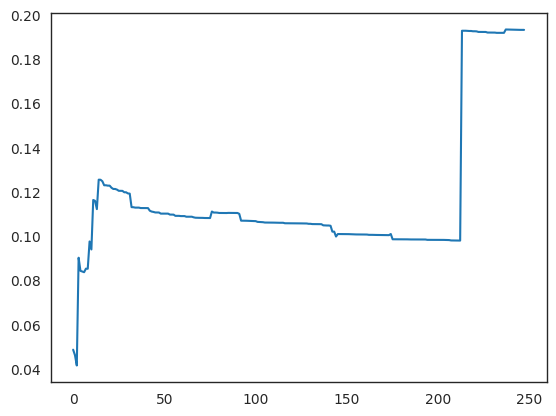

In [15]:
results = []

for column in all_clusterings.columns:
    clustering = all_clusterings.loc[adj.index, column].values          
    modularity = g.modularity(clustering, weights=g.es['weight'])
    results.append(modularity)
    
results = np.array(results)

print(results.max())
plt.plot(results)

In [141]:
import os
import pandas as pd

#quantile = 'perc25'
quantile = 'median'

# Define the root directory where you want to search
root_dir = f'/home/lnemati/pathway_crosstalk/results/consensus_modules/tumor/{quantile}/tissues'
all_clusterings = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/consensus_modules/tumor/{quantile}/all_clusterings.csv', index_col=0)

# Initialize an empty dataframe for merging
merged_df = None

# Walk through all subdirectories
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file == 'modularity.csv':
            file_path = os.path.join(subdir, file)
            name = file_path.split('/')[-2]
            # Read the CSV file
            df = pd.read_csv(file_path, index_col=0)  # Assuming the index is in the first column
            df.columns = [f"{col}_{name}" for col in df.columns]
            # Merge the dataframe with the existing one on index (horizontally)
            if merged_df is None:
                merged_df = df  # Initialize merged_df with the first dataframe
            else:
                merged_df = merged_df.join(df, how='inner')  # Join on index (outer join to keep all indices)

# Save the merged dataframe to a new CSV file
# merged_df.to_csv('merged_modularity.csv', index=False)

print("All files have been successfully merged horizontally!")


All files have been successfully merged horizontally!


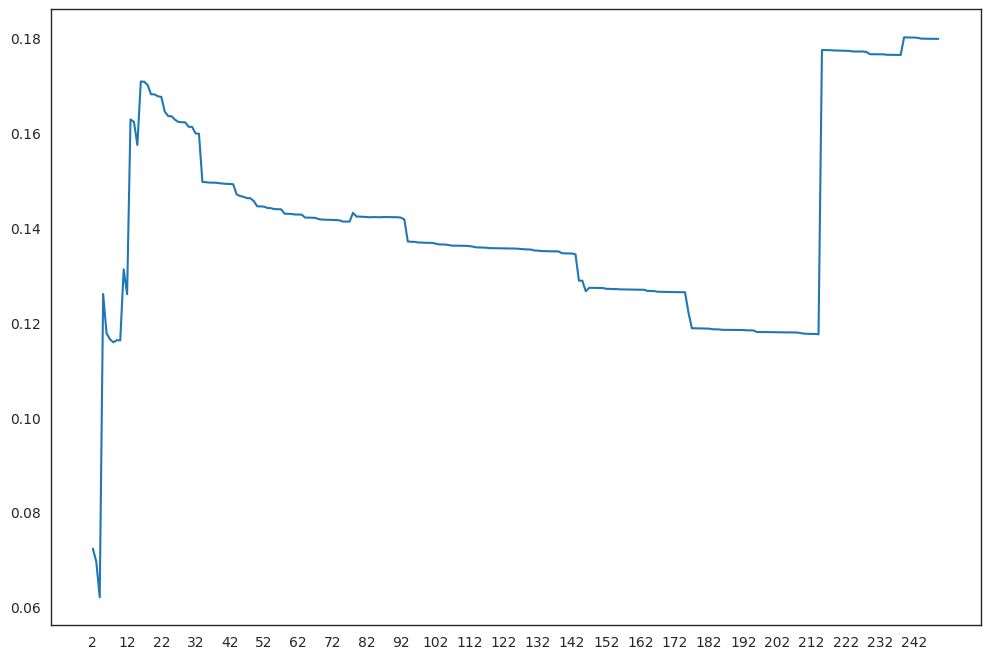

In [142]:
n_clust = list(merged_df.mean(axis=1).index.str.split('_',expand=True).get_level_values(0))
means = merged_df.mean(axis=1).values

plt.figure(figsize=(12,8))
plt.plot(n_clust, means)
plt.xticks(np.arange(0, len(n_clust), 10))
plt.show()

# Explore Raw Data

In [5]:
import scanpy as sc

In [6]:
adata = sc.read_h5ad('/projects/bioinformatics/DB/Xena/TCGA_GTEX/TCGA_GTEX.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 18305 × 60498
    obs: 'detailed_category', 'primary_disease_or_tissue', 'X_primary_site', 'X_sample_type', 'X_gender', 'X_study'
    layers: 'TPM', 'raw_counts'

In [8]:
adata.obs.X_sample_type.value_counts()

Primary Tumor                                      9181
Normal Tissue                                      7412
Solid Tissue Normal                                 726
Metastatic                                          392
Cell Line                                           363
Primary Blood Derived Cancer - Peripheral Blood     173
Recurrent Tumor                                      45
Additional - New Primary                             11
Additional Metastatic                                 1
Control Analyte                                       1
Name: X_sample_type, dtype: int64

In [7]:
adata = adata[adata.obs.X_sample_type.isin(['Primary Tumor', 'Normal Tissue'])]

In [11]:
adata.obs

detailed_category  \
GTEX-1117F-0226-SM-5GZZ7          Adipose - Subcutaneous   
GTEX-1117F-0426-SM-5EGHI               Muscle - Skeletal   
GTEX-1117F-0526-SM-5EGHJ                 Artery - Tibial   
GTEX-1117F-0626-SM-5N9CS               Artery - Coronary   
GTEX-1117F-0726-SM-5GIEN        Heart - Atrial Appendage   
...                                                  ...   
TCGA-ZS-A9CG-01           Liver Hepatocellular Carcinoma   
TCGA-ZT-A8OM-01                                  Thymoma   
TCGA-ZU-A8S4-01                       Cholangiocarcinoma   
TCGA-ZU-A8S4-11                       Cholangiocarcinoma   
TCGA-ZX-AA5X-01           Cervical & Endocervical Cancer   

                               primary_disease_or_tissue  X_primary_site  \
GTEX-1117F-0226-SM-5GZZ7          Adipose - Subcutaneous  Adipose Tissue   
GTEX-1117F-0426-SM-5EGHI               Muscle - Skeletal          Muscle   
GTEX-1117F-0526-SM-5EGHJ                 Artery - Tibial    Blood Vessel   
GTEX-1117F-0626-SM-5N9CS               Artery - Coronary    Blood Vessel   
GTEX-1117F-0726-SM-5GIEN        Heart - Atrial Appendage           Heart   
...                                                  ...             ...   
TCGA-ZS-A9CG-01           Liver Hepatocellular Carcinoma           Liver   
TCGA-ZT-A8OM-01                                  Thymoma          Thymus   
TCGA-ZU-A8S4-01                       Cholangiocarcinoma       Bile duct   
TCGA-ZU-A8S4-11                       Cholangiocarcinoma       Bile duct   
TCGA-ZX-AA5X-01           Cervical & Endocervical Cancer          Cervix   

                                X_sample_type X_gender X_study  
GTEX-1117F-0226-SM-5GZZ7        Normal Tissue   Female    GTEX  
GTEX-1117F-0426-SM-5EGHI        Normal Tissue   Female    GTEX  
GTEX-1117F-0526-SM-5EGHJ        Normal Tissue   Female    GTEX  
GTEX-1117F-0626-SM-5N9CS        Normal Tissue   Female    GTEX  
GTEX-1117F-0726-SM-5GIEN        Normal Tissue   Female    GTEX  
...                                       ...      ...     ...  
TCGA-ZS-A9CG-01                 Primary Tumor     Male    TCGA  
TCGA-ZT-A8OM-01                 Primary Tumor   Female    TCGA  
TCGA-ZU-A8S4-01                 Primary Tumor     Male    TCGA  
TCGA-ZU-A8S4-11           Solid Tissue Normal     Male    TCGA  
TCGA-ZX-AA5X-01                 Primary Tumor   Female    TCGA  

[18305 rows x 6 columns]

In [9]:
sc.pp.pca(adata)

In [17]:
sc.pp.neighbors(adata)

In [18]:
sc.tl.umap(adata)

In [14]:
adata.obs

detailed_category  \
GTEX-1117F-0226-SM-5GZZ7          Adipose - Subcutaneous   
GTEX-1117F-0426-SM-5EGHI               Muscle - Skeletal   
GTEX-1117F-0526-SM-5EGHJ                 Artery - Tibial   
GTEX-1117F-0626-SM-5N9CS               Artery - Coronary   
GTEX-1117F-0726-SM-5GIEN        Heart - Atrial Appendage   
...                                                  ...   
TCGA-ZS-A9CG-01           Liver Hepatocellular Carcinoma   
TCGA-ZT-A8OM-01                                  Thymoma   
TCGA-ZU-A8S4-01                       Cholangiocarcinoma   
TCGA-ZU-A8S4-11                       Cholangiocarcinoma   
TCGA-ZX-AA5X-01           Cervical & Endocervical Cancer   

                               primary_disease_or_tissue  X_primary_site  \
GTEX-1117F-0226-SM-5GZZ7          Adipose - Subcutaneous  Adipose Tissue   
GTEX-1117F-0426-SM-5EGHI               Muscle - Skeletal          Muscle   
GTEX-1117F-0526-SM-5EGHJ                 Artery - Tibial    Blood Vessel   
GTEX-1117F-0626-SM-5N9CS               Artery - Coronary    Blood Vessel   
GTEX-1117F-0726-SM-5GIEN        Heart - Atrial Appendage           Heart   
...                                                  ...             ...   
TCGA-ZS-A9CG-01           Liver Hepatocellular Carcinoma           Liver   
TCGA-ZT-A8OM-01                                  Thymoma          Thymus   
TCGA-ZU-A8S4-01                       Cholangiocarcinoma       Bile duct   
TCGA-ZU-A8S4-11                       Cholangiocarcinoma       Bile duct   
TCGA-ZX-AA5X-01           Cervical & Endocervical Cancer          Cervix   

                                X_sample_type X_gender X_study  
GTEX-1117F-0226-SM-5GZZ7        Normal Tissue   Female    GTEX  
GTEX-1117F-0426-SM-5EGHI        Normal Tissue   Female    GTEX  
GTEX-1117F-0526-SM-5EGHJ        Normal Tissue   Female    GTEX  
GTEX-1117F-0626-SM-5N9CS        Normal Tissue   Female    GTEX  
GTEX-1117F-0726-SM-5GIEN        Normal Tissue   Female    GTEX  
...                                       ...      ...     ...  
TCGA-ZS-A9CG-01                 Primary Tumor     Male    TCGA  
TCGA-ZT-A8OM-01                 Primary Tumor   Female    TCGA  
TCGA-ZU-A8S4-01                 Primary Tumor     Male    TCGA  
TCGA-ZU-A8S4-11           Solid Tissue Normal     Male    TCGA  
TCGA-ZX-AA5X-01                 Primary Tumor   Female    TCGA  

[18305 rows x 6 columns]

In [33]:
tissue_dict = {
    'thyroid': 'thyroid',
    'thyroid gland': 'thyroid',
    'vagina': 'female reproductive',
    'uterus': 'female reproductive',
    'ovary': 'female reproductive',
    'fallopian tube': 'female reproductive',
    'endometrium': 'female reproductive',
    'cervix': 'female reproductive',
    'cervix uteri': 'female reproductive',
    }

/home/lnemati/.conda/envs/WGCNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


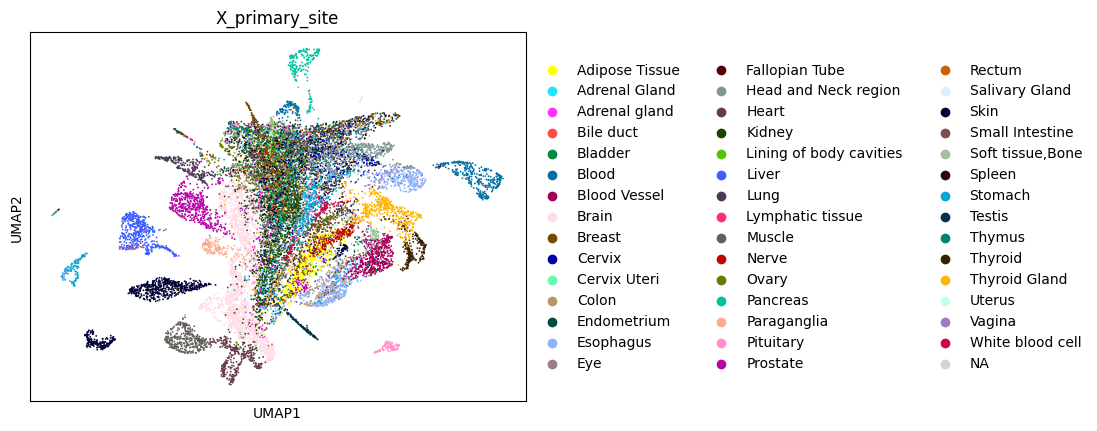

/home/lnemati/.conda/envs/WGCNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


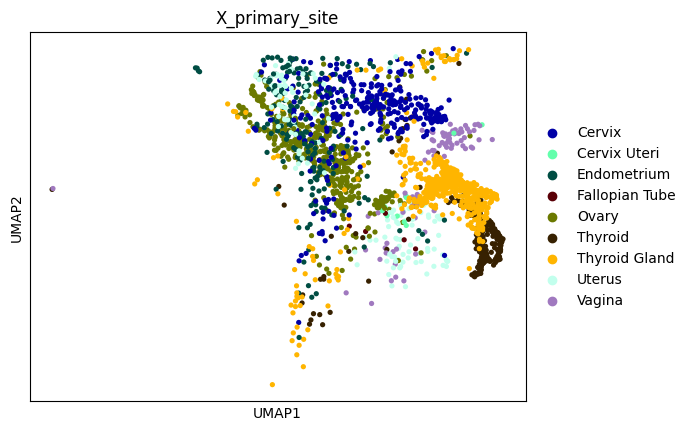

In [35]:
tissues = ['thyroid', 'thyroid gland', 'vagina', 'uterus', 'ovary', 'fallopian tube', 'endometrium', 'cervix', 'cervix uteri']
sc.pl.umap(adata, color=['X_primary_site'], ncols=1)
sc.pl.umap(adata[adata.obs.X_primary_site.str.lower().isin(tissues)], color=['X_primary_site'], ncols=1)

/home/lnemati/.conda/envs/WGCNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


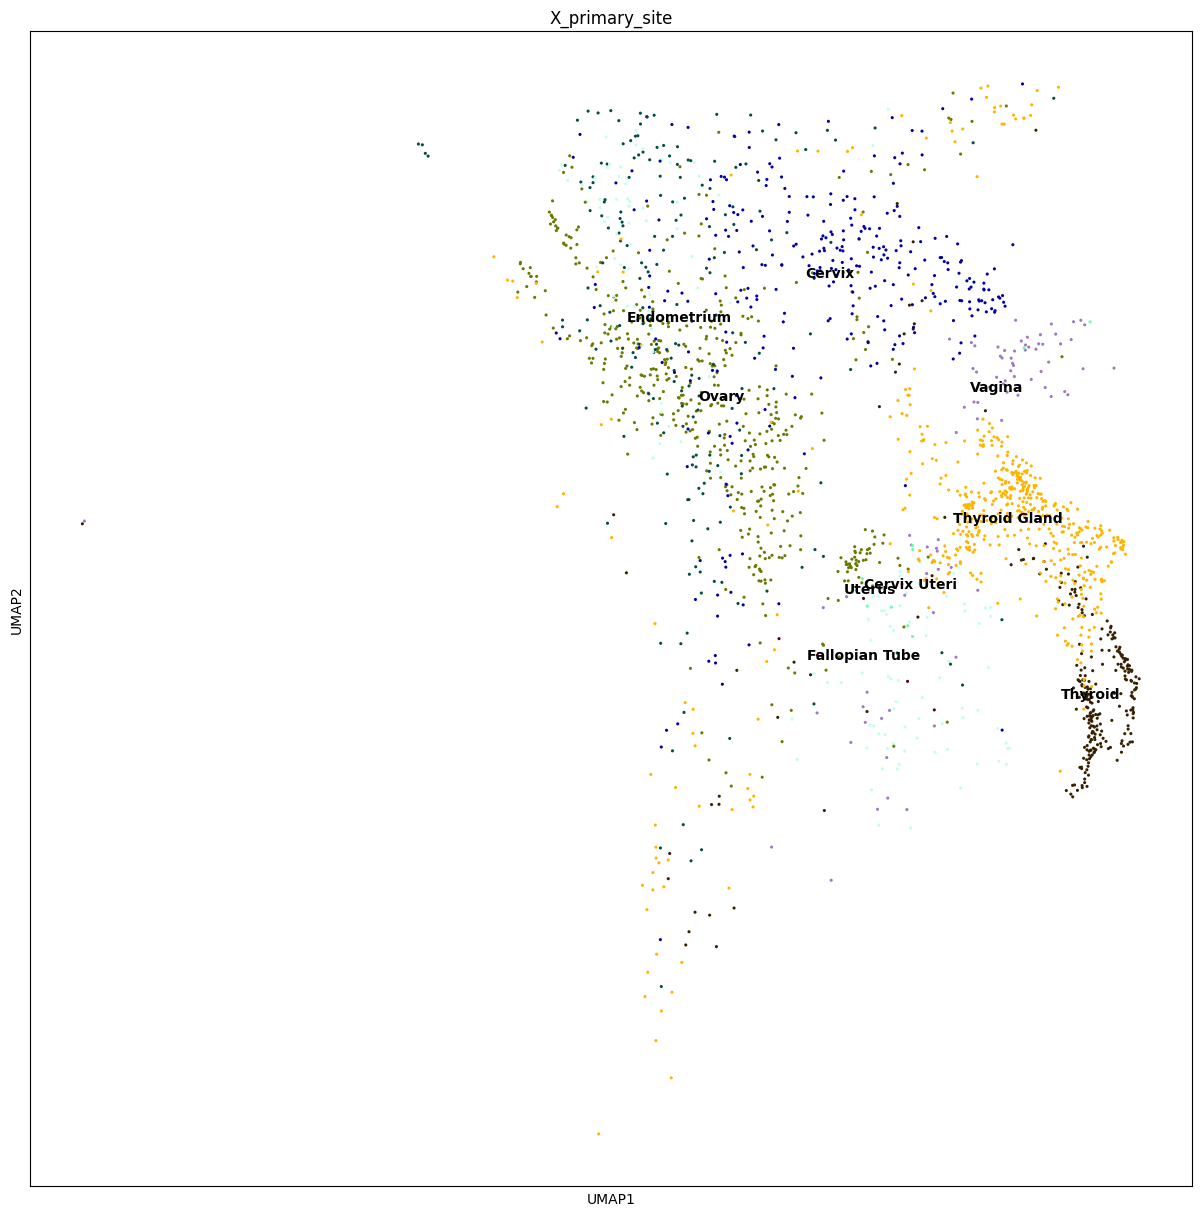

In [37]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
sc.pl.umap(adata[adata.obs.X_primary_site.str.lower().isin(tissues)], color=['X_primary_site'], legend_loc='on data', size=20, ncols=1, ax=ax)

In [ ]:
sc.pl.pca(adata, color=)

# Consensus Modules Enrichment

In [21]:
conditions = ('tumor', 'normal')
quantiles = ('perc25', 'median')

for condition in conditions:
    for quantile in quantiles:
        print(condition, quantile)
        enr = pd.read_csv(f'/home/lnemati/pathway_crosstalk/results/consensus_modules/{condition}/{quantile}/enrichment.csv')
        for module, df in enr.groupby('module'):
            top3 = df.sort_values(by='Adjusted P-value', ascending=True).head(3).Term.values.tolist()
            print(module, top3)
        print()

tumor perc25
0 ['Neuronal System', 'Sensory Perception', 'Metabolism of lipids']
1 ['Chromatin modifying enzymes', 'Chromatin organization', 'Gene expression (Transcription)']
2 ['Immune System', 'Innate Immune System', 'Adaptive Immune System']
3 ['Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.', 'Aerobic respiration and respiratory electron transport', 'Respiratory electron transport']
4 ['Complex I biogenesis', 'Respiratory electron transport', 'Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.']
5 ['Cell Cycle', 'Cell Cycle, Mitotic', 'Cell Cycle Checkpoints']
6 ['Signal Transduction', 'Extracellular matrix organization', 'Integrin cell surface interactions']
7 ['Gluconeogenesis', 'Cytosolic iron-sulfur cluster assembly', 'Glucose metabolism']
8 ['Eukaryotic Translation Elongation', 'Peptide chain elongation', 'Formation of a pool of free 40S subuni

In [5]:
adata = sc.read_h5ad('/projects/bioinformatics/DB/Xena/TCGA_GTEX/TCGA_GTEX.h5ad')

print("Subsetting samples")

rename = {
    "X_study": "study",
    "X_gender": "gender",
    "X_sample_type": "type",
    "X_primary_site": "tissue",
    "primary_disease_or_tissue": "condition"
}

adata.obs.rename(columns=rename, inplace=True)
adata.obs.drop(columns="detailed_category", inplace=True)

adata = adata[adata.obs.type.isin(["Primary Tumor", "Normal Tissue"])]


Subsetting samples


In [6]:
# retrieve gene symbol of protein coding genes                                                                                
annot = pd.read_csv("~/resources/biomart/ensembl_to_symbol_filtered.csv.gz", index_col="Gene stable ID")                      
                                                                                                                              
# remove ensembl version                                                                                                      
adata.var["ensembl"] = adata.var_names.str.replace(r"\..*","", regex=True)                                                    
adata.var_names = adata.var["ensembl"].values                                                                                 
                                                                                                                              
# subset to genes in biomart                                                                                                  
adata = adata[:, adata.var_names.isin(annot.index)]                                                                           
                                                                                                                              
# add gene symbols                                                                                                            
adata.var["symbol"] = annot["Gene name"]                                                                                      
                                                                                                                              
# remove genes with missing symbol                                                                                            
adata = adata[:, ~adata.var.symbol.isna()]                                                                                    
                                                                                                                              
# set index to gene symbol                                                                                                    
adata.var_names = adata.var.symbol.values 

In [7]:
modules = pd.read_csv('/home/lnemati/pathway_crosstalk/results/consensus_modules/tumor/median/consensus_modules.csv', index_col=0)

In [8]:
genes = modules.index

In [9]:
adata = adata[:, genes]

In [ ]:
adata.var['module'] = modules['module']

In [1]:
adata

NameError: name 'adata' is not defined